<a href="https://colab.research.google.com/github/AsaCooperStickland/FlatMinimaInterpretability/blob/main/git_rebasin_Asa_MLP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adding to the Git Re-Basin replication 
 
The Git Re-Basin paper (https://arxiv.org/abs/2209.04836) generated a lot of discussion, including a [replication](https://twitter.com/stanislavfort/status/1571967289649688576) by Stanislav Fort.

The initial replication contains the following result: "I have two networks trained from init (model 1 and model 2), and the permutation from the paper applied to model 2 towards model 1. The model 2 + permutation should be in the same linearly connected basin as model 1, which would suggest a nice linear path of low loss between the aqua triangle and the red circle. However, as you can see, there is a bump! The yellow line isn't a nice connected bridge and  on top of that the loss on the weight space cut defined by the model 1, model 2 and model 2 + permutation shows clearly 3 different basins, not 2, as the key claim would suggest."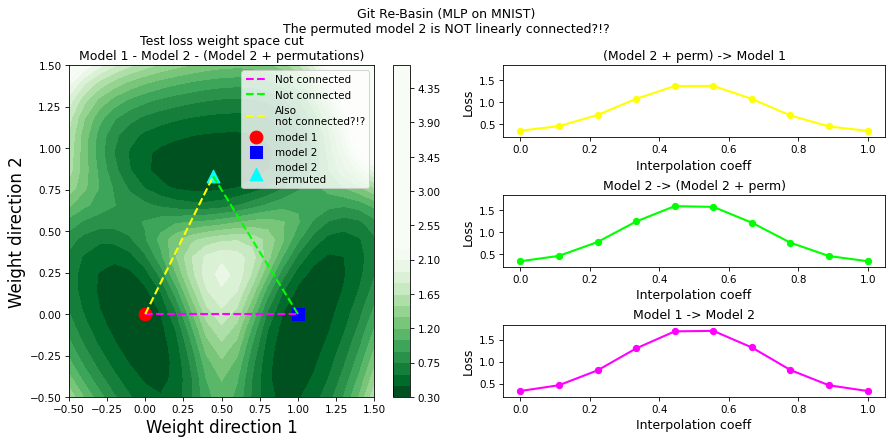

## Library imports

In [1]:
!pip install augmax
# Install the newest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 8.0 MB/s 
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 9.1 MB/s eta 0:00:00


## Permutation utils

In [2]:
from collections import defaultdict
from typing import NamedTuple

import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

# def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
#   """We assume that one permutation cannot appear in two axes of the same weight array."""
#   assert num_hidden_layers >= 1
#   return PermutationSpec(
#       perm_to_axes={
#           f"P_{i}": [(f"Dense_{i}/kernel", 1), (f"Dense_{i}/bias", 0), (f"Dense_{i+1}/kernel", 0)]
#           for i in range(num_hidden_layers)
#       },
#       axes_to_perm={
#           "Dense_0/kernel": (None, "P_0"),
#           **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
#              for i in range(1, num_hidden_layers)},
#           **{f"Dense_{i}/bias": (f"P_{i}", )
#              for i in range(num_hidden_layers)},
#           f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
#           f"Dense_{num_hidden_layers}/bias": (None, ),
#       })

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def vgg16_permutation_spec() -> PermutationSpec:
  return permutation_spec_from_axes_to_perm({
      "Conv_0/kernel": (None, None, None, "P_Conv_0"),
      **{f"Conv_{i}/kernel": (None, None, f"P_Conv_{i-1}", f"P_Conv_{i}")
         for i in range(1, 13)},
      **{f"Conv_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/scale": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      "Dense_0/kernel": ("P_Conv_12", "P_Dense_0"),
      "Dense_0/bias": ("P_Dense_0", ),
      "Dense_1/kernel": ("P_Dense_0", "P_Dense_1"),
      "Dense_1/bias": ("P_Dense_1", ),
      "Dense_2/kernel": ("P_Dense_1", None),
      "Dense_2/bias": (None, ),
  })

def resnet20_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}/kernel": (None, None, p_in, p_out)}
  norm = lambda name, p: {f"{name}/scale": (p, ), f"{name}/bias": (p, )}
  dense = lambda name, p_in, p_out: {f"{name}/kernel": (p_in, p_out), f"{name}/bias": (p_out, )}

  # This is for easy blocks that use a residual connection, without any change in the number of channels.
  easyblock = lambda name, p: {
      **conv(f"{name}/conv1", p, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p),
      **norm(f"{name}/norm2", p)
  }

  # This is for blocks that use a residual connection, but change the number of channels via a Conv.
  shortcutblock = lambda name, p_in, p_out: {
      **conv(f"{name}/conv1", p_in, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p_out),
      **norm(f"{name}/norm2", p_out),
      **conv(f"{name}/shortcut/layers_0", p_in, p_out),
      **norm(f"{name}/shortcut/layers_1", p_out),
  }

  return permutation_spec_from_axes_to_perm({
      **conv("conv1", None, "P_bg0"),
      **norm("norm1", "P_bg0"),
      #
      **easyblock("blockgroups_0/blocks_0", "P_bg0"),
      **easyblock("blockgroups_0/blocks_1", "P_bg0"),
      **easyblock("blockgroups_0/blocks_2", "P_bg0"),
      #
      **shortcutblock("blockgroups_1/blocks_0", "P_bg0", "P_bg1"),
      **easyblock("blockgroups_1/blocks_1", "P_bg1"),
      **easyblock("blockgroups_1/blocks_2", "P_bg1"),
      #
      **shortcutblock("blockgroups_2/blocks_0", "P_bg1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_2", "P_bg2"),
      #
      **dense("dense", "P_bg2", None),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm

def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)
  print(perm)



## Utils

In [3]:
import operator
import re
import time

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


## Define model

In [4]:

"""Train an MLP on MNIST on one random seed. Serialize the model for
interpolation downstream."""
import argparse

import augmax
import flax
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn
from flax.training.train_state import TrainState
from jax import jit, random, tree_map, value_and_grad, vmap, grad, jacfwd, jacrev
from tqdm import tqdm

# See https://github.com/tensorflow/tensorflow/issues/53831.

# See https://github.com/google/jax/issues/9454.
tf.config.set_visible_devices([], "GPU")

activation = nn.relu

class MLPModel(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(512)(x)
    a1 = activation(x)
    x = nn.Dense(512)(a1)
    a2 = activation(x)
    x = nn.Dense(512)(a2)
    a3 = activation(x)
    x = nn.Dense(10)(a3)
    x = nn.log_softmax(x)
    return x, a1, a2, a3

def make_stuff(model):
  normalize_transform = augmax.ByteToFloat()
 
  # @jit
  # def hutchinson_trace_autodiff(model, loss, V):
  #   """Hessian trace estimate using autodiff HVPs."""
  #   trace = 0

 #    for _ in range(V):
  #       vec = [rademacher(p.shape) for p in model.parameters()]
  #       Hvec = hvp(loss, list(model.parameters()), vec)

 #        for v, Hv in zip(vec, Hvec):
  #           vHv = torch.einsum("i,i->", v.flatten(), Hv.flatten())
  #           trace += vHv / V

 #    return trace

  # @jit
  # def hvp(f, x, v):
  #   return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)
  @jit
  def hessian(f):
    return jacfwd(jacrev(f))
  
  @jit
  def batch_loss(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits, *_ = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    return loss

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits, a1, a2, a3 = model.apply({"params": params}, images_f32)
    entropy = 0.
    sparsity = 0.
    for a in [a1, a2, a3]:
      sparsity += jnp.mean(jnp.where(a > 0., x=0, y=1)) / 3.
      entropy += jnp.sum(jax.scipy.special.entr(jax.nn.softmax(a)))
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, {
      "num_correct": num_correct, "entropy": entropy,
      "sparsity": sparsity
    }

  @jit
  def batch_eval_hessian(params, images_u8, labels, fisher_weight):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits, *_ = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    # (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    grad = jax.grad(batch_loss)(params, images_u8, labels)
    trace = jnp.sum(jnp.square(jax.flatten_util.ravel_pytree(grad)[0]))
    # trace = sum(jnp.sum(jnp.square(x)) for x in jax.tree_util.tree_leaves(g))
    # jax.debug.print('tr ', trace)
    # grads_flat, grads_tree_def = jax.tree_util.tree_flatten(g)
    # grad_norms = vmap(optax.linear_algebra.global_norm)(grads_flat)
    # trace = jnp.sum(grad_norms)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    # jax.debug.print('before', loss)
    loss_trace = loss + fisher_weight * trace
    # jax.debug.print('after', loss)
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss_trace, {"num_correct": num_correct, "loss_before": loss}

  # Stan's addition for saving predictions of the model to see how they differ
  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits, *_ = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(train_state, images_f32, labels):
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}
    
  @jit
  def step_hessian(train_state, images_f32, labels, fisher_weight):
    (l, info), g = value_and_grad(batch_eval_hessian, has_aux=True)(train_state.params, images_f32, labels, fisher_weight)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        sum(x["entropy"] for x in infos) / num_examples,
        sum(x["sparsity"] for x in infos) / num_batches,
    )

  # Stan's addition for saving predictions of the model to see how they differ
  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits, y_onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        y_onehots,
    )

  return {
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "step_hessian": step_hessian,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }


def load_datasets():
  """Return the training and test datasets, unbatched."""
  # See https://www.tensorflow.org/datasets/overview#as_batched_tftensor_batch_size-1.
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds



## Runs details

In [5]:
num_epochs = 20
batch_size = 500
seed = 12421
config_optimizer = "sgd" #"adam"
learning_rate = 0.1
fisher_weight = 0.5

runs_to_collect = 2 #Stan's new stuff
hessian = True

rng = random.PRNGKey(seed)

In [6]:
# storing model params after training
flattened_models_list = []

for run_i in range(runs_to_collect):

  rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
  rngmix = lambda rng, x: random.fold_in(rng, hash(x))

  model = MLPModel()
  stuff = make_stuff(model)

  print("--------------------------")
  print(f"Starting run {run_i}")


  train_ds, test_ds = load_datasets()
  print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
  print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

  num_train_examples = train_ds["images_u8"].shape[0]
  num_test_examples = test_ds["images_u8"].shape[0]
  assert num_train_examples % batch_size == 0
  print("num_train_examples", num_train_examples)
  print("num_test_examples", num_test_examples)

  if config_optimizer == "sgd":
    # See runs:
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/3blb4uhm
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/174j7umt
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/td02y8gg
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=1e-6,
        peak_value=learning_rate,
        warmup_steps=10,
        # Confusingly, `decay_steps` is actually the total number of steps,
        # including the warmup.
        decay_steps=num_epochs * (num_train_examples // batch_size),
    )
    tx = optax.sgd(lr_schedule, momentum=0.9)
  elif config_optimizer == "adam":
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1b1gztfx (trim-fire-575)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1hrmw7wr (wild-dream-576)
    tx = optax.adam(learning_rate)
  else:
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/k4luj7er (faithful-spaceship-579)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/3ru7xy8c (sage-forest-580)
    tx = optax.adamw(learning_rate, weight_decay=1e-4)

  train_state = TrainState.create(
      apply_fn=model.apply,
      params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
      tx=tx,
  )

  for epoch in tqdm(range(num_epochs)):
    infos = []
  
    batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
        (-1, batch_size))
    for i in range(batch_ix.shape[0]):
      p = batch_ix[i, :]
      images_u8 = train_ds["images_u8"][p, :, :, :]
      labels = train_ds["labels"][p]
      if hessian:
        train_state, info = stuff["step_hessian"](train_state, images_u8, labels, fisher_weight)
      else:
        train_state, info = stuff["step"](train_state, images_u8, labels)
      infos.append(info)
    

    train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
    train_loss_before = sum(batch_size * x["loss_before"] for x in infos) / num_train_examples
    print(train_loss_before, "loss")
    print(train_loss, "loss after")
    train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

    
    actest_loss, test_accuracy, entropy, sparsity = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                    10_000)

    params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                          flatten_params({"params_l2": train_state.params}))
    
    
  # summary
  print("-----------------")
  print(f"Run {run_i} DONE!")
  test_loss, test_accuracy, train_entropy, _ = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                10_000)
  train_loss, train_accuracy, test_entropy, sparsity = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                60_000)
  print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} test sparsity={sparsity} test entropy {test_entropy} train loss={train_loss} train accuracy={train_accuracy} train entropy={train_entropy}")

  flattened_models_list.append(flatten_params(train_state.params))


--------------------------
Starting run 0


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


  0%|          | 0/20 [00:00<?, ?it/s]

0.9457428 loss
1.1530378 loss after


 10%|█         | 2/20 [00:07<00:59,  3.29s/it]

0.18869059 loss
0.24169242 loss after


 15%|█▌        | 3/20 [00:08<00:33,  1.97s/it]

0.11563737 loss
0.15144464 loss after


 20%|██        | 4/20 [00:08<00:21,  1.35s/it]

0.08498008 loss
0.116819546 loss after


 25%|██▌       | 5/20 [00:09<00:15,  1.01s/it]

0.06818608 loss
0.0967115 loss after


 30%|███       | 6/20 [00:09<00:11,  1.24it/s]

0.056040637 loss
0.08177755 loss after


 35%|███▌      | 7/20 [00:09<00:08,  1.49it/s]

0.042648703 loss
0.06162501 loss after


 40%|████      | 8/20 [00:10<00:07,  1.70it/s]

0.03501136 loss
0.052146375 loss after


 45%|████▌     | 9/20 [00:10<00:05,  1.89it/s]

0.029296607 loss
0.0451429 loss after


 50%|█████     | 10/20 [00:11<00:04,  2.04it/s]

0.02139282 loss
0.031432405 loss after


 55%|█████▌    | 11/20 [00:11<00:04,  2.15it/s]

0.01776861 loss
0.027118694 loss after


 60%|██████    | 12/20 [00:11<00:03,  2.24it/s]

0.014340535 loss
0.021561725 loss after


 65%|██████▌   | 13/20 [00:12<00:03,  2.31it/s]

0.011548738 loss
0.016996609 loss after


 70%|███████   | 14/20 [00:12<00:02,  2.36it/s]

0.009815045 loss
0.014538009 loss after


 75%|███████▌  | 15/20 [00:13<00:02,  2.39it/s]

0.008458664 loss
0.012121847 loss after


 80%|████████  | 16/20 [00:13<00:01,  2.42it/s]

0.0076372605 loss
0.010890055 loss after


 85%|████████▌ | 17/20 [00:13<00:01,  2.44it/s]

0.007048341 loss
0.009882846 loss after


 90%|█████████ | 18/20 [00:14<00:00,  2.44it/s]

0.0067540994 loss
0.009364501 loss after


 95%|█████████▌| 19/20 [00:14<00:00,  2.45it/s]

0.006566789 loss
0.0090614045 loss after


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]

0.0064986753 loss
0.008920422 loss after
-----------------
Run 0 DONE!


Run=0 test loss=0.05802193284034729 test accuracy=0.9839000701904297 test sparsity=0.5831947326660156 test entropy 18.24448013305664 train loss=0.006485597230494022 train accuracy=0.9992833733558655 train entropy=18.236032485961914
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


  0%|          | 0/20 [00:00<?, ?it/s]

1.9867084 loss
2.4197252 loss after


 10%|█         | 2/20 [00:03<00:24,  1.36s/it]

0.75567657 loss
0.9198337 loss after


 15%|█▌        | 3/20 [00:03<00:15,  1.08it/s]

0.28297016 loss
0.33998278 loss after


 20%|██        | 4/20 [00:03<00:11,  1.39it/s]

0.2140746 loss
0.2645339 loss after


 25%|██▌       | 5/20 [00:04<00:09,  1.65it/s]

0.17164066 loss
0.21531892 loss after


 30%|███       | 6/20 [00:04<00:07,  1.86it/s]

0.145289 loss
0.18649088 loss after


 35%|███▌      | 7/20 [00:05<00:06,  2.03it/s]

0.12596792 loss
0.16201012 loss after


 40%|████      | 8/20 [00:05<00:05,  2.16it/s]

0.11133314 loss
0.14447775 loss after


 45%|████▌     | 9/20 [00:05<00:04,  2.25it/s]

0.10124543 loss
0.13405313 loss after


 50%|█████     | 10/20 [00:06<00:04,  2.31it/s]

0.089820296 loss
0.1184724 loss after


 55%|█████▌    | 11/20 [00:06<00:03,  2.36it/s]

0.08118048 loss
0.10772173 loss after


 60%|██████    | 12/20 [00:07<00:03,  2.40it/s]

0.07516866 loss
0.10141898 loss after


 65%|██████▌   | 13/20 [00:07<00:02,  2.42it/s]

0.070413455 loss
0.094616085 loss after


 70%|███████   | 14/20 [00:07<00:02,  2.43it/s]

0.06449966 loss
0.08595433 loss after


 75%|███████▌  | 15/20 [00:08<00:02,  2.44it/s]

0.060372155 loss
0.08024744 loss after


 80%|████████  | 16/20 [00:08<00:01,  2.45it/s]

0.05715102 loss
0.07559072 loss after


 85%|████████▌ | 17/20 [00:09<00:01,  2.45it/s]

0.05522258 loss
0.0731079 loss after


 90%|█████████ | 18/20 [00:09<00:00,  2.46it/s]

0.053658377 loss
0.071075514 loss after


 95%|█████████▌| 19/20 [00:09<00:00,  2.47it/s]

0.052856546 loss
0.0698881 loss after


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]

0.052441366 loss
0.06924061 loss after
-----------------
Run 1 DONE!


Run=1 test loss=0.09223533421754837 test accuracy=0.9723000526428223 test sparsity=0.8427563905715942 test entropy 16.490947723388672 train loss=0.05237375199794769 train accuracy=0.986299991607666 train entropy=16.427379608154297


In [7]:
# flattening params
assert len(flattened_models_list) >= 2
flattened_model1 = flattened_models_list[0]
flattened_model2 = flattened_models_list[1]

## Permuting the model

In [8]:
permutation_spec = mlp_permutation_spec(3)
final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                    flattened_model1, flattened_model2)

0/P_0: 348.45458984375
0/P_1: 134.52755737304688
0/P_2: 195.00588989257812
1/P_0: 14.2587890625
1/P_2: 0.0
1/P_1: 24.38531494140625
2/P_2: 11.7510986328125
2/P_0: 5.018310546875
2/P_1: 4.170562744140625
3/P_0: 2.2286376953125
3/P_1: 0.74658203125
3/P_2: 3.5562744140625
4/P_0: 1.058837890625
4/P_1: 1.324554443359375
4/P_2: 1.72900390625
5/P_1: 0.453338623046875
5/P_2: 0.76409912109375
5/P_0: 0.9482421875
6/P_1: 0.516632080078125
6/P_2: 1.067535400390625
6/P_0: 0.52606201171875
7/P_2: 0.0
7/P_1: 0.28253173828125
7/P_0: 0.3251953125
8/P_1: 0.15692138671875
8/P_0: 0.135986328125
8/P_2: 0.97869873046875
9/P_0: 0.0
9/P_1: 0.042083740234375
9/P_2: 0.064361572265625
10/P_2: 0.0
10/P_0: 0.008544921875
10/P_1: 0.180816650390625
11/P_0: 0.327880859375
11/P_2: 0.2384033203125
11/P_1: 0.029754638671875
12/P_0: 0.11474609375
12/P_1: 0.0
12/P_2: 0.16680908203125
13/P_2: 0.0
13/P_1: 0.0047607421875
13/P_0: 0.1011962890625
14/P_0: 0.0
14/P_2: 0.172607421875
14/P_1: 0.035552978515625
15/P_1: 0.0
15/P_0:

In [9]:
# applying the permutation to the second model
flattened_model1_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model1)
        )
flattened_model2_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model2)
        )

## Performance verification

### Model 1

In [10]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                  60_000)
print("Model 1")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

ValueError: ignored

### Model 2

In [ ]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                  60_000)
print("Model 2")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

### Model 1 with permutation

In [ ]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), train_ds,
                                                                  60_000)
print("Model 1 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

### Model 2 with permutation

In [ ]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                  60_000)
print("Model 2 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2 with permutation
train_loss=0.11283382028341293 train_accuracy=0.9700666666030884
test_loss=0.1190938651561737 test_accuracy=0.966200053691864


## Weight vector analysis

In [ ]:
flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)

In [ ]:
# all in long vectors
keys = flattened_model1.keys()

v1 = jnp.concatenate([flattened_model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([flattened_model2[key].reshape([-1]) for key in keys],axis=0)
v1_perm = jnp.concatenate([flattened_model1_permuted_flat[key].reshape([-1]) for key in keys],axis=0)
v2_perm = jnp.concatenate([flattened_model2_permuted_flat[key].reshape([-1]) for key in keys],axis=0)

In [ ]:
vectors_to_show = [
    ("model 1", v1),
    ("model 2", v2),
    ("model 1 + perms", v1_perm),
    ("model 2 + perms", v2_perm), 
]

for vector_str, vector in vectors_to_show:
  print(f"{vector_str} length**2={(jnp.sum(vector**2))}")

# the permutation should preserve the length

model 1 length**2=1612.454345703125
model 2 length**2=1611.523681640625
model 1 + perms length**2=1612.4544677734375
model 2 + perms length**2=1611.523681640625


In [ ]:
coses_grid = np.zeros((len(vectors_to_show),len(vectors_to_show)))
for i,(vector_str1, vector1) in enumerate(vectors_to_show):
  for j,(vector_str2, vector2) in enumerate(vectors_to_show):
    cos_now = jnp.sum(vector1*vector2)/jnp.sqrt(jnp.sum(vector1**2))/jnp.sqrt(jnp.sum(vector2**2))
    print(f"cos({vector_str1},{vector_str2})={cos_now}")
    coses_grid[i,j] = cos_now

cos(model 1,model 1)=1.0000001192092896
cos(model 1,model 2)=0.0034309541806578636
cos(model 1,model 1 + perms)=0.004956461954861879
cos(model 1,model 2 + perms)=0.12146595865488052
cos(model 2,model 1)=0.00343095394782722
cos(model 2,model 2)=1.0
cos(model 2,model 1 + perms)=0.0027334289625287056
cos(model 2,model 2 + perms)=0.005097637418657541
cos(model 1 + perms,model 1)=0.004956461954861879
cos(model 1 + perms,model 2)=0.0027334289625287056
cos(model 1 + perms,model 1 + perms)=1.0
cos(model 1 + perms,model 2 + perms)=0.00343095394782722
cos(model 2 + perms,model 1)=0.12146596610546112
cos(model 2 + perms,model 2)=0.005097637418657541
cos(model 2 + perms,model 1 + perms)=0.0034309537149965763
cos(model 2 + perms,model 2 + perms)=1.0


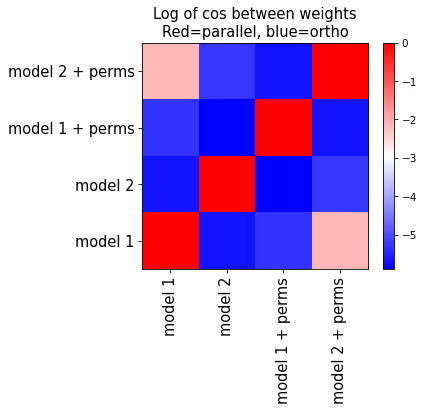

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5,4),dpi=75)
plt.title("Log of cos between weights\nRed=parallel, blue=ortho",fontsize=14)
fig.patch.set_facecolor('white')
plt.imshow(np.log(np.abs(coses_grid)),cmap=plt.cm.bwr,origin="lower")
plt.xticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],rotation = 90,fontsize=14)
plt.yticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],fontsize=14)
plt.colorbar()
plt.show()


## Linear interpolations of weights = test for linear mode connectivity

In [21]:
def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )

### Model 1 -> Model 2

0 0.0 0.11621668
1 0.1111111111111111 0.20105657
2 0.2222222222222222 0.50913835
3 0.3333333333333333 1.0875179
4 0.4444444444444444 1.5609585
5 0.5555555555555556 1.578488
6 0.6666666666666666 1.1245016
7 0.7777777777777777 0.531277
8 0.8888888888888888 0.20696718
9 1.0 0.119093865


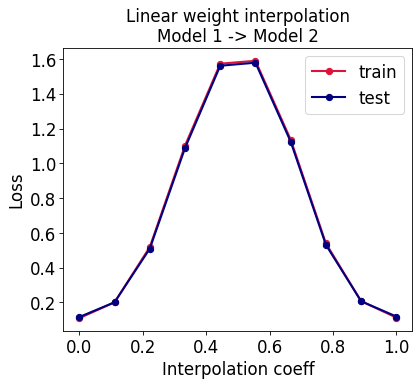

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2
name = "Model 1 -> Model 2"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

plt.figure(figsize=(6,5),dpi=75)
plt.gca().patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.11621668
1 0.1111111111111111 0.16032222
2 0.2222222222222222 0.27335024
3 0.3333333333333333 0.46193737
4 0.4444444444444444 0.6248136
5 0.5555555555555556 0.6250897
6 0.6666666666666666 0.46219495
7 0.7777777777777777 0.27491942
8 0.8888888888888888 0.1630931
9 1.0 0.119093865


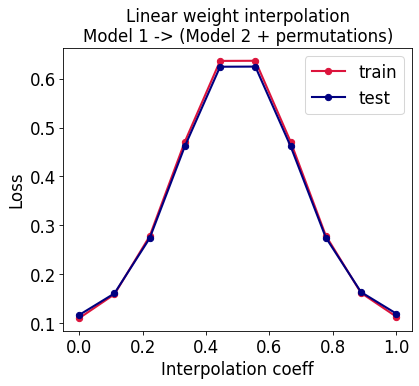

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2_permuted_flat
name = "Model 1 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 2 + permutations

0 0.0 0.119093865
1 0.1111111111111111 0.20247874
2 0.2222222222222222 0.50188345
3 0.3333333333333333 1.0642691
4 0.4444444444444444 1.5205101
5 0.5555555555555556 1.5268157
6 0.6666666666666666 1.0778216
7 0.7777777777777777 0.5093568
8 0.8888888888888888 0.20382199
9 1.0 0.119093865


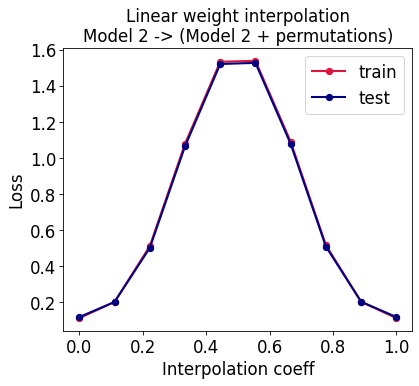

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model2_permuted_flat
name = "Model 2 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 1 + permutations

0 0.0 0.119093865
1 0.1111111111111111 0.20665756
2 0.2222222222222222 0.5315868
3 0.3333333333333333 1.1332749
4 0.4444444444444444 1.5994804
5 0.5555555555555556 1.5851161
6 0.6666666666666666 1.1051615
7 0.7777777777777777 0.5154687
8 0.8888888888888888 0.20222813
9 1.0 0.11621668


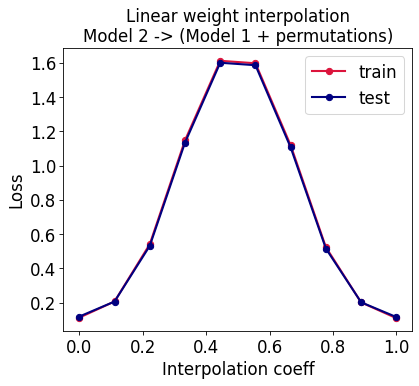

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model1_permuted_flat
name = "Model 2 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.10851285
1 0.1111111111111111 0.18063766
2 0.2222222222222222 0.45246354
3 0.3333333333333333 0.9911569
4 0.4444444444444444 1.4414456
5 0.5555555555555556 1.430885
6 0.6666666666666666 0.97304106
7 0.7777777777777777 0.44453835
8 0.8888888888888888 0.17915209
9 1.0 0.10851285


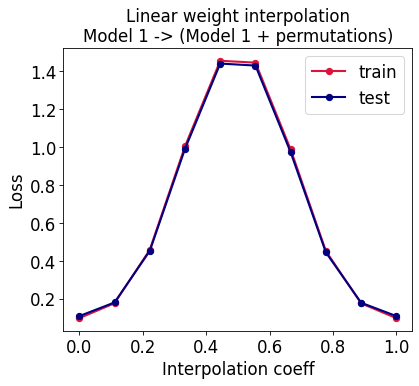

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model1_permuted_flat
name = "Model 1 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Predictions

In [ ]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)
  
  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))
  


In [ ]:
models_to_show = [
    ("model 1", flattened_model1),
    ("model 2", flattened_model2),
    ("model 1 + perms", flattened_model1_permuted_flat),
    ("model 2 + perms", flattened_model2_permuted_flat), 
]

disagreement_grid = np.zeros((len(models_to_show),len(models_to_show)))
for i,(vector_str1, vector1) in enumerate(models_to_show):
  for j,(vector_str2, vector2) in enumerate(models_to_show):
    disagreement_now = compare_predictions(
        unflatten_params(vector1),
        unflatten_params(vector2)
        )
    print(f"Disagreemnt {vector_str1} vs {vector_str2}={disagreement_now}")
    disagreement_grid[i,j] = disagreement_now

Disagreemnt model 1 vs model 1=0
Disagreemnt model 1 vs model 2=1934
Disagreemnt model 1 vs model 1 + perms=1819
Disagreemnt model 1 vs model 2 + perms=1824
Disagreemnt model 2 vs model 1=1934
Disagreemnt model 2 vs model 2=0
Disagreemnt model 2 vs model 1 + perms=1166
Disagreemnt model 2 vs model 2 + perms=1166
Disagreemnt model 1 + perms vs model 1=1819
Disagreemnt model 1 + perms vs model 2=1166
Disagreemnt model 1 + perms vs model 1 + perms=0
Disagreemnt model 1 + perms vs model 2 + perms=105
Disagreemnt model 2 + perms vs model 1=1824
Disagreemnt model 2 + perms vs model 2=1166
Disagreemnt model 2 + perms vs model 1 + perms=105
Disagreemnt model 2 + perms vs model 2 + perms=0


## Loss landscape cuts

In [11]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



In [12]:
# testing it, should get all 0.0
rec = reconstruct(v1, flattened_model1, flattened_model1.keys())
for key in rec.keys():
  print(jnp.max(jnp.abs(flattened_model1[key] - rec[key])))
  assert jnp.max(jnp.abs(flattened_model1[key] - rec[key])) == 0.0

NameError: ignored

### Cut model1 - model2 - (model2+perm)

In [13]:
model1 = flattened_model1
model2 = flattened_model2
model3 = flattened_model2_permuted_flat
cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model1.keys()

v1 = jnp.concatenate([model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([model2[key].reshape([-1]) for key in keys],axis=0)
v3 = jnp.concatenate([model3[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / jnp.sqrt(jnp.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - jnp.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / jnp.sqrt(jnp.sum(basis2**2.0))

scale = jnp.sqrt(jnp.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

acc_grid = np.zeros((len(t1s),len(t2s)))
loss_grid = np.zeros((len(t1s),len(t2s)))
logits_grid = np.zeros((len(t1s),len(t2s), 10000, 10))

for i1,t1 in enumerate(t1s):
  print(f"{i1}/{len(t1s)}")
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model1, keys)
    actest_loss, test_accuracy, logits, onehots = stuff["dataset_predictions"](unflatten_params(reconstructed_flat), test_ds,
                                                                  10_000)
    logits_grid[i1,i2] = np.array(logits[0])
    
    acc_grid[i1,i2] = test_accuracy
    loss_grid[i1,i2] = actest_loss
  
def projection(vector):
  x = jnp.sum((vector - v1)*basis1_normed)/scale
  y = jnp.sum((vector - v1)*basis2_normed)/scale
  return x,y



NameError: ignored

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6,5),dpi=100)
fig.patch.set_facecolor('white')
plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="fuchsia",label="Not connected?!?")

plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)


plt.legend(fontsize=10,ncol=1)

plt.show()

NameError: ignored

<Figure size 600x500 with 0 Axes>

## Combined plot

In [15]:
def get_linear_cut(start_vector, stop_vector, steps=10):

  ts = np.linspace(0.0,1.0,steps)

  test_losses_list = []
  test_accs_list = []
  train_losses_list = []
  train_accs_list = []

  for i,t in enumerate(ts):
    new_params = get_linear_combination(
        (1.0-t), start_vector, t, stop_vector
    )
    test_loss, test_accuracy, *_ = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                    10_000)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_accuracy)

    train_loss, train_accuracy, *_ = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                    60_000)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_accuracy)

  return ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list


NameError: ignored

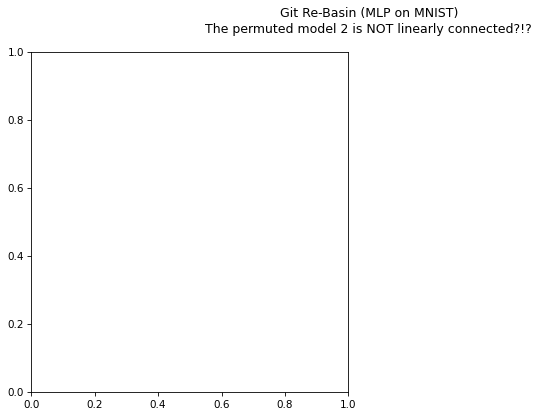

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi = 75)
fig.patch.set_facecolor('white')

plt.suptitle("Git Re-Basin (MLP on MNIST)\nThe permuted model 2 is NOT linearly connected?!?")

plt.subplot(1,2,1)

plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2],[y1,y2],linewidth=2,linestyle="--",color="fuchsia",label="Not connected")
plt.plot([x2,x2p],[y2,y2p],linewidth=2,linestyle="--",color="lime",label="Not connected")
plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="yellow",label="Also\nnot connected?!?")


plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)

plt.legend(fontsize=10,ncol=1)

# getting the data
all_test_losses = []
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
all_test_losses += test_losses_list

lower_lim = np.min(test_losses_list)-(np.max(test_losses_list)-np.min(test_losses_list))*0.1
upper_lim = np.max(test_losses_list)+(np.max(test_losses_list)-np.min(test_losses_list))*0.1


plt.subplot(3,2,2)

ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)

plt.title(f"(Model 2 + perm) -> Model 1",fontsize=12)
plt.plot(ts,train_losses_list,label="train",marker="o",color="yellow",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])


plt.subplot(3,2,4)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
plt.title(f"Model 2 -> (Model 2 + perm)",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="lime",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])

plt.subplot(3,2,6)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
plt.title(f"Model 1 -> Model 2",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="fuchsia",linewidth=2)
plt.ylim([np.min(test_losses_list),np.max(test_losses_list)])
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)

plt.ylim([lower_lim, upper_lim])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Automating the full experiment to sweep over optimizers & LRs

## Wrappers

In [17]:
def get_optima(
  num_epochs = 20,
  batch_size = 500,
  hessian = False,
  fisher_weight = 0.5,
  seed = 12421,
  config_optimizer = "sgd", #"adam"
  learning_rate = 1e-3,
  runs_to_collect = 2,
):


  rng = random.PRNGKey(seed)


  # storing model params after training
  flattened_models_list = []

  for run_i in range(runs_to_collect):

    rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
    rngmix = lambda rng, x: random.fold_in(rng, hash(x))

    model = MLPModel()
    stuff = make_stuff(model)

    print("--------------------------")
    print(f"Starting run {run_i}")


    train_ds, test_ds = load_datasets()
    print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
    print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

    num_train_examples = train_ds["images_u8"].shape[0]
    num_test_examples = test_ds["images_u8"].shape[0]
    assert num_train_examples % batch_size == 0
    print("num_train_examples", num_train_examples)
    print("num_test_examples", num_test_examples)

    if config_optimizer == "sgd":
      # See runs:
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/3blb4uhm
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/174j7umt
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/td02y8gg
      lr_schedule = optax.warmup_cosine_decay_schedule(
          init_value=1e-6,
          peak_value=learning_rate,
          warmup_steps=10,
          # Confusingly, `decay_steps` is actually the total number of steps,
          # including the warmup.
          decay_steps=num_epochs * (num_train_examples // batch_size),
      )
      tx = optax.sgd(lr_schedule, momentum=0.9)
    elif config_optimizer == "adam":
      # See runs:
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/1b1gztfx (trim-fire-575)
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/1hrmw7wr (wild-dream-576)
      tx = optax.adam(learning_rate)
    else:
      # See runs:
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/k4luj7er (faithful-spaceship-579)
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/3ru7xy8c (sage-forest-580)
      tx = optax.adamw(learning_rate, weight_decay=0.25)

    train_state = TrainState.create(
        apply_fn=model.apply,
        params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
        tx=tx,
    )

    for epoch in tqdm(range(num_epochs)):
      infos = []
    
      batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
          (-1, batch_size))
      for i in range(batch_ix.shape[0]):
        p = batch_ix[i, :]
        images_u8 = train_ds["images_u8"][p, :, :, :]
        labels = train_ds["labels"][p]
        if hessian and fisher_weight > 0.0:
          train_state, info = stuff["step_hessian"](train_state, images_u8, labels, fisher_weight)
        else:
          train_state, info = stuff["step"](train_state, images_u8, labels)
      

      # train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
      # train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

      
      # actest_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
      #                                                                 10_000)

      params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                            flatten_params({"params_l2": train_state.params}))
      
      
    # summary
    print("-----------------")
    print(f"Run {run_i} DONE!")
    test_loss, test_accuracy, test_entropy, sparsity = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                  10_000)
    train_loss, train_accuracy, *_ = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                  60_000)
    print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} sparsity={sparsity} test entropy={test_entropy} train loss={train_loss} train accuracy={train_accuracy}")

    flattened_models_list.append(flatten_params(train_state.params))

  return flattened_models_list


In [18]:
def analyze_optima(
  flattened_model1,
  flattened_model2    
):

  permutation_spec = mlp_permutation_spec(3)
  final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                      flattened_model1, flattened_model2)

  # applying the permutation to the second model
  flattened_model1_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model1)
          )
  flattened_model2_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model2)
          )
  
  flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
  flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)


  model1_test_loss, model1_test_accuracy, model1_test_entropy, model1_sparsity = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                    10_000)
  model1_train_loss, model1_train_accuracy, model1_train_entropy, sparsity = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                    60_000)


  model2_test_loss, model2_test_accuracy, model2_test_entropy, sparsity = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                    10_000)
  model2_train_loss, model2_train_accuracy, model2_train_entropy, sparsity = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                    60_000)


  model2_permuted_test_loss, model2_permuted_test_accuracy, *_ = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                    10_000)
  model2_permuted_train_loss, model2_permuted_train_accuracy, *_ = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                    60_000)
  
  # get values in the middle
  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 3)
  bump_1_to_2 = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 3)
  bump_1_to_2perm = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 3)
  bump_2_to_2perm = test_losses_list[1]

  return {
    "model1_test_loss": model1_test_loss,
    "model1_test_entropy": model1_test_entropy,
    "model1_sparsity": model1_sparsity,
    "model2_test_loss": model2_test_loss,
    "model2_test_entropy": model2_test_entropy,
    "model2_permuted_test_loss": model2_permuted_test_loss,
    "bump_1_to_2": bump_1_to_2,
    "bump_1_to_2perm": bump_1_to_2perm,
    "bump_2_to_2perm": bump_2_to_2perm,
  }


## SGD Experimental sweep

In [132]:
reps = 1
LRs = np.exp(np.linspace(np.log(5e-3),np.log(1.0),20))
optimizers = ["sgd"]
epochs = 50
fishers = [0.0,0.5,1.0]

In [119]:
all_results = []
all_flattened_models_tuples = []
skipped_results = []
for fisher in fishers:
    all_flattened_models_tuples = [] # collecting all solutions every
    stored_results_dict = []
    skipped_run = []
    
    for rep in range(reps): # to get error bars
      for i_opt, optimizer in enumerate(optimizers):
        for i_LR, LR in enumerate(LRs):
    
          print("*****************************************")
          print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")
    
          flattened_models_list = get_optima(
              num_epochs = epochs,
              hessian = True,
              fisher_weight = fisher,
              config_optimizer = optimizer,
              learning_rate = LR,
              seed = int(np.random.rand()*100000000),
              )
          
          flattened_model1 = flattened_models_list[0]
          flattened_model2 = flattened_models_list[1]
          try:
            results_dict = analyze_optima(flattened_model1,flattened_model2)
        
            results_dict["LR"] = LR
            results_dict["optimizer"] = optimizer
            results_dict["epochs"] = epochs
              
            stored_results_dict.append(results_dict)
            all_flattened_models_tuples.append(flattened_models_list)
            print(results_dict)
          except ValueError:
            print(f"skipping lr:{LR}")
            skipped_run.append(LR)
              
    
    all_results.append(stored_results_dict)
    all_flattened_models_tuples.append(all_flattened_models_tuples)
    skipped_results.append(skipped_run)

*****************************************
Experiment 0 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10093490034341812 test accuracy=0.971000075340271 sparsity=0.39925897121429443 test entropy=18.502197265625 train loss=0.08969353884458542 train accuracy=0.9775500297546387
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09822974354028702 test accuracy=0.971500039100647 sparsity=0.38962095975875854 test entropy=18.510210037231445 train loss=0.08653775602579117 train accuracy=0.9783999919891357
0/P_0: 95.79923248291016
0/P_1: 50.55078887939453
0/P_2: 25.00613784790039
1/P_0: 8.989181518554688
1/P_2: 0.0
1/P_1: 1.9029083251953125
2/P_2: 3.780029296875
2/P_0: 1.1433181762695312
2/P_1: 0.6132431030273438
3/P_0: 0.9550094604492188
3/P_1: 0.095611572265625
3/P_2: 2.30963134765625
4/P_0: 0.2756500244140625
4/P_1: 0.160003662109375
4/P_2: 0.902496337890625
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.2975921630859375
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.1009349, dtype=float32), 'model1_test_entropy': DeviceArray(18.502197, dtype=float32), 'model1_sparsity': DeviceArray(0.39925897, dtype=float32), 'model2_test_loss': DeviceArray(0.09822974, dtype=float32), 'model2_test_entropy': DeviceArray(18.51021, dtype=float32), 'model2_permuted_test_loss': De

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08346500992774963 test accuracy=0.975100040435791 sparsity=0.3948649764060974 test entropy=18.5078182220459 train loss=0.06831569224596024 train accuracy=0.9837833642959595
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0826340839266777 test accuracy=0.9760000705718994 sparsity=0.4011019468307495 test entropy=18.502304077148438 train loss=0.06779338419437408 train accuracy=0.9839000105857849
0/P_0: 100.7468490600586
0/P_1: 48.22781753540039
0/P_2: 27.744712829589844
1/P_0: 8.657669067382812
1/P_2: 0.0
1/P_1: 2.4884262084960938
2/P_2: 3.9931564331054688
2/P_0: 1.46441650390625
2/P_1: 0.7479248046875
3/P_0: 0.5242996215820312
3/P_1: 0.162567138671875
3/P_2: 1.9041595458984375
4/P_0: 0.09503936767578125
4/P_1: 0.3842620849609375
4/P_2: 0.7063064575195312
5/P_1: 0.04931640625
5/P_2: 0.559722900390625
5/P_0: 0.439849853515625
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.08346501, dtype=float32), 'model1_test_entropy': DeviceArray(18.507818, dtype=float32), 'model1_sparsity': DeviceArray(0.39486498, dtype=float32), 'model2_test_loss': DeviceArray(0.08263408, dtype=float32), 'model2_test_entropy': DeviceArray(18.502304, dtype=float32), 'm

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06937115639448166 test accuracy=0.9793000221252441 sparsity=0.3949434757232666 test entropy=18.496810913085938 train loss=0.04865815117955208 train accuracy=0.9897000193595886
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07368632405996323 test accuracy=0.976900041103363 sparsity=0.40433406829833984 test entropy=18.490272521972656 train loss=0.050333891063928604 train accuracy=0.989050030708313
0/P_0: 102.6672134399414
0/P_1: 52.887786865234375
0/P_2: 26.909576416015625
1/P_0: 7.9690704345703125
1/P_2: 0.0
1/P_1: 2.0763702392578125
2/P_2: 4.085380554199219
2/P_0: 1.0840377807617188
2/P_1: 0.621002197265625
3/P_0: 0.5203170776367188
3/P_1: 0.2230377197265625
3/P_2: 2.1324996948242188
4/P_0: 0.18659210205078125
4/P_1: 0.19989013671875
4/P_2: 0.9349365234375
5/P_1: 0.125732421875
5/P_2: 0.5537948608398438
5/P_0: 0.257781982421875
6/P_1: 0.051910400390625
6/P_2: 0.275360107421875
6/P_0: 0.133636474609375
7/P_2: 0.0
7/P_1: 0.1179046630859375
7/P_0: 0.162628173828125
8/P_1: 0.116119384765625
8/P_0: 0.14453887939453125
8/P_2: 1.0133590698242188
9/P_0: 0.0
9/P_1: 0.125396728515625
9/P_2: 0.0956573486328125
10/P_2: 0.0
10/P_0: 0.0359344482421875
10/P_1: 0.022903442

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06037387251853943 test accuracy=0.9814000725746155 sparsity=0.40343451499938965 test entropy=18.485107421875 train loss=0.03335714712738991 train accuracy=0.994016706943512
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06021963059902191 test accuracy=0.9820000529289246 sparsity=0.4047967791557312 test entropy=18.479360580444336 train loss=0.03327527269721031 train accuracy=0.9940000176429749
0/P_0: 107.65516662597656
0/P_1: 54.537017822265625
0/P_2: 28.892826080322266
1/P_0: 7.2206573486328125
1/P_2: 0.0
1/P_1: 3.0663604736328125
2/P_2: 4.376861572265625
2/P_0: 1.303985595703125
2/P_1: 0.853851318359375
3/P_0: 0.83892822265625
3/P_1: 0.233062744140625
3/P_2: 2.368682861328125
4/P_0: 0.14501953125
4/P_1: 0.4327239990234375
4/P_2: 1.0088119506835938
5/P_1: 0.09381103515625
5/P_2: 0.4605712890625
5/P_0: 0.494354248046875
6/P_1: 0.2906494140625
6/P_2: 0.7379150390625
6/P_0: 0.2434844970703125
7/P_2: 0.0
7/P_1: 0.0166015625
7/P_0: 0.0627899169921875
8/P_1: 0.001556396484375
8/P_0: 0.161834716796875
8/P_2: 0.42310333251953125
9/P_0: 0.0
9/P_1: 0.0584716796875
9/P_2: 0.0530853271484375
10/P_2: 0.0
10/P_0: 0.0069732666015625
10/P_1: 0.1041717529296875
11/P_0: 0

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05683472007513046 test accuracy=0.9824000597000122 sparsity=0.4028586149215698 test entropy=18.464380264282227 train loss=0.020819826051592827 train accuracy=0.9970833659172058
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05538027733564377 test accuracy=0.9819000363349915 sparsity=0.39960920810699463 test entropy=18.468162536621094 train loss=0.02043815329670906 train accuracy=0.9970666766166687
0/P_0: 119.08676147460938
0/P_1: 55.66090393066406
0/P_2: 30.034053802490234
1/P_0: 7.551780700683594
1/P_2: 0.0
1/P_1: 3.869171142578125
2/P_2: 5.387962341308594
2/P_0: 1.7496490478515625
2/P_1: 0.917236328125
3/P_0: 0.663818359375
3/P_1: 0.0938720703125
3/P_2: 2.2156524658203125
4/P_0: 0.18505859375
4/P_1: 0.3079833984375
4/P_2: 0.41828155517578125
5/P_1: 0.0005645751953125
5/P_2: 0.09081268310546875
5/P_0: 0.0872344970703125
6/P_1: 0.0666656494140625
6/P_2: 0.2273712158203125
6/P_0: 0.1932220458984375
7/P_2: 0.0
7/P_1: 0.036468505859375
7/P_0: 0.095733642578125
8/P_1: 0.01251220703125
8/P_0: 0.0126953125
8/P_2: 0.5287017822265625
9/P_0: 0.0
9/P_1: 0.057098388671875
9/P_2: 0.5267181396484375
10/P_2: 0.0
10/P_0: 0.0258331298828125
10/P_1: 0.0189361572265625
11/P_0

100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.053555384278297424 test accuracy=0.9827000498771667 sparsity=0.4091826379299164 test entropy=18.429779052734375 train loss=0.011696887202560902 train accuracy=0.9988000392913818
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05078142136335373 test accuracy=0.9841000437736511 sparsity=0.41603854298591614 test entropy=18.42802619934082 train loss=0.010967593640089035 train accuracy=0.9989500045776367
0/P_0: 126.04498291015625
0/P_1: 60.674835205078125
0/P_2: 33.5255126953125
1/P_0: 5.880645751953125
1/P_2: 0.0
1/P_1: 3.868865966796875
2/P_2: 5.293609619140625
2/P_0: 1.064208984375
2/P_1: 1.0561676025390625
3/P_0: 0.44097900390625
3/P_1: 0.158935546875
3/P_2: 2.6826400756835938
4/P_0: 0.092071533203125
4/P_1: 0.601470947265625
4/P_2: 0.6802520751953125
5/P_1: 0.1095123291015625
5/P_2: 0.6089859008789062
5/P_0: 0.3152313232421875
6/P_1: 0.1388397216796875
6/P_2: 0.48650360107421875
6/P_0: 0.2103271484375
7/P_2: 0.0
7/P_1: 0.0820159912109375
7/P_0: 0.2103424072265625
8/P_1: 0.140472412109375
8/P_0: 0.0113677978515625
8/P_2: 0.7723159790039062
9/P_0: 0.0
9/P_1: 0.04296875
9/P_2: 0.11936187744140625
10/P_2: 0.0
10/P_0: 0.0656890869140625
10/P_1: 0.109649658203125
11

100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05162965506315231 test accuracy=0.9843000173568726 sparsity=0.42747777700424194 test entropy=18.399168014526367 train loss=0.005949686747044325 train accuracy=0.9995666742324829
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05116333067417145 test accuracy=0.984000027179718 sparsity=0.4217861294746399 test entropy=18.37837028503418 train loss=0.006039558909833431 train accuracy=0.9995999932289124
0/P_0: 137.26544189453125
0/P_1: 64.15790557861328
0/P_2: 36.341590881347656
1/P_0: 6.8210906982421875
1/P_2: 0.0
1/P_1: 5.302589416503906
2/P_2: 5.227264404296875
2/P_0: 1.7308349609375
2/P_1: 1.54833984375
3/P_0: 0.201385498046875
3/P_1: 0.26373291015625
3/P_2: 3.4316864013671875
4/P_0: 0.154205322265625
4/P_1: 0.6763153076171875
4/P_2: 1.2619094848632812
5/P_1: 0.41156005859375
5/P_2: 1.1100311279296875
5/P_0: 0.3949737548828125
6/P_1: 0.1749725341796875
6/P_2: 0.36299896240234375
6/P_0: 0.169677734375
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.05162966, dtype=float32), 'model1_test_entropy': DeviceArray(18.399168, dtype=float32), 'model1_sparsity': DeviceArray(0.42747778, dtype=float32), 'model2_test_loss': DeviceArray(0.05116333, dtype=f

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05246662721037865 test accuracy=0.9841000437736511 sparsity=0.4444997012615204 test entropy=18.349912643432617 train loss=0.003025440964847803 train accuracy=0.9998000264167786
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05452807992696762 test accuracy=0.9842000603675842 sparsity=0.43384355306625366 test entropy=18.366487503051758 train loss=0.00286397454328835 train accuracy=0.999833345413208
0/P_0: 150.8394317626953
0/P_1: 68.34474182128906
0/P_2: 37.78749084472656
1/P_0: 6.6059722900390625
1/P_2: 0.0
1/P_1: 6.4200592041015625
2/P_2: 5.948974609375
2/P_0: 1.469635009765625
2/P_1: 2.0645751953125
3/P_0: 0.573974609375
3/P_1: 0.2064208984375
3/P_2: 2.9279708862304688
4/P_0: 0.0999755859375
4/P_1: 0.838531494140625
4/P_2: 1.3614578247070312
5/P_1: 0.2700347900390625
5/P_2: 0.7638626098632812
5/P_0: 0.42523193359375
6/P_1: 0.1693115234375
6/P_2: 0.6792068481445312
6/P_0: 0.2400054931640625
7/P_2: 0.0
7/P_1: 0.1848297119140625
7/P_0: 0.1425933837890625
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.5971298217773438
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.05246663, dtype=float32), 'model1_test_entropy': DeviceArray(18.349913, dtype=float32), 'mode

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.052919674664735794 test accuracy=0.9859000444412231 sparsity=0.45608267188072205 test entropy=18.2972354888916 train loss=0.0015088629443198442 train accuracy=0.9999333620071411
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05443413183093071 test accuracy=0.9843000173568726 sparsity=0.46074673533439636 test entropy=18.292072296142578 train loss=0.0014519905671477318 train accuracy=0.9999666810035706
0/P_0: 174.73095703125
0/P_1: 72.23078918457031
0/P_2: 42.82752990722656
1/P_0: 4.826385498046875
1/P_2: 0.0
1/P_1: 5.789093017578125
2/P_2: 6.2771148681640625
2/P_0: 1.6421966552734375
2/P_1: 1.4718780517578125
3/P_0: 0.3180694580078125
3/P_1: 0.357025146484375
3/P_2: 2.69549560546875
4/P_0: 0.296295166015625
4/P_1: 0.911590576171875
4/P_2: 1.848724365234375
5/P_1: 0.64996337890625
5/P_2: 1.2472457885742188
5/P_0: 0.135772705078125
6/P_1: 0.36566162109375
6/P_2: 0.8741302490234375
6/P_0: 0.226226806640625
7/P_2: 0.0
7/P_1: 0.43609619140625
7/P_0: 0.16876220703125
8/P_1: 0.018341064453125
8/P_0: 0.021820068359375
8/P_2: 0.8428497314453125
9/P_0: 0.0
9/P_1: 0.1111602783203125
9/P_2: 0.29575347900390625
10/P_2: 0.0
10/P_0: 0.016448974609375
10/P_1: 0.14677429199218

100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05867664888501167 test accuracy=0.9848000407218933 sparsity=0.5693333148956299 test entropy=18.052297592163086 train loss=0.001184605760499835 train accuracy=0.9999499917030334
skipping lr:0.06150799653536698
*****************************************
Experiment 9 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05922349542379379 test accuracy=0.9857000708580017 sparsity=0.5916080474853516 test entropy=18.012981414794922 train loss=0.0007282178848981857 train accuracy=0.9999666810035706
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06335604935884476 test accuracy=0.985200047492981 sparsity=0.5296586155891418 test entropy=18.128284454345703 train loss=0.0005066259764134884 train accuracy=0.9999833703041077
0/P_0: 260.02569580078125
0/P_1: 84.10566711425781
0/P_2: 50.60395431518555
1/P_0: 6.760162353515625
1/P_2: 0.0
1/P_1: 6.2200927734375
2/P_2: 6.565605163574219
2/P_0: 1.837615966796875
2/P_1: 1.516448974609375
3/P_0: 0.69720458984375
3/P_1: 0.37750244140625
3/P_2: 3.6506805419921875
4/P_0: 0.141265869140625
4/P_1: 0.187164306640625
4/P_2: 0.4150238037109375
5/P_1: 0.0996246337890625
5/P_2: 0.5801162719726562
5/P_0: 0.325042724609375
6/P_1: 0.22283935546875
6/P_2: 0.7414627075195312
6/P_0: 0.13250732421875
7/P_2: 0.0
7/P_1: 0.1522369384765625
7/P_0: 0.058868408203125
8/P_1: 0.005401611328125
8/P_0: 0.00201416015625
8/P_2: 0.3090667724609375
9/P_0: 0.0
9/P_1: 0.04241943359375
9/P_2: 0.106353759765625
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0546112060546875
11/P_0: 0.016479

100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06010812148451805 test accuracy=0.9863000512123108 sparsity=0.5680660009384155 test entropy=18.00377082824707 train loss=0.00034489078097976744 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.10743487057602956
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.14198815201729706
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=0.9999998807907104 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.1876544850400296
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=0.9999998807907104 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.2480080574000914
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=0.9999998807907104 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=0.9999998807907104 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.32777258972652
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=0.9999998807907104 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.43319104912270484
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=0.9999998807907104 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.5725142703256575
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:0.7566467275589431
*****************************************
Experiment 10 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 sparsity=1.0 test entropy=nan train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 sparsity=0.9999998807907104 test entropy=nan train loss=nan train accuracy=0.09871666878461838
skipping lr:1.0


[2.8964038 2.8972821 2.8987489 2.8981762 2.896807  2.8927445 2.8935275
 2.8907692 2.8889024 2.8876922 2.89069   2.888294  2.8745322 2.8149986
 2.715042  2.5311713 2.5264642]
[2.9161541 2.916061  2.9157436 2.9149866 2.9138918 2.9119732 2.91046
 2.9080458 2.9018745 2.8865047 2.8449848]
[2.9178896 2.9181933 2.9175982 2.9169655 2.9158435 2.9139678 2.9123054
 2.9096248 2.90675   2.8910928]


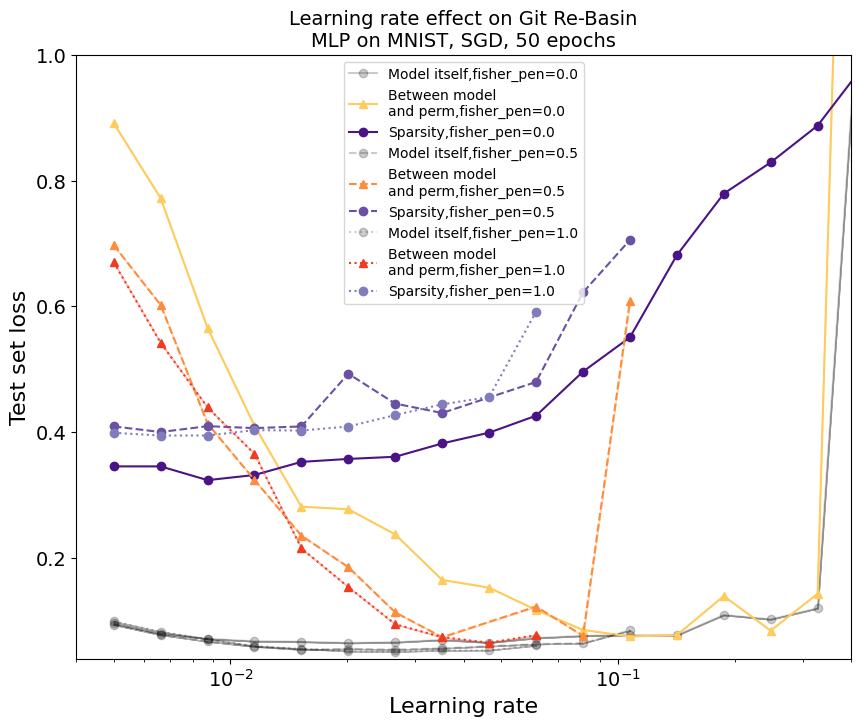

In [135]:
fig = plt.figure(figsize = (10, 8),dpi=100)
fig.patch.set_facecolor('white')
line_styles = ['solid','dashed','dotted']
red_colors = ['#fecc5c','#fd8d3c','#f03b20','#bd0026']
green_colors = ["#f2f0f7","#dadaeb","#bcbddc","#9e9ac8","#807dba","#6a51a3","#4a1486"]
green_colors.reverse()
plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, SGD, {epochs} epochs",fontsize=14)
for i, stored_results_dict in enumerate(all_results):
  
  standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
  permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
  model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
  model1_entropy = np.array([d["model1_test_entropy"] for d in stored_results_dict])
  model1_sparsity = np.array([d["model1_sparsity"] for d in stored_results_dict])
  model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])
  model2_entropy = np.array([d["model2_test_entropy"] for d in stored_results_dict])
  
  standard_bumps = np.reshape(standard_bumps,[reps,-1])
  permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
  model1_loss = np.reshape(model1_loss,[reps,-1])
  model2_loss = np.reshape(model2_loss,[reps,-1])
  model1_entropy = np.reshape(model1_entropy,[reps,-1])
  model1_sparsity = np.reshape(model1_sparsity,[reps,-1])
  model2_entropy = np.reshape(model2_entropy,[reps,-1])
  
  def get_mean_and_error(vals):
    return np.mean(vals,axis=0), np.std(vals,axis=0)
  
  mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
  mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
  mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
  mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)
  mean_entropy, error_entropy = get_mean_and_error(model1_entropy)
  mean_sparsity, error_sparsity = get_mean_and_error(model1_sparsity)
  skip_lrs = skipped_results[i]
  LRs_ = [lr for lr in LRs if lr not in skip_lrs]
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",alpha=0.2,color="black",linestyle=line_styles[i],label=f"Model itself,fisher_pen={fishers[i]}")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],
                   (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                   (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                   color=line.get_color(),
                   alpha=0.3
                   )
  
  #line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",linestyle=line_styles[i],label="Between models")
  #plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",linestyle=line_styles[i],color=red_colors[i],label=f"Between model\nand perm,fisher_pen={fishers[i]}")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())
  print(np.log(mean_entropy))
  # line, = plt.semilogx(LRs_[:len(mean_standard_bumps)], np.log(mean_entropy) - 2,marker="o",alpha=0.2,color="green",linestyle=line_styles[i],label="Entropy")
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)], mean_sparsity,marker="o",alpha=1.0,color=green_colors[i],linestyle=line_styles[i],label=f"Sparsity,fisher_pen={fishers[i]}")
  
  from matplotlib.patches import Rectangle
  
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((LRs[-3], 0.0),0.1,2.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)
plt.ylim([0.04, 1.0])
plt.xlim([4e-3, 0.4])
plt.legend(fontsize=10)
plt.show()
  

## Adam Experimental sweep

In [19]:
reps = 1
LRs = np.exp(np.linspace(np.log(0.5*1e-4),np.log(0.01),20))
optimizers = ["adam"]
epochs = 50
fishers = [0.0, 0.5, 1.0]

In [22]:
all_results_adam = []
all_flattened_models_adam = []
for fisher in fishers:
    all_flattened_models_tuples = [] # collecting all solutions every
    stored_results_dict = []
    
    for rep in range(reps): # to get error bars
      for i_opt, optimizer in enumerate(optimizers):
        for i_LR, LR in enumerate(LRs):
    
          print("*****************************************")
          print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")
    
          flattened_models_list = get_optima(
              num_epochs = epochs,
              hessian = True,
              fisher_weight = fisher,
              config_optimizer = optimizer,
              learning_rate = LR,
              seed = int(np.random.rand()*100000000),
              )
          
          flattened_model1 = flattened_models_list[0]
          flattened_model2 = flattened_models_list[1]
          results_dict = analyze_optima(flattened_model1,flattened_model2)
    
          results_dict["LR"] = LR
          results_dict["optimizer"] = optimizer
          results_dict["epochs"] = epochs
          
          stored_results_dict.append(results_dict)
          all_flattened_models_tuples.append(flattened_models_list)
    
          print(results_dict)
    all_results_adam.append(stored_results_dict)
    all_flattened_models_adam.append(all_flattened_models_tuples)

*****************************************
Experiment 0 / 20
--------------------------
Starting run 0
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06500332802534103 test accuracy=0.980400025844574 sparsity=0.20440371334552765 test entropy=17.717998504638672 train loss=0.009847428649663925 train accuracy=0.9987500309944153
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06894213706254959 test accuracy=0.9792000651359558 sparsity=0.1994147151708603 test entropy=17.78194808959961 train loss=0.008586863055825233 train accuracy=0.9990000128746033
0/P_0: 112.32108306884766
0/P_1: 58.75187683105469
0/P_2: 31.940902709960938
1/P_0: 11.288238525390625
1/P_2: 0.0
1/P_1: 4.1218719482421875
2/P_2: 7.596710205078125
2/P_0: 3.0794830322265625
2/P_1: 2.3603363037109375
3/P_0: 1.6382598876953125
3/P_1: 0.49566650390625
3/P_2: 5.277099609375
4/P_0: 0.6443939208984375
4/P_1: 0.3749237060546875
4/P_2: 1.8405303955078125
5/P_1: 0.2925872802734375
5/P_2: 1.25225830078125
5/P_0: 0.4964599609375
6/P_1: 0.318023681640625
6/P_2: 1.4780120849609375
6/P_0: 0.5055389404296875
7/P_2: 0.0
7/P_1: 0.0941162109375
7/P_0: 0.3202362060546875
8/P_1: 0.0932464599609375
8/P_0: 0.072601318359375
8/P_2: 1.0492477416992188
9/P_0: 0.0
9/P_1: 0.2201995849609375
9/P_2: 1.1160049438476562
10/P_2: 0.0
10/P_0: 0.3601226806640625
10/P_1: 0.1391601562

100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07192645221948624 test accuracy=0.9807000756263733 sparsity=0.19729577004909515 test entropy=17.755727767944336 train loss=0.00287486519664526 train accuracy=0.9998999834060669
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07426513731479645 test accuracy=0.9798000454902649 sparsity=0.21032357215881348 test entropy=17.674638748168945 train loss=0.002857533050701022 train accuracy=0.999916672706604
0/P_0: 111.20179748535156
0/P_1: 61.202842712402344
0/P_2: 37.442623138427734
1/P_0: 14.646438598632812
1/P_2: 0.0
1/P_1: 6.01934814453125
2/P_2: 9.146644592285156
2/P_0: 3.637939453125
2/P_1: 3.8357086181640625
3/P_0: 2.880096435546875
3/P_1: 1.106842041015625
3/P_2: 8.363548278808594
4/P_0: 1.224456787109375
4/P_1: 1.0406036376953125
4/P_2: 3.6333236694335938
5/P_1: 0.2929840087890625
5/P_2: 1.1268844604492188
5/P_0: 1.6869964599609375
6/P_1: 0.664459228515625
6/P_2: 2.2601470947265625
6/P_0: 0.95147705078125
7/P_2: 0.0
7/P_1: 0.5283050537109375
7/P_0: 0.6003570556640625
8/P_1: 0.0988311767578125
8/P_0: 0.1573638916015625
8/P_2: 1.0511245727539062
9/P_0: 0.0
9/P_1: 0.396942138671875
9/P_2: 0.6385879516601562
10/P_2: 0.0
10/P_0: 0.306243896484375
10/P_1: 0.0159301

100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07697948813438416 test accuracy=0.9797000288963318 sparsity=0.21155059337615967 test entropy=17.55739402770996 train loss=0.0012117138830944896 train accuracy=0.9999666810035706
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07853242754936218 test accuracy=0.9814000725746155 sparsity=0.21437403559684753 test entropy=17.486557006835938 train loss=0.0012368393363431096 train accuracy=1.0
0/P_0: 114.4576644897461
0/P_1: 66.60800170898438
0/P_2: 41.76160430908203
1/P_0: 16.037887573242188
1/P_2: 0.0
1/P_1: 10.466506958007812
2/P_2: 12.481803894042969
2/P_0: 5.103851318359375
2/P_1: 3.08349609375
3/P_0: 1.8585662841796875
3/P_1: 0.9334564208984375
3/P_2: 6.759063720703125
4/P_0: 0.8544158935546875
4/P_1: 1.1171112060546875
4/P_2: 2.7300643920898438
5/P_1: 0.898468017578125
5/P_2: 2.7075881958007812
5/P_0: 1.255615234375
6/P_1: 0.76708984375
6/P_2: 1.148651123046875
6/P_0: 0.7566375732421875
7/P_2: 0.0
7/P_1: 0.3702850341796875
7/P_0: 0.641357421875
8/P_1: 0.277618408203125
8/P_0: 0.1400909423828125
8/P_2: 1.002838134765625
9/P_0: 0.0
9/P_1: 0.223358154296875
9/P_2: 0.1071014404296875
10/P_2: 0.0
10/P_0: 0.10906982421875
10/P_1: 0.1835479736328125
11/P_0: 0.2133331

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08630294352769852 test accuracy=0.9816000461578369 sparsity=0.20954473316669464 test entropy=17.427574157714844 train loss=0.00037166825495660305 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08783040195703506 test accuracy=0.980400025844574 sparsity=0.22217272222042084 test entropy=17.279958724975586 train loss=0.0004146081337239593 train accuracy=1.0
0/P_0: 120.49117279052734
0/P_1: 73.30587768554688
0/P_2: 42.03733825683594
1/P_0: 14.27789306640625
1/P_2: 0.0
1/P_1: 11.0380859375
2/P_2: 13.623291015625
2/P_0: 5.860595703125
2/P_1: 4.4644317626953125
3/P_0: 2.9519500732421875
3/P_1: 0.9067230224609375
3/P_2: 9.044692993164062
4/P_0: 1.026123046875
4/P_1: 1.1897735595703125
4/P_2: 2.1674957275390625
5/P_1: 0.4946441650390625
5/P_2: 1.4652099609375
5/P_0: 1.6608734130859375
6/P_1: 0.277069091796875
6/P_2: 1.1396484375
6/P_0: 0.457977294921875
7/P_2: 0.0
7/P_1: 0.3262481689453125
7/P_0: 0.561920166015625
8/P_1: 0.245513916015625
8/P_0: 0.2759552001953125
8/P_2: 1.2201690673828125
9/P_0: 0.0
9/P_1: 0.369140625
9/P_2: 1.03875732421875
10/P_2: 0.0
10/P_0: 0.15838623046875
10/P_1: 0.1778564453125
11/P_0: 0.1812286376953125
11/P_2: 

100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.094625324010849 test accuracy=0.9820000529289246 sparsity=0.21888059377670288 test entropy=17.17445182800293 train loss=0.00017101627599913627 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0922507643699646 test accuracy=0.9818000197410583 sparsity=0.218317449092865 test entropy=17.232847213745117 train loss=0.00017429739818908274 train accuracy=1.0
0/P_0: 122.4164047241211
0/P_1: 72.41874694824219
0/P_2: 49.450096130371094
1/P_0: 15.069091796875
1/P_2: 0.0
1/P_1: 14.902984619140625
2/P_2: 14.27105712890625
2/P_0: 5.94580078125
2/P_1: 5.5764923095703125
3/P_0: 3.606964111328125
3/P_1: 1.671844482421875
3/P_2: 9.892654418945312
4/P_0: 1.732208251953125
4/P_1: 2.003387451171875
4/P_2: 2.614837646484375
5/P_1: 0.7216339111328125
5/P_2: 1.17364501953125
5/P_0: 1.38946533203125
6/P_1: 0.4621429443359375
6/P_2: 1.0871734619140625
6/P_0: 0.43865966796875
7/P_2: 0.0
7/P_1: 0.26654052734375
7/P_0: 0.3895263671875
8/P_1: 0.1460113525390625
8/P_0: 0.47509765625
8/P_2: 1.629119873046875
9/P_0: 0.0
9/P_1: 0.160064697265625
9/P_2: 0.5146331787109375
10/P_2: 0.0
10/P_0: 0.2736053466796875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'m

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09598156064748764 test accuracy=0.9813000559806824 sparsity=0.2360903024673462 test entropy=17.11197853088379 train loss=8.094768418231979e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09644335508346558 test accuracy=0.9818000197410583 sparsity=0.23411035537719727 test entropy=17.155567169189453 train loss=8.384579268749803e-05 train accuracy=1.0
0/P_0: 128.70040893554688
0/P_1: 81.06039428710938
0/P_2: 50.10326385498047
1/P_0: 15.303619384765625
1/P_2: 0.0
1/P_1: 17.49603271484375
2/P_2: 18.273834228515625
2/P_0: 6.88482666015625
2/P_1: 8.842819213867188
3/P_0: 2.88873291015625
3/P_1: 1.18499755859375
3/P_2: 10.9857177734375
4/P_0: 0.7406005859375
4/P_1: 2.030731201171875
4/P_2: 3.026702880859375
5/P_1: 0.5836639404296875
5/P_2: 1.43524169921875
5/P_0: 2.059967041015625
6/P_1: 0.204315185546875
6/P_2: 0.987823486328125
6/P_0: 0.4729766845703125
7/P_2: 0.0
7/P_1: 0.296478271484375
7/P_0: 0.55206298828125
8/P_1: 0.0982666015625
8/P_0: 0.1308441162109375
8/P_2: 1.171234130859375
9/P_0: 0.0
9/P_1: 0.07562255859375
9/P_2: 0.299835205078125
10/P_2: 0.0
10/P_0: 0.183685302734375
10/P_1: 0.046844482421875
11/P_0: 0.08374023437

100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09834319353103638 test accuracy=0.98170006275177 sparsity=0.24129310250282288 test entropy=17.087743759155273 train loss=4.311104567022994e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09176988154649734 test accuracy=0.982200026512146 sparsity=0.291553795337677 test entropy=17.359350204467773 train loss=6.436974217649549e-05 train accuracy=1.0
0/P_0: 133.582275390625
0/P_1: 82.3213119506836
0/P_2: 52.972755432128906
1/P_0: 17.592086791992188
1/P_2: 0.0
1/P_1: 17.99322509765625
2/P_2: 18.223953247070312
2/P_0: 6.56231689453125
2/P_1: 7.32257080078125
3/P_0: 3.3519744873046875
3/P_1: 1.1517333984375
3/P_2: 10.114791870117188
4/P_0: 1.2189178466796875
4/P_1: 1.9806671142578125
4/P_2: 3.6739654541015625
5/P_1: 0.606414794921875
5/P_2: 1.568450927734375
5/P_0: 2.2662353515625
6/P_1: 0.605865478515625
6/P_2: 1.591888427734375
6/P_0: 0.534881591796875
7/P_2: 0.0
7/P_1: 0.460113525390625
7/P_0: 0.3707275390625
8/P_1: 0.15631103515625
8/P_0: 0.27032470703125
8/P_2: 1.1445159912109375
9/P_0: 0.0
9/P_1: 0.79034423828125
9/P_2: 0.91314697265625
10/P_2: 0.0
10/P_0: 0.4067535400390625
10/P_1: 0.2962646484375
11/P_0: 0.14691162109375


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09538836777210236 test accuracy=0.9824000597000122 sparsity=0.31934165954589844 test entropy=16.15510368347168 train loss=2.2322563381749205e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09766770154237747 test accuracy=0.9825000762939453 sparsity=0.27282246947288513 test entropy=16.49561882019043 train loss=2.4111446691676974e-05 train accuracy=1.0
0/P_0: 146.79640197753906
0/P_1: 96.20709991455078
0/P_2: 60.5960693359375
1/P_0: 15.950393676757812
1/P_2: 0.0
1/P_1: 24.362518310546875
2/P_2: 19.59735107421875
2/P_0: 6.8889312744140625
2/P_1: 5.8782958984375
3/P_0: 3.3001708984375
3/P_1: 1.611053466796875
3/P_2: 7.47003173828125
4/P_0: 1.311309814453125
4/P_1: 1.747406005859375
4/P_2: 2.212066650390625
5/P_1: 0.258331298828125
5/P_2: 0.5110015869140625
5/P_0: 1.02484130859375
6/P_1: 0.12371826171875
6/P_2: 0.783538818359375
6/P_0: 0.494598388671875
7/P_2: 0.0
7/P_1: 0.2884521484375
7/P_0: 0.2489166259765625
8/P_1: 0.169708251953125
8/P_0: 0.1505126953125
8/P_2: 1.29571533203125
9/P_0: 0.0
9/P_1: 0.21832275390625
9/P_2: 0.3594818115234375
10/P_2: 0.0
10/P_0: 0.0413360595703125
10/P_1: 0.283905029296875
11/P_0: 0.286392211914

100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09801436215639114 test accuracy=0.9826000332832336 sparsity=0.38330578804016113 test entropy=16.95989990234375 train loss=1.1550821909622755e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09540902823209763 test accuracy=0.9842000603675842 sparsity=0.3497256636619568 test entropy=16.921907424926758 train loss=1.0363430192228407e-05 train accuracy=1.0
0/P_0: 184.23667907714844
0/P_1: 119.64022827148438
0/P_2: 74.17229461669922
1/P_0: 15.448257446289062
1/P_2: 0.0
1/P_1: 21.659393310546875
2/P_2: 18.2603759765625
2/P_0: 5.2125244140625
2/P_1: 5.120452880859375
3/P_0: 1.721832275390625
3/P_1: 0.756622314453125
3/P_2: 8.377197265625
4/P_0: 0.5771484375
4/P_1: 1.466766357421875
4/P_2: 2.0746307373046875
5/P_1: 0.398590087890625
5/P_2: 0.87432861328125
5/P_0: 0.74383544921875
6/P_1: 0.211090087890625
6/P_2: 0.3901214599609375
6/P_0: 0.108184814453125
7/P_2: 0.0
7/P_1: 0.2554931640625
7/P_0: 0.19110107421875
8/P_1: 0.031494140625
8/P_0: 0.02197265625
8/P_2: 0.5112457275390625
9/P_0: 0.0
9/P_1: 0.201202392578125
9/P_2: 0.6674957275390625
10/P_2: 0.0
10/P_0: 0.370361328125
10/P_1: 0.091339111328125
11/P_0: 0.022247314453125
11/P_2: 

100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09657416492700577 test accuracy=0.9850000739097595 sparsity=0.5010149478912354 test entropy=16.8781795501709 train loss=6.141501671663718e-06 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09853566437959671 test accuracy=0.9845000505447388 sparsity=0.36336544156074524 test entropy=16.184282302856445 train loss=5.75175818084972e-06 train accuracy=1.0
0/P_0: 223.3204803466797
0/P_1: 135.83453369140625
0/P_2: 88.87088775634766
1/P_0: 16.105133056640625
1/P_2: 0.0
1/P_1: 27.346405029296875
2/P_2: 21.59637451171875
2/P_0: 5.27215576171875
2/P_1: 5.38336181640625
3/P_0: 1.66351318359375
3/P_1: 1.69439697265625
3/P_2: 5.5121307373046875
4/P_0: 0.499786376953125
4/P_1: 1.14111328125
4/P_2: 2.3331298828125
5/P_1: 0.400787353515625
5/P_2: 0.592681884765625
5/P_0: 0.95001220703125
6/P_1: 0.203643798828125
6/P_2: 0.550079345703125
6/P_0: 0.041259765625
7/P_2: 0.0
7/P_1: 0.153472900390625
7/P_0: 0.175811767578125
8/P_1: 0.01495361328125
8/P_0: 0.1055908203125
8/P_2: 0.5831451416015625
9/P_0: 0.0
9/P_1: 0.05126953125
9/P_2: 0.401763916015625
10/P_2: 0.0
10/P_0: 0.049957275390625
10/P_1: 0.018157958984375
11/P_0: 0.008331298828125
11/P_2:

100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0934227854013443 test accuracy=0.9850000739097595 sparsity=0.6868433952331543 test entropy=16.624412536621094 train loss=0.00021767539146821946 train accuracy=0.9999333620071411
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10479264706373215 test accuracy=0.9832000732421875 sparsity=0.6821711659431458 test entropy=16.522661209106445 train loss=0.000131610591779463 train accuracy=0.9999666810035706
0/P_0: 466.5643310546875
0/P_1: 269.59393310546875
0/P_2: 163.69821166992188
1/P_0: 16.064208984375
1/P_2: 0.0
1/P_1: 56.4727783203125
2/P_2: 24.774688720703125
2/P_0: 5.2708740234375
2/P_1: 3.9437255859375
3/P_0: 0.93206787109375
3/P_1: 0.8756103515625
3/P_2: 5.482818603515625
4/P_0: 0.3878173828125
4/P_1: 0.9376220703125
4/P_2: 1.21832275390625
5/P_1: 0.059814453125
5/P_2: 0.221038818359375
5/P_0: 0.1998291015625
6/P_1: 0.06103515625
6/P_2: 1.182373046875
6/P_0: 0.09625244140625
7/P_2: 0.0
7/P_1: 0.2098388671875
7/P_0: 0.10693359375
8/P_1: 0.04541015625
8/P_0: 0.0762939453125
8/P_2: 0.51873779296875
9/P_0: 0.0
9/P_1: 0.10357666015625
9/P_2: 0.14501953125
10/P_2: 0.0
10/P_0: 0.00323486328125
10/P_1: 0.18798828125
11/P_0: 0.16943359375
11/P_2: 0.37237548828125
11/P

100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08498351275920868 test accuracy=0.985200047492981 sparsity=0.738601565361023 test entropy=15.720122337341309 train loss=0.0012113633565604687 train accuracy=0.9997333288192749
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09071662276983261 test accuracy=0.9846000671386719 sparsity=0.7510638236999512 test entropy=15.454769134521484 train loss=0.0006888361531309783 train accuracy=0.9997667074203491
0/P_0: 664.5205688476562
0/P_1: 341.37811279296875
0/P_2: 210.70465087890625
1/P_0: 30.33782958984375
1/P_2: 0.0
1/P_1: 61.14947509765625
2/P_2: 27.78985595703125
2/P_0: 4.2122802734375
2/P_1: 6.33929443359375
3/P_0: 1.169677734375
3/P_1: 0.428466796875
3/P_2: 6.355621337890625
4/P_0: 0.4044189453125
4/P_1: 1.0955810546875
4/P_2: 1.605072021484375
5/P_1: 0.05224609375
5/P_2: 0.309906005859375
5/P_0: 0.009521484375
6/P_1: 0.0616455078125
6/P_2: 0.25750732421875
6/P_0: 0.025146484375
7/P_2: 0.0
7/P_1: 0.0455322265625
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.154144287109375
9/P_0: 0.0
9/P_1: 0.1478271484375
9/P_2: 0.408843994140625
10/P_2: 0.0
10/P_0: 0.021728515625
10/P_1: 0.17498779296875
11/P_0: 0.00830078125
11/P_2: 0.17431640625
11/P_1: 0.0374755859375
12/P_0: 

100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1024053543806076 test accuracy=0.9828000664710999 sparsity=0.797423779964447 test entropy=13.261275291442871 train loss=0.0012087939539924264 train accuracy=0.9995999932289124
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.12783171236515045 test accuracy=0.9803000688552856 sparsity=0.7963062524795532 test entropy=13.673722267150879 train loss=0.01197255589067936 train accuracy=0.9971166849136353
0/P_0: 1062.9197998046875
0/P_1: 490.3581237792969
0/P_2: 280.09619140625
1/P_0: 26.47412109375
1/P_2: 0.0
1/P_1: 72.45281982421875
2/P_2: 34.3221435546875
2/P_0: 6.8291015625
2/P_1: 7.33837890625
3/P_0: 0.961669921875
3/P_1: 0.89111328125
3/P_2: 5.214691162109375
4/P_0: 0.1439208984375
4/P_1: 0.52783203125
4/P_2: 1.3192138671875
5/P_1: 0.2314453125
5/P_2: 0.287261962890625
5/P_0: 0.1285400390625
6/P_1: 0.075439453125
6/P_2: 0.24267578125
6/P_0: 0.02294921875
7/P_2: 0.0
7/P_1: 0.120361328125
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.4620361328125
9/P_0: 0.0
9/P_1: 0.206787109375
9/P_2: 0.54730224609375
10/P_2: 0.0
10/P_0: 0.0556640625
10/P_1: 0.0665283203125
11/P_0: 0.0
11/P_2: 0.392669677734375
11/P_1: 0.101806640625
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.07650756835937

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10405471920967102 test accuracy=0.9813000559806824 sparsity=0.850916862487793 test entropy=11.054237365722656 train loss=0.0031444523483514786 train accuracy=0.9989833235740662
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09647069871425629 test accuracy=0.9847000241279602 sparsity=0.8354454040527344 test entropy=10.713467597961426 train loss=0.001238259021192789 train accuracy=0.9997166991233826
0/P_0: 1709.059814453125
0/P_1: 700.8779296875
0/P_2: 359.1361083984375
1/P_0: 23.1767578125
1/P_2: 0.0
1/P_1: 79.11279296875
2/P_2: 47.2855224609375
2/P_0: 6.09228515625
2/P_1: 7.5284423828125
3/P_0: 0.5146484375
3/P_1: 0.4041748046875
3/P_2: 7.30657958984375
4/P_0: 0.568359375
4/P_1: 2.6329345703125
4/P_2: 3.6419677734375
5/P_1: 0.6807861328125
5/P_2: 1.2926025390625
5/P_0: 0.639892578125
6/P_1: 0.3236083984375
6/P_2: 0.393798828125
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0203857421875
7/P_0: 0.09326171875
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.9349365234375
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.10405472, dtype=float32), 'model1_test_entropy': DeviceArray(11.054237, dtype=float32), 'model1_sparsity': DeviceArray(0.85091686, dtype=float32), 'model2_te

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1365031749010086 test accuracy=0.9796000719070435 sparsity=0.8809483051300049 test entropy=7.137994289398193 train loss=0.007353074382990599 train accuracy=0.9979833364486694
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1193564236164093 test accuracy=0.9824000597000122 sparsity=0.8759110569953918 test entropy=8.080788612365723 train loss=0.0020894822664558887 train accuracy=0.9993333220481873
0/P_0: 2756.089599609375
0/P_1: 1032.934814453125
0/P_2: 446.61126708984375
1/P_0: 34.51611328125
1/P_2: 0.0
1/P_1: 79.722900390625
2/P_2: 61.349609375
2/P_0: 8.6806640625
2/P_1: 12.589599609375
3/P_0: 1.18896484375
3/P_1: 0.6328125
3/P_2: 15.83123779296875
4/P_0: 0.3193359375
4/P_1: 1.180908203125
4/P_2: 3.4464111328125
5/P_1: 0.345703125
5/P_2: 2.4927978515625
5/P_0: 0.658203125
6/P_1: 0.533203125
6/P_2: 1.21417236328125
6/P_0: 0.64453125
7/P_2: 0.0
7/P_1: 0.724609375
7/P_0: 0.1142578125
8/P_1: 0.011474609375
8/P_0: 0.0
8/P_2: 1.0545654296875
9/P_0: 0.0
9/P_1: 0.0615234375
9/P_2: 0.5838623046875
10/P_2: 0.0
10/P_0: 0.0078125
10/P_1: 0.060546875
11/P_0: 0.01171875
11/P_2: 0.126708984375
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'model1_test_loss': DeviceArra

100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.14270931482315063 test accuracy=0.9816000461578369 sparsity=0.9104924201965332 test entropy=5.2107744216918945 train loss=0.006411578506231308 train accuracy=0.9981833696365356
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.12121714651584625 test accuracy=0.982200026512146 sparsity=0.9136309623718262 test entropy=4.663033962249756 train loss=0.01074809767305851 train accuracy=0.9974333643913269
0/P_0: 4354.521484375
0/P_1: 1649.5166015625
0/P_2: 578.937744140625
1/P_0: 46.91650390625
1/P_2: 0.0
1/P_1: 85.075439453125
2/P_2: 62.3316650390625
2/P_0: 9.0009765625
2/P_1: 10.118408203125
3/P_0: 1.1982421875
3/P_1: 0.73583984375
3/P_2: 15.8519287109375
4/P_0: 0.2646484375
4/P_1: 1.87158203125
4/P_2: 4.53173828125
5/P_1: 0.53466796875
5/P_2: 0.802001953125
5/P_0: 0.310546875
6/P_1: 0.029541015625
6/P_2: 0.383056640625
6/P_0: 0.01025390625
7/P_2: 0.0
7/P_1: 0.10205078125
7/P_0: 0.0263671875
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.673828125
9/P_0: 0.0
9/P_1: 0.3642578125
9/P_2: 0.7000732421875
10/P_2: 0.0
10/P_0: 0.021484375
10/P_1: 0.474853515625
11/P_0: 0.001953125
11/P_2: 0.90576171875
11/P_1: 0.02587890625
12/P_0: 0.02587890625
12/P_1: 0.052490234375
12/P_2: 1.12756347656

100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1389390528202057 test accuracy=0.9807000756263733 sparsity=0.9347798824310303 test entropy=3.06805419921875 train loss=0.008680600672960281 train accuracy=0.998283326625824
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.13744455575942993 test accuracy=0.9813000559806824 sparsity=0.9354465007781982 test entropy=2.8805699348449707 train loss=0.0070147146470844746 train accuracy=0.9981499910354614
0/P_0: 6728.66552734375
0/P_1: 2377.297607421875
0/P_2: 752.1251220703125
1/P_0: 40.306640625
1/P_2: 0.0
1/P_1: 74.00634765625
2/P_2: 76.64501953125
2/P_0: 6.9912109375
2/P_1: 14.4912109375
3/P_0: 2.529296875
3/P_1: 1.61474609375
3/P_2: 28.5361328125
4/P_0: 0.689453125
4/P_1: 4.259765625
4/P_2: 6.739990234375
5/P_1: 2.34521484375
5/P_2: 9.58544921875
5/P_0: 3.5029296875
6/P_1: 1.1806640625
6/P_2: 5.64111328125
6/P_0: 0.6572265625
7/P_2: 0.0
7/P_1: 0.4716796875
7/P_0: 0.26953125
8/P_1: 0.08740234375
8/P_0: 0.072265625
8/P_2: 2.40283203125
9/P_0: 0.0
9/P_1: 2.21923828125
9/P_2: 4.94287109375
10/P_2: 0.0
10/P_0: 1.125
10/P_1: 1.244140625
11/P_0: 0.32421875
11/P_2: 1.82275390625
11/P_1: 0.376953125
12/P_0: 0.193359375
12/P_1: 0.0
12/P_2: 1.23974609375
13/P_2: 0.0
13/P

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.17652283608913422 test accuracy=0.9782000184059143 sparsity=0.9472087025642395 test entropy=1.826006293296814 train loss=0.010438789613544941 train accuracy=0.9976666569709778
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.14901767671108246 test accuracy=0.98170006275177 sparsity=0.9483605623245239 test entropy=1.797742247581482 train loss=0.00447811046615243 train accuracy=0.9988333582878113
0/P_0: 9605.95703125
0/P_1: 3194.635986328125
0/P_2: 871.18603515625
1/P_0: 55.9228515625
1/P_2: 0.0
1/P_1: 66.66796875
2/P_2: 63.122314453125
2/P_0: 8.2724609375
2/P_1: 13.90673828125
3/P_0: 2.1181640625
3/P_1: 0.0048828125
3/P_2: 12.594482421875
4/P_0: 0.0380859375
4/P_1: 8.7333984375
4/P_2: 13.47998046875
5/P_1: 3.759765625
5/P_2: 7.875244140625
5/P_0: 4.5009765625
6/P_1: 6.8447265625
6/P_2: 16.23046875
6/P_0: 1.67578125
7/P_2: 0.0
7/P_1: 3.2900390625
7/P_0: 0.9765625
8/P_1: 0.0380859375
8/P_0: 0.0283203125
8/P_2: 5.89697265625
9/P_0: 0.0
9/P_1: 2.095703125
9/P_2: 1.9462890625
10/P_2: 0.0
10/P_0: 0.8720703125
10/P_1: 0.68408203125
11/P_0: 0.619140625
11/P_2: 1.203125
11/P_1: 0.22265625
12/P_0: 0.21875
12/P_1: 0.02001953125
12/P_2: 1.07421875
13/P_2: 0.0
13/P_1: 0.49

100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.20182152092456818 test accuracy=0.9796000719070435 sparsity=0.9620391130447388 test entropy=1.149766445159912 train loss=0.010404929518699646 train accuracy=0.9976333379745483
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.18173402547836304 test accuracy=0.9796000719070435 sparsity=0.9626490473747253 test entropy=1.2135038375854492 train loss=0.0018720363732427359 train accuracy=0.999500036239624
0/P_0: 9528.02734375
0/P_1: 3955.4580078125
0/P_2: 1110.673583984375
1/P_0: 48.03515625
1/P_2: 0.0
1/P_1: 67.51220703125
2/P_2: 53.88427734375
2/P_0: 8.650390625
2/P_1: 14.76416015625
3/P_0: 5.42578125
3/P_1: 0.037109375
3/P_2: 16.59765625
4/P_0: 0.40625
4/P_1: 2.73046875
4/P_2: 6.32958984375
5/P_1: 1.294921875
5/P_2: 1.97802734375
5/P_0: 3.255859375
6/P_1: 0.36279296875
6/P_2: 0.765625
6/P_0: 1.0205078125
7/P_2: 0.0
7/P_1: 0.82373046875
7/P_0: 0.908203125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 2.90771484375
9/P_0: 0.0
9/P_1: 0.20263671875
9/P_2: 0.13134765625
10/P_2: 0.0
10/P_0: 0.3125
10/P_1: 0.1611328125
11/P_0: 0.4228515625
11/P_2: 0.615234375
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'model1_test_loss': DeviceArray(0.20182152, dtype=float32), 'model1_test_entropy

100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.20524966716766357 test accuracy=0.9784000515937805 sparsity=0.9729008674621582 test entropy=0.6534234881401062 train loss=0.017277680337429047 train accuracy=0.9959666728973389
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.22037100791931152 test accuracy=0.9748000502586365 sparsity=0.9712726473808289 test entropy=0.7850160598754883 train loss=0.02019364759325981 train accuracy=0.995033323764801
0/P_0: 12559.9775390625
0/P_1: 4993.4658203125
0/P_2: 1449.69189453125
1/P_0: 53.939453125
1/P_2: 0.0
1/P_1: 78.130859375
2/P_2: 51.46484375
2/P_0: 9.34765625
2/P_1: 11.15234375
3/P_0: 5.15234375
3/P_1: 0.765625
3/P_2: 19.8466796875
4/P_0: 1.41015625
4/P_1: 12.2939453125
4/P_2: 15.13037109375
5/P_1: 6.4228515625
5/P_2: 3.1015625
5/P_0: 3.822265625
6/P_1: 1.52734375
6/P_2: 3.822265625
6/P_0: 1.25390625
7/P_2: 0.0
7/P_1: 1.908203125
7/P_0: 1.3125
8/P_1: 0.16015625
8/P_0: 0.216796875
8/P_2: 11.44921875
9/P_0: 0.0
9/P_1: 1.36328125
9/P_2: 0.341796875
10/P_2: 0.0
10/P_0: 1.763671875
10/P_1: 0.1845703125
11/P_0: 0.75
11/P_2: 0.3232421875
11/P_1: 0.1025390625
12/P_0: 0.1171875
12/P_1: 0.00390625
12/P_2: 0.1513671875
13/P_2: 0.0
13/P_1: 2.2216796875
13/P_0: 1.087890625
14/P_

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1006825864315033 test accuracy=0.9716000556945801 sparsity=0.30059272050857544 test entropy=18.403331756591797 train loss=0.08355316519737244 train accuracy=0.9790000319480896
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09676287323236465 test accuracy=0.9725000262260437 sparsity=0.3024913966655731 test entropy=18.387588500976562 train loss=0.07924259454011917 train accuracy=0.9805499911308289
0/P_0: 119.06404113769531
0/P_1: 57.548744201660156
0/P_2: 24.67449188232422
1/P_0: 8.235214233398438
1/P_2: 0.0
1/P_1: 1.93011474609375
2/P_2: 4.144920349121094
2/P_0: 0.9266357421875
2/P_1: 0.7308349609375
3/P_0: 0.384674072265625
3/P_1: 0.15802001953125
3/P_2: 2.6290359497070312
4/P_0: 0.2617340087890625
4/P_1: 0.421966552734375
4/P_2: 1.04827880859375
5/P_1: 0.061431884765625
5/P_2: 0.38613128662109375
5/P_0: 0.2346649169921875
6/P_1: 0.3165130615234375
6/P_2: 1.0309600830078125
6/P_0: 0.26983642578125
7/P_2: 0.0
7/P_1: 0.173309326171875
7/P_0: 0.1426849365234375
8/P_1: 0.053192138671875
8/P_0: 0.0904693603515625
8/P_2: 0.5188369750976562
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.10068259, dtype=float32), 'model1_test_entropy': DeviceAr

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07738988846540451 test accuracy=0.976300060749054 sparsity=0.3029855489730835 test entropy=18.363143920898438 train loss=0.05254942178726196 train accuracy=0.9875500202178955
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08144932240247726 test accuracy=0.9757000207901001 sparsity=0.29331183433532715 test entropy=18.38797950744629 train loss=0.05621415376663208 train accuracy=0.9867166876792908
0/P_0: 123.74577331542969
0/P_1: 63.4798469543457
0/P_2: 25.35107421875
1/P_0: 6.1777496337890625
1/P_2: 0.0
1/P_1: 2.5655059814453125
2/P_2: 4.625801086425781
2/P_0: 1.1433563232421875
2/P_1: 0.804962158203125
3/P_0: 0.534881591796875
3/P_1: 0.2356109619140625
3/P_2: 2.528045654296875
4/P_0: 0.120330810546875
4/P_1: 0.29388427734375
4/P_2: 1.2638397216796875
5/P_1: 0.12579345703125
5/P_2: 0.6099395751953125
5/P_0: 0.46722412109375
6/P_1: 0.03961181640625
6/P_2: 0.3273162841796875
6/P_0: 0.08447265625
7/P_2: 0.0
7/P_1: 0.054595947265625
7/P_0: 0.288970947265625
8/P_1: 0.032318115234375
8/P_0: 0.0121917724609375
8/P_2: 0.7083282470703125
9/P_0: 0.0
9/P_1: 0.09942626953125
9/P_2: 0.15570068359375
10/P_2: 0.0
10/P_0: 0.002105712890625
10/P_1: 0.12872314453125
11/P_0: 0

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0660809800028801 test accuracy=0.978600025177002 sparsity=0.3118854761123657 test entropy=18.32423210144043 train loss=0.03254988417029381 train accuracy=0.9940666556358337
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06302803009748459 test accuracy=0.9812000393867493 sparsity=0.3107999265193939 test entropy=18.344097137451172 train loss=0.031094403937458992 train accuracy=0.9942833185195923
0/P_0: 138.2923583984375
0/P_1: 67.85160827636719
0/P_2: 27.778160095214844
1/P_0: 6.0513153076171875
1/P_2: 0.0
1/P_1: 3.496490478515625
2/P_2: 5.580757141113281
2/P_0: 1.70355224609375
2/P_1: 1.6990203857421875
3/P_0: 0.6646881103515625
3/P_1: 0.0562896728515625
3/P_2: 3.3550567626953125
4/P_0: 0.2495880126953125
4/P_1: 0.4927978515625
4/P_2: 1.4935226440429688
5/P_1: 0.128570556640625
5/P_2: 0.7027435302734375
5/P_0: 0.3033294677734375
6/P_1: 0.291534423828125
6/P_2: 0.9865036010742188
6/P_0: 0.0448760986328125
7/P_2: 0.0
7/P_1: 0.1336212158203125
7/P_0: 0.1882476806640625
8/P_1: 0.015106201171875
8/P_0: 0.0714569091796875
8/P_2: 0.8201751708984375
9/P_0: 0.0
9/P_1: 0.1367034912109375
9/P_2: 0.3207550048828125
10/P_2: 0.0
10/P_0: 0.058349609375
10/P_1: 0.0334167

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05796718969941139 test accuracy=0.9821000695228577 sparsity=0.30805957317352295 test entropy=18.25455665588379 train loss=0.013309897854924202 train accuracy=0.9984000325202942
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.057289041578769684 test accuracy=0.9823000431060791 sparsity=0.316497266292572 test entropy=18.271638870239258 train loss=0.013101735152304173 train accuracy=0.9984666705131531
0/P_0: 147.12635803222656
0/P_1: 79.01278686523438
0/P_2: 32.75524139404297
1/P_0: 6.5562896728515625
1/P_2: 0.0
1/P_1: 3.5595855712890625
2/P_2: 5.891448974609375
2/P_0: 0.759185791015625
2/P_1: 1.4611968994140625
3/P_0: 0.63067626953125
3/P_1: 0.3297271728515625
3/P_2: 3.6549453735351562
4/P_0: 0.3434906005859375
4/P_1: 0.4239349365234375
4/P_2: 1.67333984375
5/P_1: 0.2476959228515625
5/P_2: 0.9486312866210938
5/P_0: 0.321990966796875
6/P_1: 0.22406005859375
6/P_2: 1.0766448974609375
6/P_0: 0.175689697265625
7/P_2: 0.0
7/P_1: 0.2271270751953125
7/P_0: 0.3827362060546875
8/P_1: 0.0149078369140625
8/P_0: 0.01873779296875
8/P_2: 0.870941162109375
9/P_0: 0.0
9/P_1: 0.126708984375
9/P_2: 0.5126953125
10/P_2: 0.0
10/P_0: 0.0256805419921875
10/P_1: 0.050079345703125
11/

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05734943971037865 test accuracy=0.9828000664710999 sparsity=0.3199574947357178 test entropy=18.149717330932617 train loss=0.004881714005023241 train accuracy=0.9996333718299866
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05969499051570892 test accuracy=0.9816000461578369 sparsity=0.3242495059967041 test entropy=18.11393928527832 train loss=0.005678771995007992 train accuracy=0.9993500113487244
0/P_0: 171.74583435058594
0/P_1: 80.60667419433594
0/P_2: 37.28715515136719
1/P_0: 5.862152099609375
1/P_2: 0.0
1/P_1: 5.59136962890625
2/P_2: 6.971588134765625
2/P_0: 1.2305908203125
2/P_1: 1.727264404296875
3/P_0: 0.7256622314453125
3/P_1: 0.606719970703125
3/P_2: 5.274665832519531
4/P_0: 0.2564544677734375
4/P_1: 0.310211181640625
4/P_2: 1.5357208251953125
5/P_1: 0.4804534912109375
5/P_2: 1.0448226928710938
5/P_0: 0.478912353515625
6/P_1: 0.48651123046875
6/P_2: 0.9764633178710938
6/P_0: 0.133026123046875
7/P_2: 0.0
7/P_1: 0.0974884033203125
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.1457672119140625
9/P_0: 0.0
9/P_1: 0.174835205078125
9/P_2: 0.49237060546875
10/P_2: 0.0
10/P_0: 0.028564453125
10/P_1: 0.015533447265625
11/P_0: 0.014923095703125
11/P_2: 0.137298583

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06438092142343521 test accuracy=0.9832000732421875 sparsity=0.34270578622817993 test entropy=18.056293487548828 train loss=0.0017693876288831234 train accuracy=0.9998999834060669
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0768837109208107 test accuracy=0.9790000319480896 sparsity=0.3506113886833191 test entropy=18.03666114807129 train loss=0.009299014694988728 train accuracy=0.9976500272750854
0/P_0: 183.8837890625
0/P_1: 88.22232818603516
0/P_2: 39.471588134765625
1/P_0: 6.140045166015625
1/P_2: 0.0
1/P_1: 7.0225982666015625
2/P_2: 11.569206237792969
2/P_0: 2.2855682373046875
2/P_1: 2.8927154541015625
3/P_0: 0.915863037109375
3/P_1: 0.626129150390625
3/P_2: 5.6697998046875
4/P_0: 0.3118896484375
4/P_1: 0.5939483642578125
4/P_2: 1.4322586059570312
5/P_1: 0.320953369140625
5/P_2: 1.1308975219726562
5/P_0: 0.2028656005859375
6/P_1: 0.381317138671875
6/P_2: 0.99334716796875
6/P_0: 0.3331451416015625
7/P_2: 0.0
7/P_1: 0.121246337890625
7/P_0: 0.06793212890625
8/P_1: 0.08538818359375
8/P_0: 0.0542144775390625
8/P_2: 0.7515869140625
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.06438092, dtype=float32), 'model1_test_entropy': DeviceArray(18

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06626760214567184 test accuracy=0.984000027179718 sparsity=0.3663838505744934 test entropy=17.952512741088867 train loss=0.0006369663751684129 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0660395398736 test accuracy=0.9833000302314758 sparsity=0.3459717631340027 test entropy=17.8695011138916 train loss=0.0004529340658336878 train accuracy=1.0
0/P_0: 202.91404724121094
0/P_1: 96.21061706542969
0/P_2: 47.56118392944336
1/P_0: 5.6790771484375
1/P_2: 0.0
1/P_1: 10.311721801757812
2/P_2: 11.344795227050781
2/P_0: 1.31390380859375
2/P_1: 3.538116455078125
3/P_0: 0.94061279296875
3/P_1: 0.5542755126953125
3/P_2: 5.5356903076171875
4/P_0: 0.311004638671875
4/P_1: 0.881378173828125
4/P_2: 2.08404541015625
5/P_1: 0.531005859375
5/P_2: 0.7596969604492188
5/P_0: 0.50750732421875
6/P_1: 0.2523040771484375
6/P_2: 0.9483718872070312
6/P_0: 0.28692626953125
7/P_2: 0.0
7/P_1: 0.1720733642578125
7/P_0: 0.2225341796875
8/P_1: 0.1194915771484375
8/P_0: 0.0
8/P_2: 0.9335479736328125
9/P_0: 0.0
9/P_1: 0.12841796875
9/P_2: 0.3157501220703125
10/P_2: 0.0
10/P_0: 0.004364013671875
10/P_1: 0.013031005859375
11/P_0: 0.082427978515625
11/P_2: 0.14506

100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06802985072135925 test accuracy=0.9850000739097595 sparsity=0.3517516851425171 test entropy=17.633668899536133 train loss=0.00018062593881040812 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06702682375907898 test accuracy=0.9849000573158264 sparsity=0.3900144696235657 test entropy=17.68877601623535 train loss=0.00023457994393538684 train accuracy=1.0
0/P_0: 224.52392578125
0/P_1: 109.22793579101562
0/P_2: 51.77336120605469
1/P_0: 4.81256103515625
1/P_2: 0.0
1/P_1: 11.698532104492188
2/P_2: 11.476203918457031
2/P_0: 1.93060302734375
2/P_1: 2.8123779296875
3/P_0: 0.867889404296875
3/P_1: 0.506072998046875
3/P_2: 5.0366363525390625
4/P_0: 0.113311767578125
4/P_1: 0.60736083984375
4/P_2: 1.8485870361328125
5/P_1: 0.32354736328125
5/P_2: 1.2797164916992188
5/P_0: 0.34503173828125
6/P_1: 0.338531494140625
6/P_2: 0.8505783081054688
6/P_0: 0.029327392578125
7/P_2: 0.0
7/P_1: 0.0642852783203125
7/P_0: 0.11810302734375
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.4602813720703125
9/P_0: 0.0
9/P_1: 0.0025787353515625
9/P_2: 0.04290771484375
10/P_2: 0.0
10/P_0: 0.024993896484375
10/P_1: 0.069915771484375
11/P_0: 0.0
11/P_2: 0.21697998046875
11/P_1: 0

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06665180623531342 test accuracy=0.9855000376701355 sparsity=0.41281095147132874 test entropy=17.434358596801758 train loss=9.536964353173971e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0687924325466156 test accuracy=0.9863000512123108 sparsity=0.41465502977371216 test entropy=17.592275619506836 train loss=0.0001062471346813254 train accuracy=1.0
0/P_0: 270.36956787109375
0/P_1: 118.85409545898438
0/P_2: 58.023807525634766
1/P_0: 6.60162353515625
1/P_2: 0.0
1/P_1: 12.706512451171875
2/P_2: 13.382598876953125
2/P_0: 1.6746826171875
2/P_1: 3.1175994873046875
3/P_0: 0.61962890625
3/P_1: 0.6720123291015625
3/P_2: 5.144073486328125
4/P_0: 0.2548828125
4/P_1: 1.08624267578125
4/P_2: 2.176116943359375
5/P_1: 0.3101959228515625
5/P_2: 1.94317626953125
5/P_0: 0.1275634765625
6/P_1: 0.596954345703125
6/P_2: 1.241546630859375
6/P_0: 0.021759033203125
7/P_2: 0.0
7/P_1: 0.192352294921875
7/P_0: 0.02880859375
8/P_1: 0.0570068359375
8/P_0: 0.02276611328125
8/P_2: 0.9736175537109375
9/P_0: 0.0
9/P_1: 0.2987213134765625
9/P_2: 0.6354217529296875
10/P_2: 0.0
10/P_0: 0.0111083984375
10/P_1: 0.2689056396484375
11/P_0: 0.070648193359375
11/P

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06956590712070465 test accuracy=0.9843000173568726 sparsity=0.5190677642822266 test entropy=17.46687126159668 train loss=9.947988291969523e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07761664688587189 test accuracy=0.9857000708580017 sparsity=0.4203214645385742 test entropy=16.547719955444336 train loss=4.140303281019442e-05 train accuracy=1.0
0/P_0: 326.0768127441406
0/P_1: 135.4418487548828
0/P_2: 66.14630126953125
1/P_0: 4.020904541015625
1/P_2: 0.0
1/P_1: 12.115921020507812
2/P_2: 12.808456420898438
2/P_0: 1.61639404296875
2/P_1: 3.4935760498046875
3/P_0: 0.98638916015625
3/P_1: 0.240264892578125
3/P_2: 4.878021240234375
4/P_0: 0.224395751953125
4/P_1: 1.313262939453125
4/P_2: 1.5566864013671875
5/P_1: 0.2672119140625
5/P_2: 0.8326416015625
5/P_0: 0.255279541015625
6/P_1: 0.32708740234375
6/P_2: 0.9845733642578125
6/P_0: 0.12139892578125
7/P_2: 0.0
7/P_1: 0.25592041015625
7/P_0: 0.1910400390625
8/P_1: 0.123931884765625
8/P_0: 0.0855712890625
8/P_2: 1.2318878173828125
9/P_0: 0.0
9/P_1: 0.319671630859375
9/P_2: 0.589996337890625
10/P_2: 0.0
10/P_0: 0.01776123046875
10/P_1: 0.065887451171875
11/P_0: 0.00506591796875


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07925087958574295 test accuracy=0.9854000210762024 sparsity=0.5810635089874268 test entropy=16.669281005859375 train loss=4.823668496101163e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06434046477079391 test accuracy=0.9872000217437744 sparsity=0.6195157766342163 test entropy=17.323200225830078 train loss=0.00012771600449923426 train accuracy=1.0
0/P_0: 524.821044921875
0/P_1: 202.28982543945312
0/P_2: 89.3538589477539
1/P_0: 6.1370849609375
1/P_2: 0.0
1/P_1: 11.51983642578125
2/P_2: 10.986419677734375
2/P_0: 1.2291259765625
2/P_1: 3.348480224609375
3/P_0: 0.6153564453125
3/P_1: 0.288909912109375
3/P_2: 5.2219696044921875
4/P_0: 0.0506591796875
4/P_1: 0.904998779296875
4/P_2: 1.9720458984375
5/P_1: 0.129608154296875
5/P_2: 0.4653472900390625
5/P_0: 0.135009765625
6/P_1: 0.142547607421875
6/P_2: 0.2295989990234375
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.02239990234375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.1711578369140625
9/P_0: 0.0
9/P_1: 0.34442138671875
9/P_2: 0.74462890625
10/P_2: 0.0
10/P_0: 0.08880615234375
10/P_1: 0.03955078125
11/P_0: 0.0728759765625
11/P_2: 0.313262939453125
11/P_1: 0.08416748046875
12/P_0: 0.0045166

100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07696393877267838 test accuracy=0.9856000542640686 sparsity=0.6258413791656494 test entropy=16.236276626586914 train loss=2.4774519260972738e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06735367327928543 test accuracy=0.9854000210762024 sparsity=0.6938584446907043 test entropy=16.42104148864746 train loss=0.00017521920381113887 train accuracy=1.0
0/P_0: 733.45068359375
0/P_1: 264.478271484375
0/P_2: 116.59684753417969
1/P_0: 8.66033935546875
1/P_2: 0.0
1/P_1: 15.36956787109375
2/P_2: 13.929351806640625
2/P_0: 0.8876953125
2/P_1: 2.30810546875
3/P_0: 1.084716796875
3/P_1: 0.558929443359375
3/P_2: 5.2067108154296875
4/P_0: 0.0
4/P_1: 0.035125732421875
4/P_2: 0.136627197265625
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.0076904296875
6/P_1: 0.031890869140625
6/P_2: 0.2294769287109375
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.04193115234375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.477325439453125
9/P_0: 0.0
9/P_1: 0.06475830078125
9/P_2: 0.4131927490234375
10/P_2: 0.0
10/P_0: 0.10302734375
10/P_1: 0.120819091796875
11/P_0: 0.03515625
11/P_2: 0.703369140625
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'model1_test_loss': DeviceArray(0.07696394,

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0718524307012558 test accuracy=0.9848000407218933 sparsity=0.7646335363388062 test entropy=14.324562072753906 train loss=0.0024744500406086445 train accuracy=0.9993667006492615
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06664013862609863 test accuracy=0.9849000573158264 sparsity=0.77045077085495 test entropy=14.786107063293457 train loss=0.0020700558088719845 train accuracy=0.9995999932289124
0/P_0: 1319.015869140625
0/P_1: 429.0628967285156
0/P_2: 163.84571838378906
1/P_0: 12.549560546875
1/P_2: 0.0
1/P_1: 20.36785888671875
2/P_2: 17.760955810546875
2/P_0: 0.7078857421875
2/P_1: 2.97039794921875
3/P_0: 0.633056640625
3/P_1: 0.61578369140625
3/P_2: 3.6464080810546875
4/P_0: 0.24267578125
4/P_1: 0.89642333984375
4/P_2: 2.8559112548828125
5/P_1: 0.354736328125
5/P_2: 0.6090545654296875
5/P_0: 0.280029296875
6/P_1: 0.3411865234375
6/P_2: 0.837493896484375
6/P_0: 0.0455322265625
7/P_2: 0.0
7/P_1: 0.1954345703125
7/P_0: 0.089111328125
8/P_1: 0.113525390625
8/P_0: 0.0
8/P_2: 0.52099609375
9/P_0: 0.0
9/P_1: 0.03314208984375
9/P_2: 0.0326690673828125
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.048095703125
11/P_0: 0.0
11/P_2: 0.1158294677734375
11/P_1: 0.0516357421875
12/

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08288946002721786 test accuracy=0.9878000617027283 sparsity=0.7570204138755798 test entropy=13.153265953063965 train loss=7.614325568283675e-06 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08735474944114685 test accuracy=0.9816000461578369 sparsity=0.818508505821228 test entropy=11.485123634338379 train loss=0.004901070147752762 train accuracy=0.9987333416938782
0/P_0: 1681.797607421875
0/P_1: 590.5567016601562
0/P_2: 197.32150268554688
1/P_0: 14.014892578125
1/P_2: 0.0
1/P_1: 20.33233642578125
2/P_2: 17.161865234375
2/P_0: 2.690185546875
2/P_1: 1.5068359375
3/P_0: 0.30126953125
3/P_1: 0.21160888671875
3/P_2: 3.853546142578125
4/P_0: 0.0166015625
4/P_1: 0.8218994140625
4/P_2: 2.224609375
5/P_1: 0.3919677734375
5/P_2: 1.332977294921875
5/P_0: 0.10888671875
6/P_1: 0.0966796875
6/P_2: 0.675048828125
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.00262451171875
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.17205810546875
9/P_0: 0.0
9/P_1: 0.0189208984375
9/P_2: 0.08221435546875
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0
{'model1_test_loss': DeviceArray(0.08288946, dtype=float32), 'model1_test_entropy': DeviceArray(13.153266, dtype=float32), 'model1_spars

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09343618899583817 test accuracy=0.9802000522613525 sparsity=0.8662807941436768 test entropy=7.86910343170166 train loss=0.007035394199192524 train accuracy=0.9981499910354614
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0854915902018547 test accuracy=0.9833000302314758 sparsity=0.8677104711532593 test entropy=9.164251327514648 train loss=0.002169338520616293 train accuracy=0.9994833469390869
0/P_0: 2888.204833984375
0/P_1: 915.4993896484375
0/P_2: 287.37579345703125
1/P_0: 45.62060546875
1/P_2: 0.0
1/P_1: 33.5777587890625
2/P_2: 37.74237060546875
2/P_0: 6.5556640625
2/P_1: 11.8695068359375
3/P_0: 3.505859375
3/P_1: 0.8314208984375
3/P_2: 18.60699462890625
4/P_0: 0.53173828125
4/P_1: 1.5946044921875
4/P_2: 2.54046630859375
5/P_1: 0.138916015625
5/P_2: 2.294921875
5/P_0: 1.10595703125
6/P_1: 0.1845703125
6/P_2: 0.70635986328125
6/P_0: 0.244140625
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.09343619, dtype=float32), 'model1_test_entropy': DeviceArray(7.8691034, dtype=float32), 'model1_sparsity': DeviceArray(0.8662808, dtype=float32), 'model2_test_loss': DeviceArray(0.08549159, dtype=float32), 'model2_test_entropy': DeviceArray(9.1642

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.13444465398788452 test accuracy=0.9791000485420227 sparsity=0.9016057252883911 test entropy=6.310448169708252 train loss=0.016343463212251663 train accuracy=0.9958000183105469
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09820114076137543 test accuracy=0.9821000695228577 sparsity=0.8980363011360168 test entropy=6.993995666503906 train loss=0.0022696207743138075 train accuracy=0.9993833303451538
0/P_0: 3661.135009765625
0/P_1: 1109.479248046875
0/P_2: 381.0374450683594
1/P_0: 46.36083984375
1/P_2: 0.0
1/P_1: 44.07666015625
2/P_2: 41.87432861328125
2/P_0: 10.947265625
2/P_1: 10.3740234375
3/P_0: 4.3408203125
3/P_1: 0.2490234375
3/P_2: 16.8292236328125
4/P_0: 0.5146484375
4/P_1: 4.540283203125
4/P_2: 5.6109619140625
5/P_1: 1.283447265625
5/P_2: 4.28436279296875
5/P_0: 3.607421875
6/P_1: 0.70849609375
6/P_2: 1.0810546875
6/P_0: 0.5244140625
7/P_2: 0.0
7/P_1: 0.31982421875
7/P_0: 0.48486328125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 1.34405517578125
9/P_0: 0.0
9/P_1: 0.283447265625
9/P_2: 0.14178466796875
10/P_2: 0.0
10/P_0: 0.06982421875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArray(0.13444465, dtype=float32), 'model1_test_entropy': De

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.14201834797859192 test accuracy=0.9772000312805176 sparsity=0.9226697683334351 test entropy=5.117290496826172 train loss=0.015512839891016483 train accuracy=0.9961667060852051
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.13324379920959473 test accuracy=0.9792000651359558 sparsity=0.9261296987533569 test entropy=4.6635518074035645 train loss=0.005761429201811552 train accuracy=0.9982166886329651
0/P_0: 3845.84912109375
0/P_1: 1452.007568359375
0/P_2: 519.7467041015625
1/P_0: 41.7568359375
1/P_2: 0.0
1/P_1: 62.87939453125
2/P_2: 51.4432373046875
2/P_0: 14.8037109375
2/P_1: 10.83056640625
3/P_0: 5.21142578125
3/P_1: 0.04833984375
3/P_2: 14.6278076171875
4/P_0: 0.04052734375
4/P_1: 3.144775390625
4/P_2: 9.829833984375
5/P_1: 3.84130859375
5/P_2: 5.8917236328125
5/P_0: 5.013671875
6/P_1: 1.2548828125
6/P_2: 5.3182373046875
6/P_0: 2.56298828125
7/P_2: 0.0
7/P_1: 1.5654296875
7/P_0: 2.41064453125
8/P_1: 0.06884765625
8/P_0: 0.2568359375
8/P_2: 5.4619140625
9/P_0: 0.0
9/P_1: 0.611328125
9/P_2: 3.15771484375
10/P_2: 0.0
10/P_0: 0.9912109375
10/P_1: 0.229736328125
11/P_0: 0.40673828125
11/P_2: 0.2723388671875
11/P_1: 0.1669921875
12/P_0: 0.1474609375
12/P_1: 0.0
12

100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.13593901693820953 test accuracy=0.9778000712394714 sparsity=0.9517495036125183 test entropy=2.437857151031494 train loss=0.021392492577433586 train accuracy=0.9939666986465454
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1676027476787567 test accuracy=0.9742000699043274 sparsity=0.9474340677261353 test entropy=3.3390560150146484 train loss=0.024193624034523964 train accuracy=0.9937333464622498
0/P_0: 5613.53564453125
0/P_1: 2325.12109375
0/P_2: 682.142333984375
1/P_0: 43.13427734375
1/P_2: 0.0
1/P_1: 50.19970703125
2/P_2: 56.23779296875
2/P_0: 10.734375
2/P_1: 13.74609375
3/P_0: 7.224609375
3/P_1: 0.05126953125
3/P_2: 27.53857421875
4/P_0: 0.173828125
4/P_1: 6.25341796875
4/P_2: 18.970458984375
5/P_1: 4.990234375
5/P_2: 8.425048828125
5/P_0: 6.14501953125
6/P_1: 3.5625
6/P_2: 4.1416015625
6/P_0: 2.6240234375
7/P_2: 0.0
7/P_1: 0.50927734375
7/P_0: 0.71484375
8/P_1: 0.04296875
8/P_0: 0.2392578125
8/P_2: 1.213134765625
9/P_0: 0.0
9/P_1: 0.16845703125
9/P_2: 0.181884765625
10/P_2: 0.0
10/P_0: 0.33349609375
10/P_1: 0.55517578125
11/P_0: 0.2373046875
11/P_2: 0.400146484375
11/P_1: 0.1708984375
12/P_0: 0.7294921875
12/P_1: 0.0
12/P_2: 3.25537109375
13/P_2: 0.0
1

100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.16988514363765717 test accuracy=0.9666000604629517 sparsity=0.9635598063468933 test entropy=2.040637731552124 train loss=0.028961744159460068 train accuracy=0.9912333488464355
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.15635094046592712 test accuracy=0.9746000170707703 sparsity=0.9596224427223206 test entropy=2.5547866821289062 train loss=0.022094830870628357 train accuracy=0.9945166707038879
0/P_0: 5831.10498046875
0/P_1: 2912.0751953125
0/P_2: 922.239501953125
1/P_0: 46.8798828125
1/P_2: 0.0
1/P_1: 74.0634765625
2/P_2: 47.56396484375
2/P_0: 16.033203125
2/P_1: 13.31884765625
3/P_0: 4.9951171875
3/P_1: 0.25390625
3/P_2: 13.65869140625
4/P_0: 0.576171875
4/P_1: 2.8798828125
4/P_2: 1.5712890625
5/P_1: 0.978515625
5/P_2: 4.04638671875
5/P_0: 5.34912109375
6/P_1: 0.49658203125
6/P_2: 0.2978515625
6/P_0: 1.01513671875
7/P_2: 0.0
7/P_1: 1.224609375
7/P_0: 1.0830078125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 1.4150390625
9/P_0: 0.0
9/P_1: 0.1904296875
9/P_2: 1.27783203125
10/P_2: 0.0
10/P_0: 0.568359375
10/P_1: 0.24658203125
11/P_0: 0.556640625
11/P_2: 0.640625
11/P_1: 0.10791015625
12/P_0: 0.4228515625
12/P_1: 0.0
12/P_2: 0.0
13/P_2: 0.0
13/P_1: 0.0
13/P_0: 0.0
{'model

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.2113819420337677 test accuracy=0.9612000584602356 sparsity=0.9716724753379822 test entropy=2.727968215942383 train loss=0.07295401394367218 train accuracy=0.9804666638374329
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.159079447388649 test accuracy=0.9696000218391418 sparsity=0.966018557548523 test entropy=2.1844482421875 train loss=0.03148697689175606 train accuracy=0.991266667842865
0/P_0: 5451.81103515625
0/P_1: 3230.5986328125
0/P_2: 1207.659423828125
1/P_0: 50.67919921875
1/P_2: 0.0
1/P_1: 102.6025390625
2/P_2: 32.2578125
2/P_0: 15.6318359375
2/P_1: 15.3974609375
3/P_0: 7.83984375
3/P_1: 0.55615234375
3/P_2: 12.18115234375
4/P_0: 0.79833984375
4/P_1: 8.541015625
4/P_2: 8.3427734375
5/P_1: 5.1572265625
5/P_2: 3.5771484375
5/P_0: 4.525390625
6/P_1: 3.0869140625
6/P_2: 3.5732421875
6/P_0: 2.35888671875
7/P_2: 0.0
7/P_1: 5.67724609375
7/P_0: 1.85791015625
8/P_1: 0.00927734375
8/P_0: 0.04833984375
8/P_2: 4.62060546875
9/P_0: 0.0
9/P_1: 2.57373046875
9/P_2: 0.962890625
10/P_2: 0.0
10/P_0: 2.3583984375
10/P_1: 0.6748046875
11/P_0: 1.05078125
11/P_2: 0.07763671875
11/P_1: 0.1015625
12/P_0: 0.384765625
12/P_1: 0.0927734375
12/P_2: 0.0
13/P_2: 0.0
13/P_1: 0.

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10283271968364716 test accuracy=0.9702000617980957 sparsity=0.3241690695285797 test entropy=18.444778442382812 train loss=0.09017264097929001 train accuracy=0.9778167009353638
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10693645477294922 test accuracy=0.969700038433075 sparsity=0.3208865225315094 test entropy=18.457782745361328 train loss=0.09369013458490372 train accuracy=0.9769999980926514
0/P_0: 116.96394348144531
0/P_1: 59.41696548461914
0/P_2: 23.97295379638672
1/P_0: 6.93060302734375
1/P_2: 0.0
1/P_1: 2.4798507690429688
2/P_2: 4.385414123535156
2/P_0: 1.207733154296875
2/P_1: 0.524261474609375
3/P_0: 0.5711517333984375
3/P_1: 0.15972900390625
3/P_2: 2.761993408203125
4/P_0: 0.19189453125
4/P_1: 0.2034759521484375
4/P_2: 0.7897262573242188
5/P_1: 0.0591278076171875
5/P_2: 0.14032745361328125
5/P_0: 0.0440216064453125
6/P_1: 0.0249176025390625
6/P_2: 0.07724761962890625
6/P_0: 0.0513153076171875
7/P_2: 0.0
7/P_1: 0.036895751953125
7/P_0: 0.02337646484375
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.034027099609375
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.10283272, dtype=float32), 'model1_test_entropy': DeviceArray(18.444778, dtype=float3

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08384620398283005 test accuracy=0.9753000736236572 sparsity=0.3305307924747467 test entropy=18.430994033813477 train loss=0.06353222578763962 train accuracy=0.9850500226020813
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08549655228853226 test accuracy=0.9739000201225281 sparsity=0.3282472491264343 test entropy=18.439271926879883 train loss=0.06720731407403946 train accuracy=0.9838500022888184
0/P_0: 130.4296417236328
0/P_1: 61.98410415649414
0/P_2: 24.370464324951172
1/P_0: 6.5004119873046875
1/P_2: 0.0
1/P_1: 2.4876022338867188
2/P_2: 4.459197998046875
2/P_0: 1.11474609375
2/P_1: 0.9601287841796875
3/P_0: 0.31097412109375
3/P_1: 0.170562744140625
3/P_2: 3.3100814819335938
4/P_0: 0.2831268310546875
4/P_1: 0.4400177001953125
4/P_2: 1.1533584594726562
5/P_1: 0.0492095947265625
5/P_2: 0.1680755615234375
5/P_0: 0.322906494140625
6/P_1: 0.2690582275390625
6/P_2: 0.8334121704101562
6/P_0: 0.189849853515625
7/P_2: 0.0
7/P_1: 0.162261962890625
7/P_0: 0.078948974609375
8/P_1: 0.021453857421875
8/P_0: 0.028961181640625
8/P_2: 0.774566650390625
9/P_0: 0.0
9/P_1: 0.02593994140625
9/P_2: 0.23607635498046875
10/P_2: 0.0
10/P_0: 0.022308349609375
10/P_1: 0.0
11/P_0: 0.

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06881288439035416 test accuracy=0.978100061416626 sparsity=0.3347245454788208 test entropy=18.39568519592285 train loss=0.03924449905753136 train accuracy=0.9921166896820068
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07051593065261841 test accuracy=0.9787000417709351 sparsity=0.3406716287136078 test entropy=18.40250015258789 train loss=0.04261406138539314 train accuracy=0.9909666776657104
0/P_0: 143.64622497558594
0/P_1: 69.82884979248047
0/P_2: 25.23334503173828
1/P_0: 4.8846893310546875
1/P_2: 0.0
1/P_1: 2.9220123291015625
2/P_2: 6.6337127685546875
2/P_0: 1.51275634765625
2/P_1: 0.8325653076171875
3/P_0: 0.2345123291015625
3/P_1: 0.0646209716796875
3/P_2: 2.424285888671875
4/P_0: 0.048248291015625
4/P_1: 0.0
4/P_2: 0.0
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.0
{'model1_test_loss': DeviceArray(0.06881288, dtype=float32), 'model1_test_entropy': DeviceArray(18.395685, dtype=float32), 'model1_sparsity': DeviceArray(0.33472455, dtype=float32), 'model2_test_loss': DeviceArray(0.07051593, dtype=float32), 'model2_test_entropy': DeviceArray(18.4025, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.07051593, dtype=float32), 'bump_1_to_2': DeviceArray(1.45934

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05851546302437782 test accuracy=0.9816000461578369 sparsity=0.34795689582824707 test entropy=18.35894775390625 train loss=0.022656206041574478 train accuracy=0.9961000084877014
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05826101824641228 test accuracy=0.983500063419342 sparsity=0.3392047882080078 test entropy=18.3442440032959 train loss=0.020057672634720802 train accuracy=0.996916651725769
0/P_0: 161.0554656982422
0/P_1: 77.33213806152344
0/P_2: 28.800247192382812
1/P_0: 4.4333648681640625
1/P_2: 0.0
1/P_1: 3.172210693359375
2/P_2: 5.402290344238281
2/P_0: 1.06072998046875
2/P_1: 1.172119140625
3/P_0: 0.39508056640625
3/P_1: 0.185394287109375
3/P_2: 3.46221923828125
4/P_0: 0.1120452880859375
4/P_1: 0.1528167724609375
4/P_2: 0.8861923217773438
5/P_1: 0.0021820068359375
5/P_2: 0.35126495361328125
5/P_0: 0.1957244873046875
6/P_1: 0.0653076171875
6/P_2: 0.499755859375
6/P_0: 0.063995361328125
7/P_2: 0.0
7/P_1: 0.2371368408203125
7/P_0: 0.14874267578125
8/P_1: 0.1009063720703125
8/P_0: 0.1681976318359375
8/P_2: 0.9612884521484375
9/P_0: 0.0
9/P_1: 0.2633514404296875
9/P_2: 0.50006103515625
10/P_2: 0.0
10/P_0: 0.0017547607421875
10/P_1: 0.0936431884765625
11/P

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.054889027029275894 test accuracy=0.9833000302314758 sparsity=0.34824246168136597 test entropy=18.249767303466797 train loss=0.0070367599837481976 train accuracy=0.9993166923522949
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05631546303629875 test accuracy=0.9830000400543213 sparsity=0.3468705713748932 test entropy=18.240985870361328 train loss=0.006864998023957014 train accuracy=0.9993166923522949
0/P_0: 184.5651397705078
0/P_1: 85.17203521728516
0/P_2: 35.4720573425293
1/P_0: 4.1245269775390625
1/P_2: 0.0
1/P_1: 5.091522216796875
2/P_2: 7.325202941894531
2/P_0: 1.56524658203125
2/P_1: 1.32562255859375
3/P_0: 0.5547027587890625
3/P_1: 0.59869384765625
3/P_2: 3.5396957397460938
4/P_0: 0.1727447509765625
4/P_1: 0.8927764892578125
4/P_2: 1.6137237548828125
5/P_1: 0.1368255615234375
5/P_2: 0.8425445556640625
5/P_0: 0.21868896484375
6/P_1: 0.17169189453125
6/P_2: 1.371307373046875
6/P_0: 0.1824951171875
7/P_2: 0.0
7/P_1: 0.056488037109375
7/P_0: 0.0928497314453125
8/P_1: 0.0147705078125
8/P_0: 0.0
8/P_2: 0.775543212890625
9/P_0: 0.0
9/P_1: 0.0784149169921875
9/P_2: 0.4863433837890625
10/P_2: 0.0
10/P_0: 0.0211334228515625
10/P_1: 0.1174468994140625
11/P_0: 0.0904

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05763235315680504 test accuracy=0.9827000498771667 sparsity=0.4459185004234314 test entropy=18.302095413208008 train loss=0.006981080863624811 train accuracy=0.9991666674613953
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05671137943863869 test accuracy=0.9841000437736511 sparsity=0.37208685278892517 test entropy=18.181936264038086 train loss=0.0020833048038184643 train accuracy=0.999833345413208
0/P_0: 203.06332397460938
0/P_1: 93.69538879394531
0/P_2: 41.377685546875
1/P_0: 3.4827880859375
1/P_2: 0.0
1/P_1: 5.79815673828125
2/P_2: 8.840255737304688
2/P_0: 0.6981201171875
2/P_1: 2.169525146484375
3/P_0: 0.3717041015625
3/P_1: 0.21563720703125
3/P_2: 3.7634735107421875
4/P_0: 0.271759033203125
4/P_1: 1.0924835205078125
4/P_2: 1.6817550659179688
5/P_1: 0.414459228515625
5/P_2: 1.3444671630859375
5/P_0: 0.48907470703125
6/P_1: 0.2502288818359375
6/P_2: 0.7728347778320312
6/P_0: 0.32110595703125
7/P_2: 0.0
7/P_1: 0.2439117431640625
7/P_0: 0.173675537109375
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.7300491333007812
9/P_0: 0.0
9/P_1: 0.131317138671875
9/P_2: 0.24245452880859375
10/P_2: 0.0
10/P_0: 0.109344482421875
10/P_1: 0.0007476806640625
11/P_0: 0.005645751953125
11/P

100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.059322457760572433 test accuracy=0.9841000437736511 sparsity=0.3803499937057495 test entropy=18.046781539916992 train loss=0.0006297975196503103 train accuracy=0.9999833703041077
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06457196176052094 test accuracy=0.9823000431060791 sparsity=0.44187867641448975 test entropy=18.19342041015625 train loss=0.006328078452497721 train accuracy=0.9986000061035156
0/P_0: 228.38800048828125
0/P_1: 101.61335754394531
0/P_2: 44.817222595214844
1/P_0: 4.456634521484375
1/P_2: 0.0
1/P_1: 8.301544189453125
2/P_2: 8.906166076660156
2/P_0: 0.923065185546875
2/P_1: 1.8878173828125
3/P_0: 0.542205810546875
3/P_1: 0.2848663330078125
3/P_2: 3.4164276123046875
4/P_0: 0.12481689453125
4/P_1: 0.8423919677734375
4/P_2: 1.5936508178710938
5/P_1: 0.2469940185546875
5/P_2: 0.9401168823242188
5/P_0: 0.268310546875
6/P_1: 0.24713134765625
6/P_2: 1.4251174926757812
6/P_0: 0.271026611328125
7/P_2: 0.0
7/P_1: 0.4221649169921875
7/P_0: 0.019927978515625
8/P_1: 0.16796875
8/P_0: 0.101776123046875
8/P_2: 2.3911590576171875
9/P_0: 0.0
9/P_1: 0.1387786865234375
9/P_2: 0.9636917114257812
10/P_2: 0.0
10/P_0: 0.058380126953125
10/P_1: 0.073486328125
11/P_0

100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06044851243495941 test accuracy=0.9851000308990479 sparsity=0.41020652651786804 test entropy=17.94046974182129 train loss=0.00026782354689203203 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06642570346593857 test accuracy=0.9848000407218933 sparsity=0.4219018220901489 test entropy=17.952678680419922 train loss=0.00027589331148192286 train accuracy=1.0
0/P_0: 260.4897766113281
0/P_1: 115.14798736572266
0/P_2: 51.79827880859375
1/P_0: 4.4935302734375
1/P_2: 0.0
1/P_1: 7.6941070556640625
2/P_2: 10.044387817382812
2/P_0: 1.173919677734375
2/P_1: 1.9999847412109375
3/P_0: 0.4073486328125
3/P_1: 0.363739013671875
3/P_2: 4.36260986328125
4/P_0: 0.07183837890625
4/P_1: 0.5235137939453125
4/P_2: 1.542572021484375
5/P_1: 0.32806396484375
5/P_2: 1.6076278686523438
5/P_0: 0.28070068359375
6/P_1: 0.397186279296875
6/P_2: 1.1483688354492188
6/P_0: 0.072052001953125
7/P_2: 0.0
7/P_1: 0.4317474365234375
7/P_0: 0.044677734375
8/P_1: 0.0226898193359375
8/P_0: 0.08941650390625
8/P_2: 0.8571929931640625
9/P_0: 0.0
9/P_1: 0.050567626953125
9/P_2: 0.17046356201171875
10/P_2: 0.0
10/P_0: 0.03460693359375
10/P_1: 0.098297119140625
11/P_0: 0.0250244

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06614229828119278 test accuracy=0.9854000210762024 sparsity=0.43793541193008423 test entropy=17.666797637939453 train loss=0.00010384456254541874 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06570135056972504 test accuracy=0.9846000671386719 sparsity=0.4769100248813629 test entropy=17.827022552490234 train loss=0.00015257130144163966 train accuracy=1.0
0/P_0: 301.1617736816406
0/P_1: 126.4827880859375
0/P_2: 56.690303802490234
1/P_0: 6.788360595703125
1/P_2: 0.0
1/P_1: 10.283950805664062
2/P_2: 10.498260498046875
2/P_0: 1.761016845703125
2/P_1: 2.547271728515625
3/P_0: 0.181915283203125
3/P_1: 0.357391357421875
3/P_2: 4.6702728271484375
4/P_0: 0.147186279296875
4/P_1: 0.797393798828125
4/P_2: 1.406982421875
5/P_1: 0.2525634765625
5/P_2: 0.49256134033203125
5/P_0: 0.182037353515625
6/P_1: 0.0864715576171875
6/P_2: 0.260467529296875
6/P_0: 0.00390625
7/P_2: 0.0
7/P_1: 0.108612060546875
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.44795989990234375
9/P_0: 0.0
9/P_1: 0.0509033203125
9/P_2: 0.14666748046875
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.075103759765625
11/P_0: 0.00634765625
11/P_2: 0.598236083984375
11/P_1: 0.054046630859375
12/P

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06409721821546555 test accuracy=0.9871000647544861 sparsity=0.5048138499259949 test entropy=17.68097496032715 train loss=7.640566764166579e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06208518519997597 test accuracy=0.9861000180244446 sparsity=0.5096720457077026 test entropy=17.655588150024414 train loss=8.853505278239027e-05 train accuracy=1.0
0/P_0: 402.13763427734375
0/P_1: 148.7186279296875
0/P_2: 63.998374938964844
1/P_0: 6.73663330078125
1/P_2: 0.0
1/P_1: 8.143386840820312
2/P_2: 9.768424987792969
2/P_0: 1.12261962890625
2/P_1: 2.15264892578125
3/P_0: 0.2325439453125
3/P_1: 0.05517578125
3/P_2: 4.360015869140625
4/P_0: 0.15338134765625
4/P_1: 0.5203857421875
4/P_2: 1.4599227905273438
5/P_1: 0.43939208984375
5/P_2: 1.5030975341796875
5/P_0: 0.061767578125
6/P_1: 0.01824951171875
6/P_2: 0.353424072265625
6/P_0: 0.0084228515625
7/P_2: 0.0
7/P_1: 0.04571533203125
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.18024444580078125
9/P_0: 0.0
9/P_1: 0.07806396484375
9/P_2: 0.1473541259765625
10/P_2: 0.0
10/P_0: 0.00091552734375
10/P_1: 0.026458740234375
11/P_0: 0.0150146484375
11/P_2: 0.14432525634765625
11/P_1: 0.021911621093

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06493846327066422 test accuracy=0.9868000745773315 sparsity=0.608701765537262 test entropy=17.031949996948242 train loss=8.79660074133426e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06588006019592285 test accuracy=0.987000048160553 sparsity=0.5651687383651733 test entropy=17.2899112701416 train loss=4.17744813603349e-05 train accuracy=1.0
0/P_0: 578.48388671875
0/P_1: 198.11898803710938
0/P_2: 76.82398986816406
1/P_0: 4.1937255859375
1/P_2: 0.0
1/P_1: 8.963287353515625
2/P_2: 11.166702270507812
2/P_0: 0.89654541015625
2/P_1: 2.24188232421875
3/P_0: 0.6859130859375
3/P_1: 0.837432861328125
3/P_2: 6.698486328125
4/P_0: 0.268798828125
4/P_1: 0.44158935546875
4/P_2: 1.551727294921875
5/P_1: 0.1728515625
5/P_2: 0.6474609375
5/P_0: 0.06732177734375
6/P_1: 0.027374267578125
6/P_2: 0.57586669921875
6/P_0: 0.00616455078125
7/P_2: 0.0
7/P_1: 0.01763916015625
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.20166015625
9/P_0: 0.0
9/P_1: 0.059295654296875
9/P_2: 0.5045928955078125
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.081207275390625
11/P_0: 0.0
11/P_2: 0.1147613525390625
11/P_1: 0.02435302734375
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.017593383

100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06718674302101135 test accuracy=0.9865000247955322 sparsity=0.7019490003585815 test entropy=16.10924530029297 train loss=0.00012028445780742913 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06933850795030594 test accuracy=0.9842000603675842 sparsity=0.7293896079063416 test entropy=15.987653732299805 train loss=0.004087503999471664 train accuracy=0.9991500377655029
0/P_0: 984.02490234375
0/P_1: 321.4222412109375
0/P_2: 107.69498443603516
1/P_0: 8.582763671875
1/P_2: 0.0
1/P_1: 19.147186279296875
2/P_2: 16.65814208984375
2/P_0: 0.3741455078125
2/P_1: 2.1143798828125
3/P_0: 0.0101318359375
3/P_1: 0.0277099609375
3/P_2: 3.47027587890625
4/P_0: 0.0419921875
4/P_1: 0.6180419921875
4/P_2: 1.511474609375
5/P_1: 0.11572265625
5/P_2: 0.371551513671875
5/P_0: 0.246337890625
6/P_1: 0.46942138671875
6/P_2: 1.1706695556640625
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.17333984375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.2516632080078125
9/P_0: 0.0
9/P_1: 0.04046630859375
9/P_2: 0.0957183837890625
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0
{'model1_test_loss': DeviceArray(0.06718674, dtype=float32), 'model1_test_entropy': DeviceArray(16.109245, dtype=float3

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07455216348171234 test accuracy=0.9863000512123108 sparsity=0.7137299180030823 test entropy=14.566145896911621 train loss=2.195855813624803e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08776021003723145 test accuracy=0.9792000651359558 sparsity=0.7783046364784241 test entropy=13.992441177368164 train loss=0.016659272834658623 train accuracy=0.9957000017166138
0/P_0: 1371.3387451171875
0/P_1: 432.4335021972656
0/P_2: 136.36679077148438
1/P_0: 8.3863525390625
1/P_2: 0.0
1/P_1: 16.21820068359375
2/P_2: 15.428848266601562
2/P_0: 1.844482421875
2/P_1: 2.6759033203125
3/P_0: 0.0670166015625
3/P_1: 0.0989990234375
3/P_2: 3.9346466064453125
4/P_0: 0.0
4/P_1: 0.505859375
4/P_2: 1.8623809814453125
5/P_1: 0.09259033203125
5/P_2: 0.378326416015625
5/P_0: 0.660400390625
6/P_1: 0.29541015625
6/P_2: 1.096832275390625
6/P_0: 0.01806640625
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.07455216, dtype=float32), 'model1_test_entropy': DeviceArray(14.566146, dtype=float32), 'model1_sparsity': DeviceArray(0.7137299, dtype=float32), 'model2_test_loss': DeviceArray(0.08776021, dtype=float32), 'model2_test_entropy': Devic

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07405870407819748 test accuracy=0.9841000437736511 sparsity=0.8141259551048279 test entropy=11.814783096313477 train loss=0.0003891537489835173 train accuracy=0.9999666810035706
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08045176416635513 test accuracy=0.9827000498771667 sparsity=0.8483679294586182 test entropy=10.793306350708008 train loss=0.004285987000912428 train accuracy=0.9991833567619324
0/P_0: 2187.38671875
0/P_1: 684.21923828125
0/P_2: 199.48902893066406
1/P_0: 24.70068359375
1/P_2: 0.0
1/P_1: 27.318359375
2/P_2: 19.15777587890625
2/P_0: 2.198486328125
2/P_1: 2.8427734375
3/P_0: 0.631103515625
3/P_1: 0.0906982421875
3/P_2: 5.604705810546875
4/P_0: 0.231201171875
4/P_1: 0.251708984375
4/P_2: 0.3455810546875
5/P_1: 0.10107421875
5/P_2: 0.744232177734375
5/P_0: 0.192626953125
6/P_1: 0.03076171875
6/P_2: 0.117034912109375
6/P_0: 0.00390625
7/P_2: 0.0
7/P_1: 0.0224609375
7/P_0: 0.070068359375
8/P_1: 0.043212890625
8/P_0: 0.009765625
8/P_2: 0.736602783203125
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.0740587, dtype=float32), 'model1_test_entropy': DeviceArray(11.814783, dtype=float32), 'model1_sparsity': DeviceArray(0.81412596,

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0918235182762146 test accuracy=0.9805000424385071 sparsity=0.872596263885498 test entropy=8.424423217773438 train loss=0.009005867876112461 train accuracy=0.9976333379745483
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09386477619409561 test accuracy=0.9828000664710999 sparsity=0.8714799880981445 test entropy=9.962634086608887 train loss=0.004388684406876564 train accuracy=0.9988166689872742
0/P_0: 2798.408203125
0/P_1: 827.4559326171875
0/P_2: 255.54798889160156
1/P_0: 27.424072265625
1/P_2: 0.0
1/P_1: 27.869140625
2/P_2: 24.434967041015625
2/P_0: 5.18017578125
2/P_1: 2.9581298828125
3/P_0: 2.502685546875
3/P_1: 0.646240234375
3/P_2: 9.4417724609375
4/P_0: 0.83154296875
4/P_1: 0.157470703125
4/P_2: 1.7120361328125
5/P_1: 0.1575927734375
5/P_2: 0.15753173828125
5/P_0: 0.701904296875
6/P_1: 0.54443359375
6/P_2: 2.3675537109375
6/P_0: 0.70556640625
7/P_2: 0.0
7/P_1: 0.547607421875
7/P_0: 0.69189453125
8/P_1: 0.3134765625
8/P_0: 0.348388671875
8/P_2: 3.293212890625
9/P_0: 0.0
9/P_1: 0.07373046875
9/P_2: 0.139892578125
10/P_2: 0.0
10/P_0: 0.10693359375
10/P_1: 0.0921630859375
11/P_0: 0.16845703125
11/P_2: 0.209228515625
11/P_1: 0.093017578125
12/P_0: 0.1955

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.12408532202243805 test accuracy=0.976900041103363 sparsity=0.8995496034622192 test entropy=6.531249523162842 train loss=0.014101271517574787 train accuracy=0.9962500333786011
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.12402285635471344 test accuracy=0.9794000387191772 sparsity=0.9079271554946899 test entropy=6.110987186431885 train loss=0.027858916670084 train accuracy=0.9944166541099548
0/P_0: 3954.968505859375
0/P_1: 1167.23095703125
0/P_2: 378.13934326171875
1/P_0: 34.2734375
1/P_2: 0.0
1/P_1: 19.149658203125
2/P_2: 23.4742431640625
2/P_0: 7.18017578125
2/P_1: 5.644287109375
3/P_0: 1.8759765625
3/P_1: 0.172607421875
3/P_2: 8.72637939453125
4/P_0: 0.373046875
4/P_1: 0.977294921875
4/P_2: 4.9627685546875
5/P_1: 0.757080078125
5/P_2: 2.46221923828125
5/P_0: 1.70556640625
6/P_1: 0.717529296875
6/P_2: 2.92706298828125
6/P_0: 0.91064453125
7/P_2: 0.0
7/P_1: 0.6044921875
7/P_0: 0.3935546875
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 2.384521484375
9/P_0: 0.0
9/P_1: 1.003662109375
9/P_2: 2.6522216796875
10/P_2: 0.0
10/P_0: 0.55859375
10/P_1: 0.049072265625
11/P_0: 0.16455078125
11/P_2: 0.1728515625
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'model1_test_loss': Devi

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.12996715307235718 test accuracy=0.9760000705718994 sparsity=0.9329348802566528 test entropy=4.660836219787598 train loss=0.014559938572347164 train accuracy=0.9961333274841309
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.11897856742143631 test accuracy=0.9774000644683838 sparsity=0.925349235534668 test entropy=6.291135787963867 train loss=0.010893750004470348 train accuracy=0.9970833659172058
0/P_0: 3375.825439453125
0/P_1: 1268.3896484375
0/P_2: 434.6114501953125
1/P_0: 43.9169921875
1/P_2: 0.0
1/P_1: 51.817626953125
2/P_2: 58.40234375
2/P_0: 15.27294921875
2/P_1: 9.615966796875
3/P_0: 7.84619140625
3/P_1: 0.0
3/P_2: 16.6015625
4/P_0: 0.0
4/P_1: 1.62353515625
4/P_2: 6.5701904296875
5/P_1: 1.242919921875
5/P_2: 4.707763671875
5/P_0: 4.62890625
6/P_1: 0.92529296875
6/P_2: 2.8536376953125
6/P_0: 1.66796875
7/P_2: 0.0
7/P_1: 0.74609375
7/P_0: 1.6044921875
8/P_1: 0.0078125
8/P_0: 0.4150390625
8/P_2: 4.1004638671875
9/P_0: 0.0
9/P_1: 1.172607421875
9/P_2: 2.4923095703125
10/P_2: 0.0
10/P_0: 1.328125
10/P_1: 0.445068359375
11/P_0: 0.3134765625
11/P_2: 0.6690673828125
11/P_1: 1.127197265625
12/P_0: 0.603515625
12/P_1: 0.071044921875
12/P_2: 0.8131103515625
13/P_

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.14610555768013 test accuracy=0.9753000736236572 sparsity=0.9475173354148865 test entropy=4.503700256347656 train loss=0.024312535300850868 train accuracy=0.9934000372886658
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.12052522599697113 test accuracy=0.9773000478744507 sparsity=0.9481385946273804 test entropy=3.567587375640869 train loss=0.01660662330687046 train accuracy=0.9955166578292847
0/P_0: 4704.8408203125
0/P_1: 1965.96337890625
0/P_2: 661.490966796875
1/P_0: 50.0234375
1/P_2: 0.0
1/P_1: 65.51953125
2/P_2: 53.70751953125
2/P_0: 15.7216796875
2/P_1: 24.44384765625
3/P_0: 9.5908203125
3/P_1: 0.35205078125
3/P_2: 22.463623046875
4/P_0: 1.37158203125
4/P_1: 2.7568359375
4/P_2: 9.810302734375
5/P_1: 5.6396484375
5/P_2: 6.96533203125
5/P_0: 8.458984375
6/P_1: 2.2197265625
6/P_2: 2.2470703125
6/P_0: 2.0107421875
7/P_2: 0.0
7/P_1: 0.11279296875
7/P_0: 0.66162109375
8/P_1: 0.03515625
8/P_0: 0.224609375
8/P_2: 1.28466796875
9/P_0: 0.0
9/P_1: 0.3134765625
9/P_2: 0.077880859375
10/P_2: 0.0
10/P_0: 0.56103515625
10/P_1: 0.76123046875
11/P_0: 0.759765625
11/P_2: 2.27197265625
11/P_1: 0.513671875
12/P_0: 0.6953125
12/P_1: 0.044921875
12/P_2: 0.8271484375
13/P_

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.14122374355793 test accuracy=0.9737000465393066 sparsity=0.9580883383750916 test entropy=3.7610056400299072 train loss=0.026694567874073982 train accuracy=0.9932500123977661
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.15983569622039795 test accuracy=0.9718000292778015 sparsity=0.9608211517333984 test entropy=3.0105273723602295 train loss=0.030466990545392036 train accuracy=0.9916333556175232
0/P_0: 5409.7587890625
0/P_1: 2765.8544921875
0/P_2: 809.501708984375
1/P_0: 52.84228515625
1/P_2: 0.0
1/P_1: 58.6123046875
2/P_2: 57.16845703125
2/P_0: 13.087890625
2/P_1: 19.38671875
3/P_0: 7.78173828125
3/P_1: 0.0
3/P_2: 29.05029296875
4/P_0: 0.0
4/P_1: 15.9423828125
4/P_2: 22.2646484375
5/P_1: 7.9697265625
5/P_2: 10.70703125
5/P_0: 8.4658203125
6/P_1: 1.3896484375
6/P_2: 4.70458984375
6/P_0: 2.15234375
7/P_2: 0.0
7/P_1: 0.39453125
7/P_0: 0.48193359375
8/P_1: 0.037109375
8/P_0: 0.11767578125
8/P_2: 0.41455078125
9/P_0: 0.0
9/P_1: 0.65234375
9/P_2: 6.36474609375
10/P_2: 0.0
10/P_0: 0.8916015625
10/P_1: 4.0390625
11/P_0: 2.42236328125
11/P_2: 6.49609375
11/P_1: 4.5322265625
12/P_0: 3.21533203125
12/P_1: 0.0
12/P_2: 6.8984375
13/P_2: 0.0
13/P_1: 1.080078125
13/P_0:

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.17938658595085144 test accuracy=0.96260005235672 sparsity=0.9639723300933838 test entropy=3.875619649887085 train loss=0.042851969599723816 train accuracy=0.9881333708763123
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.18386194109916687 test accuracy=0.9628000259399414 sparsity=0.9680840969085693 test entropy=3.236570358276367 train loss=0.03745385631918907 train accuracy=0.9894166588783264
0/P_0: 5627.5849609375
0/P_1: 3273.42724609375
0/P_2: 1203.44189453125
1/P_0: 65.43896484375
1/P_2: 0.0
1/P_1: 121.017578125
2/P_2: 91.81005859375
2/P_0: 22.16845703125
2/P_1: 33.876953125
3/P_0: 12.2333984375
3/P_1: 0.2060546875
3/P_2: 28.07080078125
4/P_0: 0.7177734375
4/P_1: 3.3427734375
4/P_2: 3.650390625
5/P_1: 4.6123046875
5/P_2: 10.37646484375
5/P_0: 7.080078125
6/P_1: 4.62890625
6/P_2: 6.6806640625
6/P_0: 3.41455078125
7/P_2: 0.0
7/P_1: 4.25
7/P_0: 3.6435546875
8/P_1: 0.13671875
8/P_0: 0.57421875
8/P_2: 4.048828125
9/P_0: 0.0
9/P_1: 0.365234375
9/P_2: 3.7998046875
10/P_2: 0.0
10/P_0: 0.791015625
10/P_1: 0.0498046875
11/P_0: 0.25390625
11/P_2: 0.06689453125
11/P_1: 0.009765625
12/P_0: 0.23291015625
12/P_1: 0.0
12/P_2: 0.09716796875
13/P_2: 0.0
13/P_1: 0.0
13/P

[ 2.874581    2.8767083   2.8654752   2.8580537   2.843423    2.8397787
  2.8383615   2.782236    2.8308518   2.8260217   2.8108723   2.7549415
  2.5848482   2.402814    1.9654318   1.6507285   1.1210436   0.60213125
  0.13955882 -0.42552984]
[2.9125319 2.9103456 2.9082243 2.9044147 2.898655  2.8934944 2.8877301
 2.86981   2.8584428 2.860306  2.8135676 2.7872481 2.6619756 2.5766702
 2.0629442 1.8422067 1.6326251 0.8911194 0.7132624 1.0035571]
[2.9147813 2.9140337 2.912116  2.9101171 2.9041524 2.9070156 2.8929675
 2.887059  2.871687  2.8724892 2.835091  2.7793934 2.6787    2.4693515
 2.131135  1.8765984 1.5391948 1.5048994 1.3246864 1.3547056]


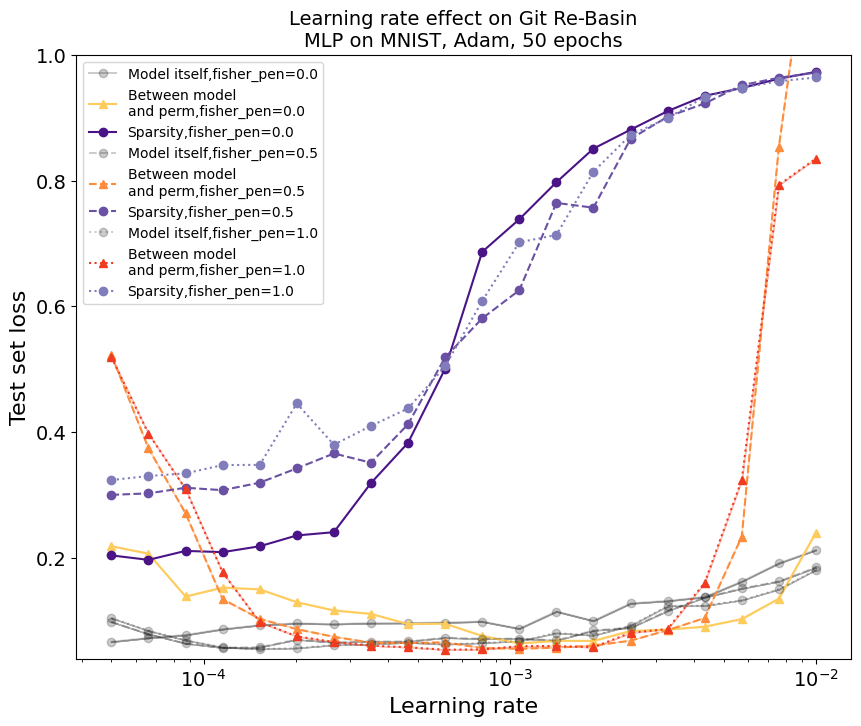

In [26]:
fig = plt.figure(figsize = (10, 8),dpi=100)
fig.patch.set_facecolor('white')
line_styles = ['solid','dashed','dotted']
red_colors = ['#fecc5c','#fd8d3c','#f03b20','#bd0026']
green_colors = ["#f2f0f7","#dadaeb","#bcbddc","#9e9ac8","#807dba","#6a51a3","#4a1486"]
green_colors.reverse()
plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, Adam, {epochs} epochs",fontsize=14)
for i, stored_results_dict in enumerate(all_results_adam):
  
  standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
  permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
  model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
  model1_entropy = np.array([d["model1_test_entropy"] for d in stored_results_dict])
  model1_sparsity = np.array([d["model1_sparsity"] for d in stored_results_dict])
  model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])
  model2_entropy = np.array([d["model2_test_entropy"] for d in stored_results_dict])
  
  standard_bumps = np.reshape(standard_bumps,[reps,-1])
  permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
  model1_loss = np.reshape(model1_loss,[reps,-1])
  model2_loss = np.reshape(model2_loss,[reps,-1])
  model1_entropy = np.reshape(model1_entropy,[reps,-1])
  model1_sparsity = np.reshape(model1_sparsity,[reps,-1])
  model2_entropy = np.reshape(model2_entropy,[reps,-1])
  
  def get_mean_and_error(vals):
    return np.mean(vals,axis=0), np.std(vals,axis=0)
  
  mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
  mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
  mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
  mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)
  mean_entropy, error_entropy = get_mean_and_error(model1_entropy)
  mean_sparsity, error_sparsity = get_mean_and_error(model1_sparsity)
  skip_lrs = []
  LRs_ = [lr for lr in LRs if lr not in skip_lrs]
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",alpha=0.2,color="black",linestyle=line_styles[i],label=f"Model itself,fisher_pen={fishers[i]}")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],
                   (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                   (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                   color=line.get_color(),
                   alpha=0.3
                   )
  
  #line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",linestyle=line_styles[i],label="Between models")
  #plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",linestyle=line_styles[i],color=red_colors[i],label=f"Between model\nand perm,fisher_pen={fishers[i]}")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())
  print(np.log(mean_entropy))
  # line, = plt.semilogx(LRs_[:len(mean_standard_bumps)], np.log(mean_entropy) - 2,marker="o",alpha=0.2,color="green",linestyle=line_styles[i],label="Entropy")
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)], mean_sparsity,marker="o",alpha=1.0,color=green_colors[i],linestyle=line_styles[i],label=f"Sparsity,fisher_pen={fishers[i]}")
  

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)
plt.ylim([0.04, 1.0])
# plt.xlim([4e-3, 0.4])
plt.legend(fontsize=10)
plt.show()
sa  

## AdamW Experimental sweep

In [27]:
reps = 1
LRs = np.exp(np.linspace(np.log(0.5*1e-4),np.log(0.01),10))
optimizers = ["adamw"]
epochs = 50
fishers = [0.0, 0.5, 1.0]

In [28]:
all_results_adamw = []
all_flattened_models_tuples_adamw = []
skipped_results_adamw = []
for fisher in fishers:
    all_flattened_models_tuples = [] # collecting all solutions every
    stored_results_dict = []
    skipped_run = []
    
    for rep in range(reps): # to get error bars
      for i_opt, optimizer in enumerate(optimizers):
        for i_LR, LR in enumerate(LRs):
    
          print("*****************************************")
          print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")
    
          flattened_models_list = get_optima(
              num_epochs = epochs,
              hessian = True,
              fisher_weight = fisher,
              config_optimizer = optimizer,
              learning_rate = LR,
              seed = int(np.random.rand()*100000000),
              )
          
          flattened_model1 = flattened_models_list[0]
          flattened_model2 = flattened_models_list[1]
          try:
            results_dict = analyze_optima(flattened_model1,flattened_model2)
        
            results_dict["LR"] = LR
            results_dict["optimizer"] = optimizer
            results_dict["epochs"] = epochs
              
            stored_results_dict.append(results_dict)
            all_flattened_models_tuples.append(flattened_models_list)
            print(results_dict)
          except ValueError:
            print(f"skipping lr:{LR}")
            skipped_run.append(LR)
              
    
    all_results_adamw.append(stored_results_dict)
    all_flattened_models_tuples_adamw.append(all_flattened_models_tuples)
    skipped_results_adamw.append(skipped_run)

*****************************************
Experiment 0 / 10
--------------------------
Starting run 0
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06719139963388443 test accuracy=0.9800000190734863 sparsity=0.2017766833305359 test entropy=17.898269653320312 train loss=0.010893226601183414 train accuracy=0.9986500144004822
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06960117816925049 test accuracy=0.9793000221252441 sparsity=0.19686003029346466 test entropy=17.90553092956543 train loss=0.011409320868551731 train accuracy=0.9983833432197571
0/P_0: 96.66117858886719
0/P_1: 55.34169006347656
0/P_2: 29.665489196777344
1/P_0: 10.855995178222656
1/P_2: 0.0
1/P_1: 6.460906982421875
2/P_2: 9.48626708984375
2/P_0: 3.6023788452148438
2/P_1: 3.328277587890625
3/P_0: 1.899505615234375
3/P_1: 0.7968292236328125
3/P_2: 7.275337219238281
4/P_0: 1.1123046875
4/P_1: 1.7352294921875
4/P_2: 2.6831588745117188
5/P_1: 0.2035980224609375
5/P_2: 1.1228408813476562
5/P_0: 0.9366455078125
6/P_1: 0.2686920166015625
6/P_2: 0.6147689819335938
6/P_0: 0.2913818359375
7/P_2: 0.0
7/P_1: 0.46978759765625
7/P_0: 0.67999267578125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.9400558471679688
9/P_0: 0.0
9/P_1: 0.3393402099609375
9/P_2: 0.7316818237304688
10/P_2: 0.0
10/P_0: 0.251312255859375
10/P_1: 0.1358184814453125
11/P_0: 0.2192535400390625
11/P_

100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07356370985507965 test accuracy=0.9798000454902649 sparsity=0.1973896473646164 test entropy=17.767656326293945 train loss=0.0016650630859658122 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  3.97it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07200197130441666 test accuracy=0.9808000326156616 sparsity=0.2012309432029724 test entropy=17.781850814819336 train loss=0.0019888149108737707 train accuracy=0.9999833703041077
0/P_0: 95.85566711425781
0/P_1: 59.11085510253906
0/P_2: 38.28173828125
1/P_0: 14.1151123046875
1/P_2: 0.0
1/P_1: 16.600738525390625
2/P_2: 15.849800109863281
2/P_0: 5.3520965576171875
2/P_1: 6.555633544921875
3/P_0: 2.2350616455078125
3/P_1: 1.309906005859375
3/P_2: 7.8759765625
4/P_0: 1.0206146240234375
4/P_1: 1.2205810546875
4/P_2: 2.4255447387695312
5/P_1: 0.3709716796875
5/P_2: 0.6671676635742188
5/P_0: 1.2140655517578125
6/P_1: 0.098876953125
6/P_2: 0.2197113037109375
6/P_0: 0.12945556640625
7/P_2: 0.0
7/P_1: 0.1071624755859375
7/P_0: 0.1436004638671875
8/P_1: 0.055938720703125
8/P_0: 0.188262939453125
8/P_2: 0.7319717407226562
9/P_0: 0.0
9/P_1: 0.25323486328125
9/P_2: 0.36003875732421875
10/P_2: 0.0
10/P_0: 0.170928955078125
10/P_1: 0.3256988525390625
11/P_

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07743211090564728 test accuracy=0.9816000461578369 sparsity=0.2135647088289261 test entropy=17.61612892150879 train loss=0.0004319641157053411 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.08it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0776546373963356 test accuracy=0.9821000695228577 sparsity=0.21949192881584167 test entropy=17.721281051635742 train loss=0.00044364642235450447 train accuracy=1.0
0/P_0: 91.89252471923828
0/P_1: 62.45827102661133
0/P_2: 53.106388092041016
1/P_0: 14.049575805664062
1/P_2: 0.0
1/P_1: 25.534957885742188
2/P_2: 16.26288604736328
2/P_0: 7.5581817626953125
2/P_1: 6.1370697021484375
3/P_0: 1.9989471435546875
3/P_1: 0.80572509765625
3/P_2: 4.9945068359375
4/P_0: 0.6870269775390625
4/P_1: 1.059112548828125
4/P_2: 1.070831298828125
5/P_1: 0.459136962890625
5/P_2: 0.669677734375
5/P_0: 0.98284912109375
6/P_1: 0.367889404296875
6/P_2: 0.6258544921875
6/P_0: 0.295166015625
7/P_2: 0.0
7/P_1: 0.2777099609375
7/P_0: 0.160186767578125
8/P_1: 0.04827880859375
8/P_0: 0.0430450439453125
8/P_2: 0.36480712890625
9/P_0: 0.0
9/P_1: 0.1958465576171875
9/P_2: 0.323089599609375
10/P_2: 0.0
10/P_0: 0.1876220703125
10/P_1: 0.090667724609375
11/P_0: 0.0592041015625
1

100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06649230420589447 test accuracy=0.983500063419342 sparsity=0.263103187084198 test entropy=17.835695266723633 train loss=0.00032398078474216163 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06930050253868103 test accuracy=0.9838000535964966 sparsity=0.2603392004966736 test entropy=17.832237243652344 train loss=0.0003355635271873325 train accuracy=1.0
0/P_0: 86.37042236328125
0/P_1: 72.13619995117188
0/P_2: 70.8099365234375
1/P_0: 12.296478271484375
1/P_2: 0.0
1/P_1: 36.76393127441406
2/P_2: 14.184097290039062
2/P_0: 4.4101715087890625
2/P_1: 2.556915283203125
3/P_0: 0.9135589599609375
3/P_1: 0.4772491455078125
3/P_2: 2.38787841796875
4/P_0: 0.21649169921875
4/P_1: 0.814910888671875
4/P_2: 0.6930084228515625
5/P_1: 0.2985687255859375
5/P_2: 0.19927978515625
5/P_0: 0.26763916015625
6/P_1: 0.157501220703125
6/P_2: 0.225921630859375
6/P_0: 0.23455810546875
7/P_2: 0.0
7/P_1: 0.06781005859375
7/P_0: 0.078765869140625
8/P_1: 0.0260467529296875
8/P_0: 0.003875732421875
8/P_2: 0.08941650390625
9/P_0: 0.0
9/P_1: 0.0086669921875
9/P_2: 0.01287841796875
10/P_2: 0.0
10/P_0: 0.0046539306640625
10/P_1: 0.0214691162109375
11/P_0: 0.03660583

100%|██████████| 50/50 [00:12<00:00,  3.91it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06978493183851242 test accuracy=0.9827000498771667 sparsity=0.5047875642776489 test entropy=17.635793685913086 train loss=0.003104316769167781 train accuracy=0.9990333318710327
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.04it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06304715573787689 test accuracy=0.9853000640869141 sparsity=0.42841440439224243 test entropy=17.844104766845703 train loss=0.0001634061918593943 train accuracy=1.0
0/P_0: 130.67239379882812
0/P_1: 100.68247985839844
0/P_2: 121.36197662353516
1/P_0: 10.823196411132812
1/P_2: 0.0
1/P_1: 27.45465087890625
2/P_2: 3.8619232177734375
2/P_0: 1.910552978515625
2/P_1: 0.65472412109375
3/P_0: 0.383453369140625
3/P_1: 0.071136474609375
3/P_2: 0.6308441162109375
4/P_0: 0.0529632568359375
4/P_1: 0.090850830078125
4/P_2: 0.094573974609375
5/P_1: 0.017822265625
5/P_2: 0.037811279296875
5/P_0: 0.0729522705078125
6/P_1: 0.013092041015625
6/P_2: 0.0035552978515625
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.06978493, dtype=float32), 'model1_test_entropy': DeviceArray(17.635794, dtype=float32), 'model1_sparsity': DeviceArray(0.50478756, dtype=float32), 'model2_test_loss': DeviceArray(0.06304716, dtype=float32), 'model2_tes

100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07686223834753036 test accuracy=0.9815000295639038 sparsity=0.6373083591461182 test entropy=18.065576553344727 train loss=0.008402944542467594 train accuracy=0.9970333576202393
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07894353568553925 test accuracy=0.9826000332832336 sparsity=0.6350846290588379 test entropy=18.00694465637207 train loss=0.00402601296082139 train accuracy=0.9987166523933411
0/P_0: 215.48448181152344
0/P_1: 137.4295654296875
0/P_2: 169.59588623046875
1/P_0: 12.136932373046875
1/P_2: 0.0
1/P_1: 32.077606201171875
2/P_2: 2.5407257080078125
2/P_0: 0.663543701171875
2/P_1: 0.6287841796875
3/P_0: 0.137451171875
3/P_1: 0.064697265625
3/P_2: 0.2713775634765625
4/P_0: 0.011474609375
4/P_1: 0.08050537109375
4/P_2: 0.04718017578125
5/P_1: 0.00616455078125
5/P_2: 0.0048370361328125
5/P_0: 0.03826904296875
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.07686224, dtype=float32), 'model1_test_entropy': DeviceArray(18.065577, dtype=float32), 'model1_sparsity': DeviceArray(0.63730836, dtype=float32), 'model2_test_loss': DeviceArray(0.07894354, dtype=float32), 'model2_test_entropy': DeviceArray(18.006945, dtype=float32), 'model2_perm

100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07779589295387268 test accuracy=0.9824000597000122 sparsity=0.7530706524848938 test entropy=17.91007423400879 train loss=0.005148153752088547 train accuracy=0.9982666969299316
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08184351772069931 test accuracy=0.9797000288963318 sparsity=0.7507485151290894 test entropy=17.93979263305664 train loss=0.008126181550323963 train accuracy=0.9973500370979309
0/P_0: 338.9749450683594
0/P_1: 183.2476806640625
0/P_2: 237.61669921875
1/P_0: 8.47991943359375
1/P_2: 0.0
1/P_1: 34.2435302734375
2/P_2: 1.857177734375
2/P_0: 0.89892578125
2/P_1: 0.69085693359375
3/P_0: 0.2218017578125
3/P_1: 0.219451904296875
3/P_2: 0.194183349609375
4/P_0: 0.01983642578125
4/P_1: 0.02471923828125
4/P_2: 0.001129150390625
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.00067138671875
6/P_1: 0.001190185546875
6/P_2: 0.001190185546875
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.07779589, dtype=float32), 'model1_test_entropy': DeviceArray(17.910074, dtype=float32), 'model1_sparsity': DeviceArray(0.75307065, dtype=float32), 'model2_test_loss': DeviceArray(0.08184352, dtype=float32), 'model2_test_entropy': DeviceArray(17.939793, dty

100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07939472794532776 test accuracy=0.978600025177002 sparsity=0.833935022354126 test entropy=17.715740203857422 train loss=0.01736823283135891 train accuracy=0.9946500062942505
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08439730852842331 test accuracy=0.9758000373840332 sparsity=0.8417539596557617 test entropy=17.523971557617188 train loss=0.023987501859664917 train accuracy=0.9919166564941406
0/P_0: 468.1017150878906
0/P_1: 196.6471405029297
0/P_2: 243.400390625
1/P_0: 7.22076416015625
1/P_2: 0.0
1/P_1: 61.237091064453125
2/P_2: 5.73748779296875
2/P_0: 1.4222412109375
2/P_1: 1.31829833984375
3/P_0: 0.1927490234375
3/P_1: 0.1041259765625
3/P_2: 0.378936767578125
4/P_0: 0.05804443359375
4/P_1: 0.330810546875
4/P_2: 0.132568359375
5/P_1: 0.09649658203125
5/P_2: 0.02728271484375
5/P_0: 0.010009765625
6/P_1: 0.00146484375
6/P_2: 0.03106689453125
6/P_0: 0.001953125
7/P_2: 0.0
7/P_1: 0.006103515625
7/P_0: 0.005859375
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.000335693359375
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.07939473, dtype=float32), 'model1_test_entropy': DeviceArray(17.71574, dtype=float32), 'model1_sparsity': DeviceArray(0.833935, dtyp

100%|██████████| 50/50 [00:12<00:00,  3.86it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09372729063034058 test accuracy=0.9727000594139099 sparsity=0.9041709899902344 test entropy=16.696516036987305 train loss=0.03746776655316353 train accuracy=0.9879166483879089
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.00it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0692216008901596 test accuracy=0.9802000522613525 sparsity=0.9024813771247864 test entropy=17.31783676147461 train loss=0.024772778153419495 train accuracy=0.9927833676338196
0/P_0: 521.48388671875
0/P_1: 154.41018676757812
0/P_2: 180.1268310546875
1/P_0: 1.61395263671875
1/P_2: 0.0
1/P_1: 47.41650390625
2/P_2: 8.858078002929688
2/P_0: 0.37066650390625
2/P_1: 1.398651123046875
3/P_0: 0.03277587890625
3/P_1: 0.00018310546875
3/P_2: 0.27410888671875
4/P_0: 0.0
4/P_1: 0.201141357421875
4/P_2: 0.421783447265625
5/P_1: 0.050811767578125
5/P_2: 0.027557373046875
5/P_0: 0.0150146484375
6/P_1: 0.0977783203125
6/P_2: 0.016937255859375
6/P_0: 0.0025634765625
7/P_2: 0.0
7/P_1: 0.009857177734375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 9.1552734375e-05
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.09372729, dtype=float32), 'model1_test_entropy': DeviceArray(16.696516, dtype=float32), 'model1_sparsity': DeviceArray(0.904171, dtype

100%|██████████| 50/50 [00:12<00:00,  3.96it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10156098008155823 test accuracy=0.9709000587463379 sparsity=0.9425753355026245 test entropy=15.504655838012695 train loss=0.053624942898750305 train accuracy=0.9834833145141602
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0797639787197113 test accuracy=0.9761000275611877 sparsity=0.9439746141433716 test entropy=15.644744873046875 train loss=0.04880430921912193 train accuracy=0.9855000376701355
0/P_0: 457.84698486328125
0/P_1: 108.48701477050781
0/P_2: 111.53043365478516
1/P_0: 0.00115966796875
1/P_2: 0.0
1/P_1: 15.831130981445312
2/P_2: 3.490814208984375
2/P_0: 0.38214111328125
2/P_1: 1.24761962890625
3/P_0: 0.0
3/P_1: 0.0
3/P_2: 0.366363525390625
4/P_0: 0.0
4/P_1: 0.211761474609375
4/P_2: 0.1434478759765625
5/P_1: 0.189056396484375
5/P_2: 0.11334228515625
5/P_0: 0.0
6/P_1: 0.098052978515625
6/P_2: 0.0230865478515625
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.003509521484375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.00164794921875
9/P_0: 0.0
9/P_1: 0.00091552734375
9/P_2: 0.003570556640625
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 1.52587890625e-05
11/P_0: 0.0
11/P_2: 0.0001220703125
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'model1_test_loss': DeviceArray(0.10156098, dt

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10339721292257309 test accuracy=0.970300018787384 sparsity=0.2881959080696106 test entropy=18.413570404052734 train loss=0.08837034553289413 train accuracy=0.9780333638191223
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10580931603908539 test accuracy=0.9694000482559204 sparsity=0.29113495349884033 test entropy=18.41960334777832 train loss=0.09180629998445511 train accuracy=0.9772000312805176
0/P_0: 106.04891204833984
0/P_1: 51.075721740722656
0/P_2: 22.949748992919922
1/P_0: 6.168098449707031
1/P_2: 0.0
1/P_1: 2.6664886474609375
2/P_2: 3.976348876953125
2/P_0: 1.312286376953125
2/P_1: 0.9570083618164062
3/P_0: 0.3075103759765625
3/P_1: 0.05156707763671875
3/P_2: 1.93280029296875
4/P_0: 0.09185791015625
4/P_1: 0.1360321044921875
4/P_2: 0.775848388671875
5/P_1: 0.11104583740234375
5/P_2: 0.7324371337890625
5/P_0: 0.2014007568359375
6/P_1: 0.061309814453125
6/P_2: 0.4301300048828125
6/P_0: 0.0052642822265625
7/P_2: 0.0
7/P_1: 0.00756072998046875
7/P_0: 0.0508575439453125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.042388916015625
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.10339721, dtype=float32), 'model1_test_entropy': DeviceArray(18.41357, dt

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06626534461975098 test accuracy=0.9791000485420227 sparsity=0.3008989095687866 test entropy=18.37835121154785 train loss=0.03572787716984749 train accuracy=0.9930833578109741
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06635969877243042 test accuracy=0.9797000288963318 sparsity=0.2944125533103943 test entropy=18.383481979370117 train loss=0.03820766881108284 train accuracy=0.9921500086784363
0/P_0: 123.14039611816406
0/P_1: 58.99418640136719
0/P_2: 27.829421997070312
1/P_0: 4.4495086669921875
1/P_2: 0.0
1/P_1: 3.1664657592773438
2/P_2: 3.9973297119140625
2/P_0: 0.6788482666015625
2/P_1: 0.9355239868164062
3/P_0: 0.3625030517578125
3/P_1: 0.2937164306640625
3/P_2: 2.0948410034179688
4/P_0: 0.18841552734375
4/P_1: 0.6148681640625
4/P_2: 1.1798095703125
5/P_1: 0.12395477294921875
5/P_2: 0.6181411743164062
5/P_0: 0.221771240234375
6/P_1: 0.32501983642578125
6/P_2: 0.542327880859375
6/P_0: 0.2557373046875
7/P_2: 0.0
7/P_1: 0.145416259765625
7/P_0: 0.17877197265625
8/P_1: 0.0268096923828125
8/P_0: 0.0242767333984375
8/P_2: 0.7194061279296875
9/P_0: 0.0
9/P_1: 0.0999298095703125
9/P_2: 0.5293960571289062
10/P_2: 0.0
10/P_0: 0.0363006591796875
10/P_1: 0.0662536

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.058581966906785965 test accuracy=0.9826000332832336 sparsity=0.2988640069961548 test entropy=18.27629280090332 train loss=0.0078014591708779335 train accuracy=0.9992833733558655
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05817248299717903 test accuracy=0.9827000498771667 sparsity=0.29360926151275635 test entropy=18.300405502319336 train loss=0.008747422136366367 train accuracy=0.9989833235740662
0/P_0: 138.04432678222656
0/P_1: 63.22836685180664
0/P_2: 35.580474853515625
1/P_0: 4.6632080078125
1/P_2: 0.0
1/P_1: 9.576210021972656
2/P_2: 7.816612243652344
2/P_0: 1.4307403564453125
2/P_1: 2.637054443359375
3/P_0: 0.393524169921875
3/P_1: 0.5162811279296875
3/P_2: 3.4880752563476562
4/P_0: 0.3245849609375
4/P_1: 0.4109954833984375
4/P_2: 1.1717910766601562
5/P_1: 0.1873016357421875
5/P_2: 0.45043182373046875
5/P_0: 0.2265167236328125
6/P_1: 0.1407928466796875
6/P_2: 0.26091766357421875
6/P_0: 0.06585693359375
7/P_2: 0.0
7/P_1: 0.07635498046875
7/P_0: 0.118072509765625
8/P_1: 0.0333404541015625
8/P_0: 0.0046234130859375
8/P_2: 0.35137939453125
9/P_0: 0.0
9/P_1: 0.023162841796875
9/P_2: 0.0336456298828125
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.00738525390625
11/P_0:

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05234537646174431 test accuracy=0.9842000603675842 sparsity=0.3391962945461273 test entropy=18.185789108276367 train loss=0.001612079213373363 train accuracy=0.9999666810035706
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.054291415959596634 test accuracy=0.9836000204086304 sparsity=0.38893482089042664 test entropy=18.272329330444336 train loss=0.003665582975372672 train accuracy=0.9998999834060669
0/P_0: 153.36245727539062
0/P_1: 77.59251403808594
0/P_2: 51.8709716796875
1/P_0: 3.4842529296875
1/P_2: 0.0
1/P_1: 16.628402709960938
2/P_2: 8.139739990234375
2/P_0: 1.158905029296875
2/P_1: 1.3081512451171875
3/P_0: 0.541717529296875
3/P_1: 0.3535614013671875
3/P_2: 1.7883453369140625
4/P_0: 0.096923828125
4/P_1: 0.4400482177734375
4/P_2: 0.6014251708984375
5/P_1: 0.3614501953125
5/P_2: 0.5772476196289062
5/P_0: 0.2046051025390625
6/P_1: 0.125396728515625
6/P_2: 0.238006591796875
6/P_0: 0.0269622802734375
7/P_2: 0.0
7/P_1: 0.03778076171875
7/P_0: 0.0086212158203125
8/P_1: 0.027252197265625
8/P_0: 0.0
8/P_2: 0.132415771484375
9/P_0: 0.0
9/P_1: 0.009674072265625
9/P_2: 0.197021484375
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0089111328125
11/P_0: 0.0
11/P_2: 0.0867080688

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.048873983323574066 test accuracy=0.9855000376701355 sparsity=0.4602496027946472 test entropy=17.909286499023438 train loss=0.0028058085590600967 train accuracy=0.9998999834060669
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.04995668679475784 test accuracy=0.98580002784729 sparsity=0.45306453108787537 test entropy=18.213945388793945 train loss=0.0015269045252352953 train accuracy=0.9999833703041077
0/P_0: 200.92344665527344
0/P_1: 82.57465362548828
0/P_2: 73.654296875
1/P_0: 3.33843994140625
1/P_2: 0.0
1/P_1: 12.466079711914062
2/P_2: 3.1611862182617188
2/P_0: 0.448089599609375
2/P_1: 0.7469329833984375
3/P_0: 0.009552001953125
3/P_1: 0.037078857421875
3/P_2: 0.5455093383789062
4/P_0: 0.0
4/P_1: 0.10186767578125
4/P_2: 0.1606903076171875
5/P_1: 0.032073974609375
5/P_2: 0.0480499267578125
5/P_0: 0.030487060546875
6/P_1: 0.013336181640625
6/P_2: 0.07312774658203125
6/P_0: 0.008148193359375
7/P_2: 0.0
7/P_1: 0.02667236328125
7/P_0: 0.01556396484375
8/P_1: 0.0052642822265625
8/P_0: 0.00067138671875
8/P_2: 0.01540374755859375
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.04887398, dtype=float32), 'model1_test_entropy': DeviceArray(17.909286, 

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.050993699580430984 test accuracy=0.9857000708580017 sparsity=0.5892356038093567 test entropy=18.119144439697266 train loss=0.002690060529857874 train accuracy=0.9997000098228455
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.062274906784296036 test accuracy=0.9819000363349915 sparsity=0.6009337902069092 test entropy=17.98373794555664 train loss=0.010210745967924595 train accuracy=0.9977666735649109
0/P_0: 298.0936584472656
0/P_1: 110.05303955078125
0/P_2: 89.41985321044922
1/P_0: 4.32421875
1/P_2: 0.0
1/P_1: 11.260467529296875
2/P_2: 1.0680923461914062
2/P_0: 0.5357666015625
2/P_1: 0.2234649658203125
3/P_0: 0.04766845703125
3/P_1: 0.0144195556640625
3/P_2: 0.08660888671875
4/P_0: 0.01129150390625
4/P_1: 0.0619659423828125
4/P_2: 0.02437591552734375
5/P_1: 0.014404296875
5/P_2: 0.01239776611328125
5/P_0: 0.0
6/P_1: 0.0009613037109375
6/P_2: 0.00716400146484375
6/P_0: 0.000518798828125
7/P_2: 0.0
7/P_1: 0.00732421875
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.0
{'model1_test_loss': DeviceArray(0.0509937, dtype=float32), 'model1_test_entropy': DeviceArray(18.119144, dtype=float32), 'model1_sparsity': DeviceArray(0.5892356, dtype=float32), 'model2_test_loss': Devi

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06338001042604446 test accuracy=0.9828000664710999 sparsity=0.7081356048583984 test entropy=17.95442008972168 train loss=0.010137313045561314 train accuracy=0.997700035572052
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05486573651432991 test accuracy=0.9838000535964966 sparsity=0.7040833234786987 test entropy=17.93954086303711 train loss=0.009077136404812336 train accuracy=0.9975833296775818
0/P_0: 475.2460632324219
0/P_1: 161.64552307128906
0/P_2: 93.18700408935547
1/P_0: 5.39410400390625
1/P_2: 0.0
1/P_1: 9.019256591796875
2/P_2: 0.737884521484375
2/P_0: 0.2073974609375
2/P_1: 0.07012939453125
3/P_0: 0.0267333984375
3/P_1: 0.00482177734375
3/P_2: 0.0444183349609375
4/P_0: 0.0
4/P_1: 0.015838623046875
4/P_2: 0.0052947998046875
5/P_1: 0.00445556640625
5/P_2: 0.0011749267578125
5/P_0: 0.02337646484375
6/P_1: 0.0953369140625
6/P_2: 0.01442718505859375
6/P_0: 0.03240966796875
7/P_2: 0.0
7/P_1: 0.0732421875
7/P_0: 0.02252197265625
8/P_1: 0.02777099609375
8/P_0: 0.0008544921875
8/P_2: 0.02373504638671875
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.06338001, dtype=float32), 'model1_test_entropy': DeviceArray(17.95442, dtype=float32), '

100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06789149343967438 test accuracy=0.9791000485420227 sparsity=0.8041463494300842 test entropy=17.082494735717773 train loss=0.020277900621294975 train accuracy=0.9951666593551636
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07186184823513031 test accuracy=0.9806000590324402 sparsity=0.7929946780204773 test entropy=17.232145309448242 train loss=0.01723623462021351 train accuracy=0.9952499866485596
0/P_0: 570.0269165039062
0/P_1: 181.9858856201172
0/P_2: 96.50379180908203
1/P_0: 5.50506591796875
1/P_2: 0.0
1/P_1: 10.43316650390625
2/P_2: 0.852691650390625
2/P_0: 0.100341796875
2/P_1: 0.112152099609375
3/P_0: 0.0230712890625
3/P_1: 0.178497314453125
3/P_2: 0.04909515380859375
4/P_0: 0.0003662109375
4/P_1: 0.003753662109375
4/P_2: 0.01786041259765625
5/P_1: 0.005706787109375
5/P_2: 0.00423431396484375
5/P_0: 0.00445556640625
6/P_1: 0.0079345703125
6/P_2: 2.288818359375e-05
6/P_0: 0.000244140625
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.06789149, dtype=float32), 'model1_test_entropy': DeviceArray(17.082495, dtype=float32), 'model1_sparsity': DeviceArray(0.80414635, dtype=float32), 'model2_test_loss': DeviceArray(0.07186185, dtype=float32

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08274229615926743 test accuracy=0.9753000736236572 sparsity=0.8773890733718872 test entropy=16.41463279724121 train loss=0.03937749192118645 train accuracy=0.9885666966438293
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09422225505113602 test accuracy=0.9745000600814819 sparsity=0.8768657445907593 test entropy=17.229890823364258 train loss=0.06716741621494293 train accuracy=0.9820166826248169
0/P_0: 442.4325256347656
0/P_1: 108.27145385742188
0/P_2: 76.46102142333984
1/P_0: 1.0059814453125
1/P_2: 0.0
1/P_1: 9.611892700195312
2/P_2: 3.041748046875
2/P_0: 0.018798828125
2/P_1: 0.5919036865234375
3/P_0: 6.103515625e-05
3/P_1: 0.0
3/P_2: 0.34737396240234375
4/P_0: 0.0
4/P_1: 0.1006927490234375
4/P_2: 0.03488922119140625
5/P_1: 0.043731689453125
5/P_2: 0.06610870361328125
5/P_0: -6.103515625e-05
6/P_1: 0.0229034423828125
6/P_2: 0.00666046142578125
6/P_0: 0.0001220703125
7/P_2: 0.0
7/P_1: 0.00579833984375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.012054443359375
9/P_0: 0.0
9/P_1: 0.0159759521484375
9/P_2: 0.002716064453125
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0
{'model1_test_loss': DeviceArray(0.0827423, dtype=float32), 'model1_test_entropy': DeviceArray(16.41463

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.11987850815057755 test accuracy=0.9648000597953796 sparsity=0.9094794392585754 test entropy=17.0737247467041 train loss=0.09713084250688553 train accuracy=0.9724000096321106
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.12701553106307983 test accuracy=0.9638000726699829 sparsity=0.9110648036003113 test entropy=17.3504638671875 train loss=0.10006829351186752 train accuracy=0.9736166596412659
0/P_0: 272.6017150878906
0/P_1: 39.63038635253906
0/P_2: 59.01800537109375
1/P_0: 0.0
1/P_2: 0.0
1/P_1: 9.026702880859375
2/P_2: 1.6742630004882812
2/P_0: 0.100433349609375
2/P_1: 0.3163604736328125
3/P_0: 0.0
3/P_1: 0.0
3/P_2: 0.11385345458984375
4/P_0: 0.0
4/P_1: 0.07691192626953125
4/P_2: 0.03009796142578125
5/P_1: 0.0030059814453125
5/P_2: 0.0
5/P_0: 0.0
6/P_1: -7.62939453125e-06
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.11987851, dtype=float32), 'model1_test_entropy': DeviceArray(17.073725, dtype=float32), 'model1_sparsity': DeviceArray(0.90947944, dtype=float32), 'model2_test_loss': DeviceArray(0.12701553, dtype=float32), 'model2_test_entropy': DeviceArray(17.350464, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.12701553, dtype=float3

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.11452894657850266 test accuracy=0.9681000709533691 sparsity=0.3130396008491516 test entropy=18.467195510864258 train loss=0.10491718351840973 train accuracy=0.9733333587646484
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.11284204572439194 test accuracy=0.9687000513076782 sparsity=0.3065533936023712 test entropy=18.472003936767578 train loss=0.10089730471372604 train accuracy=0.9754166603088379
0/P_0: 106.98822784423828
0/P_1: 50.57102584838867
0/P_2: 22.09490203857422
1/P_0: 5.658561706542969
1/P_2: 0.0
1/P_1: 1.4042587280273438
2/P_2: 3.2874908447265625
2/P_0: 0.924957275390625
2/P_1: 0.6075439453125
3/P_0: 0.70806884765625
3/P_1: 0.26644134521484375
3/P_2: 2.2348785400390625
4/P_0: 0.2200927734375
4/P_1: 0.1464996337890625
4/P_2: 0.37969970703125
5/P_1: 0.1866912841796875
5/P_2: 0.554962158203125
5/P_0: 0.318817138671875
6/P_1: 0.2042694091796875
6/P_2: 0.6162261962890625
6/P_0: 0.184356689453125
7/P_2: 0.0
7/P_1: 0.34503173828125
7/P_0: 0.26715087890625
8/P_1: 0.02947998046875
8/P_0: 0.013092041015625
8/P_2: 0.7840576171875
9/P_0: 0.0
9/P_1: 0.04560089111328125
9/P_2: 0.1653289794921875
10/P_2: 0.0
10/P_0: 0.0291900634765625
10/P_1: 0.05727386474609375

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07035813480615616 test accuracy=0.9794000387191772 sparsity=0.32025253772735596 test entropy=18.426158905029297 train loss=0.046032220125198364 train accuracy=0.9906666874885559
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07118890434503555 test accuracy=0.9788000583648682 sparsity=0.31864336133003235 test entropy=18.43221092224121 train loss=0.04394777491688728 train accuracy=0.9912333488464355
0/P_0: 123.99012756347656
0/P_1: 60.06349182128906
0/P_2: 23.936077117919922
1/P_0: 3.65557861328125
1/P_2: 0.0
1/P_1: 2.9599685668945312
2/P_2: 4.869255065917969
2/P_0: 0.9643096923828125
2/P_1: 0.6194534301757812
3/P_0: 0.2596893310546875
3/P_1: 0.16179656982421875
3/P_2: 2.4227294921875
4/P_0: 0.150238037109375
4/P_1: 0.19895172119140625
4/P_2: 0.7147598266601562
5/P_1: 0.16834259033203125
5/P_2: 0.6258544921875
5/P_0: 0.22283935546875
6/P_1: 0.0625762939453125
6/P_2: 0.2661590576171875
6/P_0: 0.0386962890625
7/P_2: 0.0
7/P_1: 0.1655120849609375
7/P_0: 0.08880615234375
8/P_1: 0.06142425537109375
8/P_0: 0.005157470703125
8/P_2: 0.7111434936523438
9/P_0: 0.0
9/P_1: 0.07059478759765625
9/P_2: 0.1011505126953125
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.01849365234375
11/P_0

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05211843550205231 test accuracy=0.9839000701904297 sparsity=0.3283423185348511 test entropy=18.361982345581055 train loss=0.011414248496294022 train accuracy=0.9988000392913818
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0548725500702858 test accuracy=0.9832000732421875 sparsity=0.3359517455101013 test entropy=18.36384391784668 train loss=0.01172071322798729 train accuracy=0.9987000226974487
0/P_0: 151.8394012451172
0/P_1: 65.55580139160156
0/P_2: 33.099571228027344
1/P_0: 3.08935546875
1/P_2: 0.0
1/P_1: 6.850105285644531
2/P_2: 6.253288269042969
2/P_0: 1.00927734375
2/P_1: 1.8016510009765625
3/P_0: 0.4186553955078125
3/P_1: 0.3264312744140625
3/P_2: 3.4404830932617188
4/P_0: 0.1746978759765625
4/P_1: 0.228179931640625
4/P_2: 0.6135711669921875
5/P_1: 0.1060791015625
5/P_2: 0.9053192138671875
5/P_0: 0.160980224609375
6/P_1: 0.1574249267578125
6/P_2: 0.45650482177734375
6/P_0: 0.06317138671875
7/P_2: 0.0
7/P_1: 0.13330078125
7/P_0: 0.0360870361328125
8/P_1: 0.07440185546875
8/P_0: 0.044281005859375
8/P_2: 0.4852294921875
9/P_0: 0.0
9/P_1: 0.0956268310546875
9/P_2: 0.26041412353515625
10/P_2: 0.0
10/P_0: 0.004119873046875
10/P_1: 0.0767822265625
11/P_0: 0.0

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.051086682826280594 test accuracy=0.9853000640869141 sparsity=0.3823785185813904 test entropy=18.308488845825195 train loss=0.0022646933794021606 train accuracy=0.9998833537101746
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.048670828342437744 test accuracy=0.9865000247955322 sparsity=0.4441007971763611 test entropy=18.411441802978516 train loss=0.00689753657206893 train accuracy=0.9995499849319458
0/P_0: 170.5303497314453
0/P_1: 79.46907806396484
0/P_2: 51.02555465698242
1/P_0: 3.3892059326171875
1/P_2: 0.0
1/P_1: 12.015213012695312
2/P_2: 5.8277435302734375
2/P_0: 1.02716064453125
2/P_1: 1.26824951171875
3/P_0: 0.2105712890625
3/P_1: 0.2875518798828125
3/P_2: 1.462310791015625
4/P_0: 0.1049041748046875
4/P_1: 0.421142578125
4/P_2: 0.7517242431640625
5/P_1: 0.146820068359375
5/P_2: 0.2618255615234375
5/P_0: 0.105438232421875
6/P_1: 0.107421875
6/P_2: 0.238861083984375
6/P_0: 0.000946044921875
7/P_2: 0.0
7/P_1: 0.05059814453125
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.125244140625
9/P_0: 0.0
9/P_1: 0.0379638671875
9/P_2: 0.04376220703125
10/P_2: 0.0
10/P_0: 0.0005035400390625
10/P_1: 0.01983642578125
11/P_0: 0.0084228515625
11/P_2: 0.09307861328125
11/P_1: 0

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05012974515557289 test accuracy=0.9856000542640686 sparsity=0.41359949111938477 test entropy=18.248004913330078 train loss=0.0018508415669202805 train accuracy=0.9998500347137451
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.04959900304675102 test accuracy=0.9863000512123108 sparsity=0.4470679759979248 test entropy=18.24227523803711 train loss=0.0014861358795315027 train accuracy=0.9999666810035706
0/P_0: 201.63656616210938
0/P_1: 87.78795623779297
0/P_2: 67.88956451416016
1/P_0: 3.271575927734375
1/P_2: 0.0
1/P_1: 11.325897216796875
2/P_2: 2.6446304321289062
2/P_0: 0.569549560546875
2/P_1: 0.57366943359375
3/P_0: 0.071929931640625
3/P_1: 0.0255126953125
3/P_2: 0.49019622802734375
4/P_0: 0.0
4/P_1: 0.0826873779296875
4/P_2: 0.1149139404296875
5/P_1: 0.103607177734375
5/P_2: 0.07968902587890625
5/P_0: 0.00677490234375
6/P_1: 0.0347900390625
6/P_2: 0.0731048583984375
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0167236328125
7/P_0: 0.001953125
8/P_1: 0.001220703125
8/P_0: 0.001251220703125
8/P_2: 0.045013427734375
9/P_0: 0.0
9/P_1: 0.01129150390625
9/P_2: 0.007049560546875
10/P_2: 0.0
10/P_0: 0.0101318359375
10/P_1: 0.000762939453125
11/P_0: 0.0
11/P_2: 0.0077667236328125
11

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05131266266107559 test accuracy=0.9846000671386719 sparsity=0.591648280620575 test entropy=18.277694702148438 train loss=0.007609911262989044 train accuracy=0.99836665391922
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07664626091718674 test accuracy=0.9777000546455383 sparsity=0.6318600177764893 test entropy=18.258766174316406 train loss=0.025608325377106667 train accuracy=0.9926833510398865
0/P_0: 354.8079833984375
0/P_1: 124.21530151367188
0/P_2: 81.555419921875
1/P_0: 5.745880126953125
1/P_2: 0.0
1/P_1: 7.9407501220703125
2/P_2: 0.920745849609375
2/P_0: 0.18072509765625
2/P_1: 0.1378936767578125
3/P_0: 0.020263671875
3/P_1: 0.086395263671875
3/P_2: 0.1143646240234375
4/P_0: 0.007080078125
4/P_1: 0.0444793701171875
4/P_2: 0.05704498291015625
5/P_1: 0.011810302734375
5/P_2: 0.0011138916015625
5/P_0: 0.0
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.05131266, dtype=float32), 'model1_test_entropy': DeviceArray(18.277695, dtype=float32), 'model1_sparsity': DeviceArray(0.5916483, dtype=float32), 'model2_test_loss': DeviceArray(0.07664626, dtype=float32), 'model2_test_entropy': DeviceArray(18.258766, dtype=float32), 'model2_permuted_t

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06278154999017715 test accuracy=0.9824000597000122 sparsity=0.7237370610237122 test entropy=17.838247299194336 train loss=0.018231872469186783 train accuracy=0.9962000250816345
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06122170761227608 test accuracy=0.9844000339508057 sparsity=0.7056471109390259 test entropy=17.804523468017578 train loss=0.012795955874025822 train accuracy=0.9969666600227356
0/P_0: 507.56280517578125
0/P_1: 164.24476623535156
0/P_2: 85.41320037841797
1/P_0: 4.84783935546875
1/P_2: 0.0
1/P_1: 7.68402099609375
2/P_2: 0.5115737915039062
2/P_0: 0.351806640625
2/P_1: 0.318115234375
3/P_0: 0.03643798828125
3/P_1: 0.021484375
3/P_2: 0.0657196044921875
4/P_0: 0.00653076171875
4/P_1: 0.002655029296875
4/P_2: 4.57763671875e-05
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.00030517578125
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.06278155, dtype=float32), 'model1_test_entropy': DeviceArray(17.838247, dtype=float32), 'model1_sparsity': DeviceArray(0.72373706, dtype=float32), 'model2_test_loss': DeviceArray(0.06122171, dtype=float32), 'model2_test_entropy': DeviceArray(17.804523, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05506810545921326 test accuracy=0.9847000241279602 sparsity=0.8243969678878784 test entropy=16.819379806518555 train loss=0.017376407980918884 train accuracy=0.9964166879653931
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06916829198598862 test accuracy=0.9797000288963318 sparsity=0.7937686443328857 test entropy=17.389726638793945 train loss=0.025387296453118324 train accuracy=0.9932166934013367
0/P_0: 469.35064697265625
0/P_1: 135.4544219970703
0/P_2: 78.78363037109375
1/P_0: 1.9266357421875
1/P_2: 0.0
1/P_1: 8.66357421875
2/P_2: 1.1961212158203125
2/P_0: 0.12152099609375
2/P_1: 0.377410888671875
3/P_0: 0.013671875
3/P_1: 0.010528564453125
3/P_2: 0.22863006591796875
4/P_0: 0.00030517578125
4/P_1: 0.03887939453125
4/P_2: 0.0209503173828125
5/P_1: 0.00860595703125
5/P_2: 0.00301361083984375
5/P_0: 0.044677734375
6/P_1: 0.03485107421875
6/P_2: 0.01764678955078125
6/P_0: 0.00543212890625
7/P_2: 0.0
7/P_1: 0.000579833984375
7/P_0: 0.0001220703125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.00101470947265625
9/P_0: 0.0
9/P_1: 0.000335693359375
9/P_2: 0.0001983642578125
10/P_2: 0.0
10/P_0: 0.00018310546875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': 

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07224281877279282 test accuracy=0.9791000485420227 sparsity=0.8571546077728271 test entropy=16.846454620361328 train loss=0.042128678411245346 train accuracy=0.9897333383560181
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10177917033433914 test accuracy=0.9711000323295593 sparsity=0.8646133542060852 test entropy=16.72262191772461 train loss=0.06861437857151031 train accuracy=0.980983316898346
0/P_0: 391.1408386230469
0/P_1: 83.6194076538086
0/P_2: 61.6959114074707
1/P_0: 0.376678466796875
1/P_2: 0.0
1/P_1: 7.47296142578125
2/P_2: 1.4208221435546875
2/P_0: 0.0250244140625
2/P_1: 0.185089111328125
3/P_0: 0.0
3/P_1: 0.0
3/P_2: 0.01663970947265625
4/P_0: 0.0
4/P_1: 0.0118408203125
4/P_2: 0.00347900390625
5/P_1: 0.001434326171875
5/P_2: 0.0197296142578125
5/P_0: 0.009918212890625
6/P_1: 0.0020751953125
6/P_2: 0.00290679931640625
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0039520263671875
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.00022125244140625
9/P_0: 0.0
9/P_1: 0.000396728515625
9/P_2: 1.52587890625e-05
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0
{'model1_test_loss': DeviceArray(0.07224282, dtype=float32), 'model1_test_entropy': DeviceArray(16.846455, dtype=float32), 'model1_sp

100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1664893925189972 test accuracy=0.9532000422477722 sparsity=0.9127482175827026 test entropy=16.93782615661621 train loss=0.15931349992752075 train accuracy=0.9557666778564453
--------------------------
Starting run 1
train_ds labels hash 7532395635832872255
test_ds labels hash -6352152531210844809
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.11674785614013672 test accuracy=0.9676000475883484 sparsity=0.9065783619880676 test entropy=17.16805648803711 train loss=0.09256718307733536 train accuracy=0.9748666882514954
0/P_0: 197.99996948242188
0/P_1: 23.83026123046875
0/P_2: 43.629478454589844
1/P_0: 0.0413055419921875
1/P_2: 0.0
1/P_1: 6.9565582275390625
2/P_2: 0.8188018798828125
2/P_0: 0.110015869140625
2/P_1: 0.1418914794921875
3/P_0: 0.0
3/P_1: 0.0
3/P_2: 0.13915634155273438
4/P_0: 0.0
4/P_1: 0.13814544677734375
4/P_2: 0.0381011962890625
5/P_1: 0.00615692138671875
5/P_2: 0.000461578369140625
5/P_0: 0.0
6/P_1: 0.0055389404296875
6/P_2: 0.00833892822265625
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.00432586669921875
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 3.4332275390625e-05
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.16648939, dtype=float32), 'model1_test_entropy': DeviceArray(16.937826, dtype=float32), 'model1_sparsity': DeviceArray(0.9127482, dtype=float32), 'mode

[2.884704  2.8773797 2.868815  2.8812017 2.8699305 2.8940084 2.8853633
 2.8744535 2.8152    2.7411404]
[2.9130878 2.9111733 2.9056048 2.9006405 2.8853195 2.896969  2.8878365
 2.8380542 2.7981732 2.8375406]
[2.915996  2.9137714 2.9102824 2.9073648 2.9040558 2.9056814 2.8813448
 2.8225317 2.8241403 2.8295493]


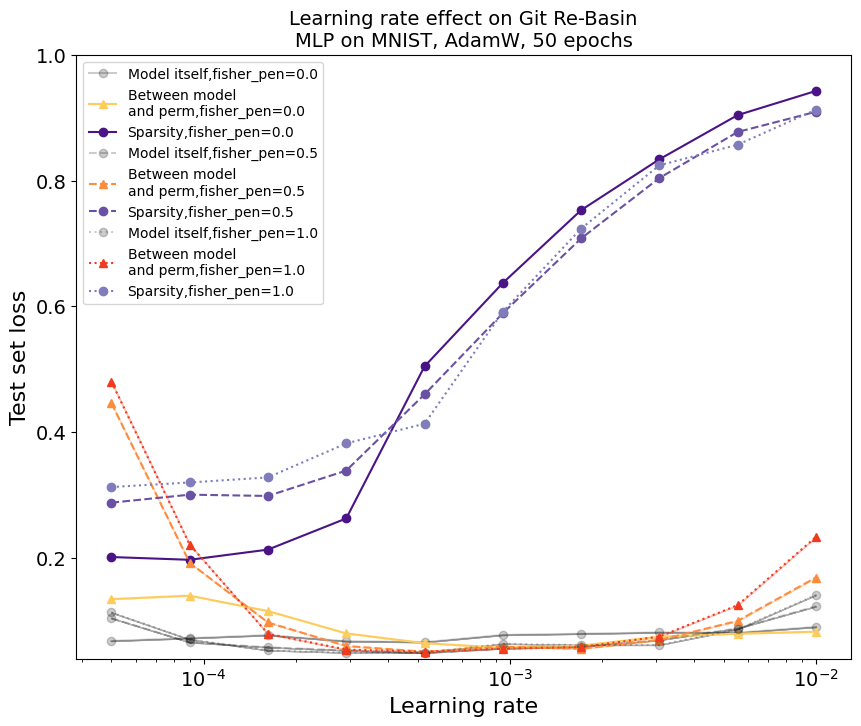

In [32]:
fig = plt.figure(figsize = (10, 8),dpi=100)
fig.patch.set_facecolor('white')
line_styles = ['solid','dashed','dotted']
red_colors = ['#fecc5c','#fd8d3c','#f03b20','#bd0026']
green_colors = ["#f2f0f7","#dadaeb","#bcbddc","#9e9ac8","#807dba","#6a51a3","#4a1486"]
green_colors.reverse()
plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, AdamW, {epochs} epochs",fontsize=14)
for i, stored_results_dict in enumerate(all_results_adamw):
  
  standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
  permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
  model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
  model1_entropy = np.array([d["model1_test_entropy"] for d in stored_results_dict])
  model1_sparsity = np.array([d["model1_sparsity"] for d in stored_results_dict])
  model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])
  model2_entropy = np.array([d["model2_test_entropy"] for d in stored_results_dict])
  
  standard_bumps = np.reshape(standard_bumps,[reps,-1])
  permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
  model1_loss = np.reshape(model1_loss,[reps,-1])
  model2_loss = np.reshape(model2_loss,[reps,-1])
  model1_entropy = np.reshape(model1_entropy,[reps,-1])
  model1_sparsity = np.reshape(model1_sparsity,[reps,-1])
  model2_entropy = np.reshape(model2_entropy,[reps,-1])
  
  def get_mean_and_error(vals):
    return np.mean(vals,axis=0), np.std(vals,axis=0)
  
  mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
  mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
  mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
  mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)
  mean_entropy, error_entropy = get_mean_and_error(model1_entropy)
  mean_sparsity, error_sparsity = get_mean_and_error(model1_sparsity)
  skip_lrs = skipped_results_adamw[i]
  LRs_ = [lr for lr in LRs if lr not in skip_lrs]
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",alpha=0.2,color="black",linestyle=line_styles[i],label=f"Model itself,fisher_pen={fishers[i]}")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],
                   (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                   (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                   color=line.get_color(),
                   alpha=0.3
                   )
  
  #line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",linestyle=line_styles[i],label="Between models")
  #plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",linestyle=line_styles[i],color=red_colors[i],label=f"Between model\nand perm,fisher_pen={fishers[i]}")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())
  print(np.log(mean_entropy))
  # line, = plt.semilogx(LRs_[:len(mean_standard_bumps)], np.log(mean_entropy) - 2,marker="o",alpha=0.2,color="green",linestyle=line_styles[i],label="Entropy")
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)], mean_sparsity,marker="o",alpha=1.0,color=green_colors[i],linestyle=line_styles[i],label=f"Sparsity,fisher_pen={fishers[i]}")
  
 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)
plt.ylim([0.04, 1.0])
#plt.xlim([4e-3, 0.4])
plt.legend(fontsize=10)
plt.show()
  